# Seizure Frequency Comparison

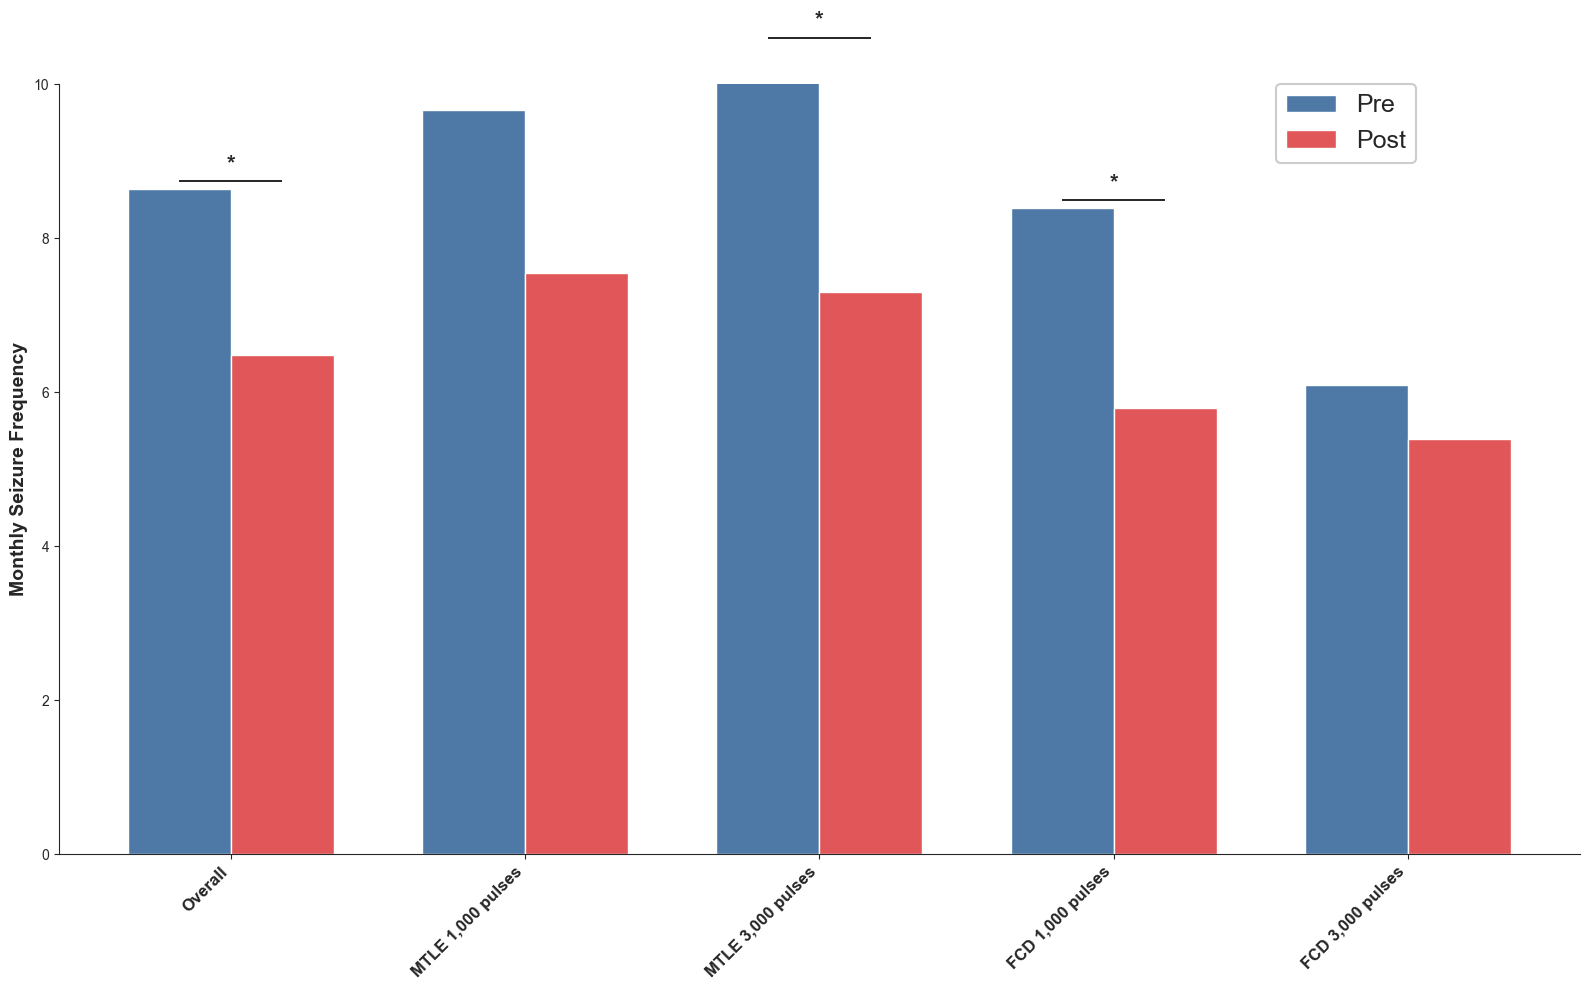

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the data
df = pd.read_csv('data_for_ROI.csv')

# Create the plot with larger figure size for better spacing
plt.figure(figsize=(16, 10))
sns.set_style("ticks")
plt.grid(False)

# Remove top and right spines
sns.despine()

# Define the groups and their labels
groups = [
    {'name': 'Overall', 'condition': (df['etiology'].notna())},
    {'name': 'MTLE 1,000 pulses', 'condition': (df['etiology'] == 'TLE') & (df['Stim_11000_23000'] == 1)},
    {'name': 'MTLE 3,000 pulses', 'condition': (df['etiology'] == 'TLE') & (df['Stim_11000_23000'] == 2)},
    {'name': 'FCD 1,000 pulses', 'condition': (df['etiology'] == 'FCD') & (df['Stim_11000_23000'] == 1)},
    {'name': 'FCD 3,000 pulses', 'condition': (df['etiology'] == 'FCD') & (df['Stim_11000_23000'] == 2)}
]

# Set the positions for the bars
x = np.arange(len(groups))
bar_width = 0.35

# Define custom colors
pre_color = '#4e79a7'  # Dark blue
post_color = '#e15759'  # Red

# Get current axis
ax = plt.gca()

# Plot pre and post seizure frequencies
for i, group in enumerate(groups):
    group_data = df[group['condition']]
    
    # Calculate means
    pre_mean = group_data['Pre_seizure_frequency'].mean()
    post_mean = group_data['Post_seizure_frequency'].mean()
    
    # Plot bars
    ax.bar(x[i] - bar_width/2, pre_mean, width=bar_width, color=pre_color, label='Pre' if i == 0 else '')
    ax.bar(x[i] + bar_width/2, post_mean, width=bar_width, color=post_color, label='Post' if i == 0 else '')
    
    # Perform paired t-test if there's enough data
    if len(group_data) >= 2:
        t_stat, p_value = stats.ttest_rel(
            group_data['Pre_seizure_frequency'].dropna(),
            group_data['Post_seizure_frequency'].dropna()
        )
        
        # Add asterisk and connecting line if p < 0.05
        if p_value < 0.05:
            # Get current y-axis limits
            y_min, y_max = ax.get_ylim()
            
            # Calculate positions for the line and asterisk
            max_y = max(pre_mean, post_mean)
            # Set spacing for all specified groups to 0.1
            if i in [0, 2, 3]:  # Overall, MTLE 3,000 pulses, and FCD 1,000 pulses groups
                line_y = max_y + 0.1  # 0.1 spacing for these groups
            else:
                line_y = max_y + 0.1  # Default spacing for other groups
            text_y = line_y * 1.01  # Keep asterisk close to the line
            
            # Ensure the asterisk stays within the plot
            if text_y > y_max * 0.95:  # If too close to the top
                ax.set_ylim(top=y_max * 1.05)  # Minimal increase to y-axis limit
                y_max = y_max * 1.05
            
            # Draw the horizontal line (thinner line)
            ax.hlines(y=line_y, xmin=x[i] - bar_width/2, xmax=x[i] + bar_width/2, 
                    color='black', linewidth=1.2, clip_on=False)
            # Add the asterisk (slightly smaller)
            ax.text(x[i], text_y, '*', ha='center', va='bottom', 
                   fontsize=16, fontweight='bold', clip_on=False)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels([g['name'] for g in groups], rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Seizure Frequency', fontsize=14, fontweight='bold')

# Get the legend and modify its properties
legend = ax.legend(fontsize=12*1.5,  # 1.5 times larger font
                 bbox_to_anchor=(0.8, 1),  # Position at (0.8, 1)
                 loc='upper left',
                 borderaxespad=0.)

# Make the legend box larger
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_alpha(1)

# Ensure only bottom and left spines are visible and styled
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Make the visible spines solid lines
ax.spines['bottom'].set_linestyle('-')
ax.spines['left'].set_linestyle('-')

# Make sure ticks are only on bottom and left
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Adjust layout to make room for x-axis labels
plt.tight_layout()

# Save the figure with higher DPI
plt.savefig('seizure_frequency_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

# Connectivity Visualization

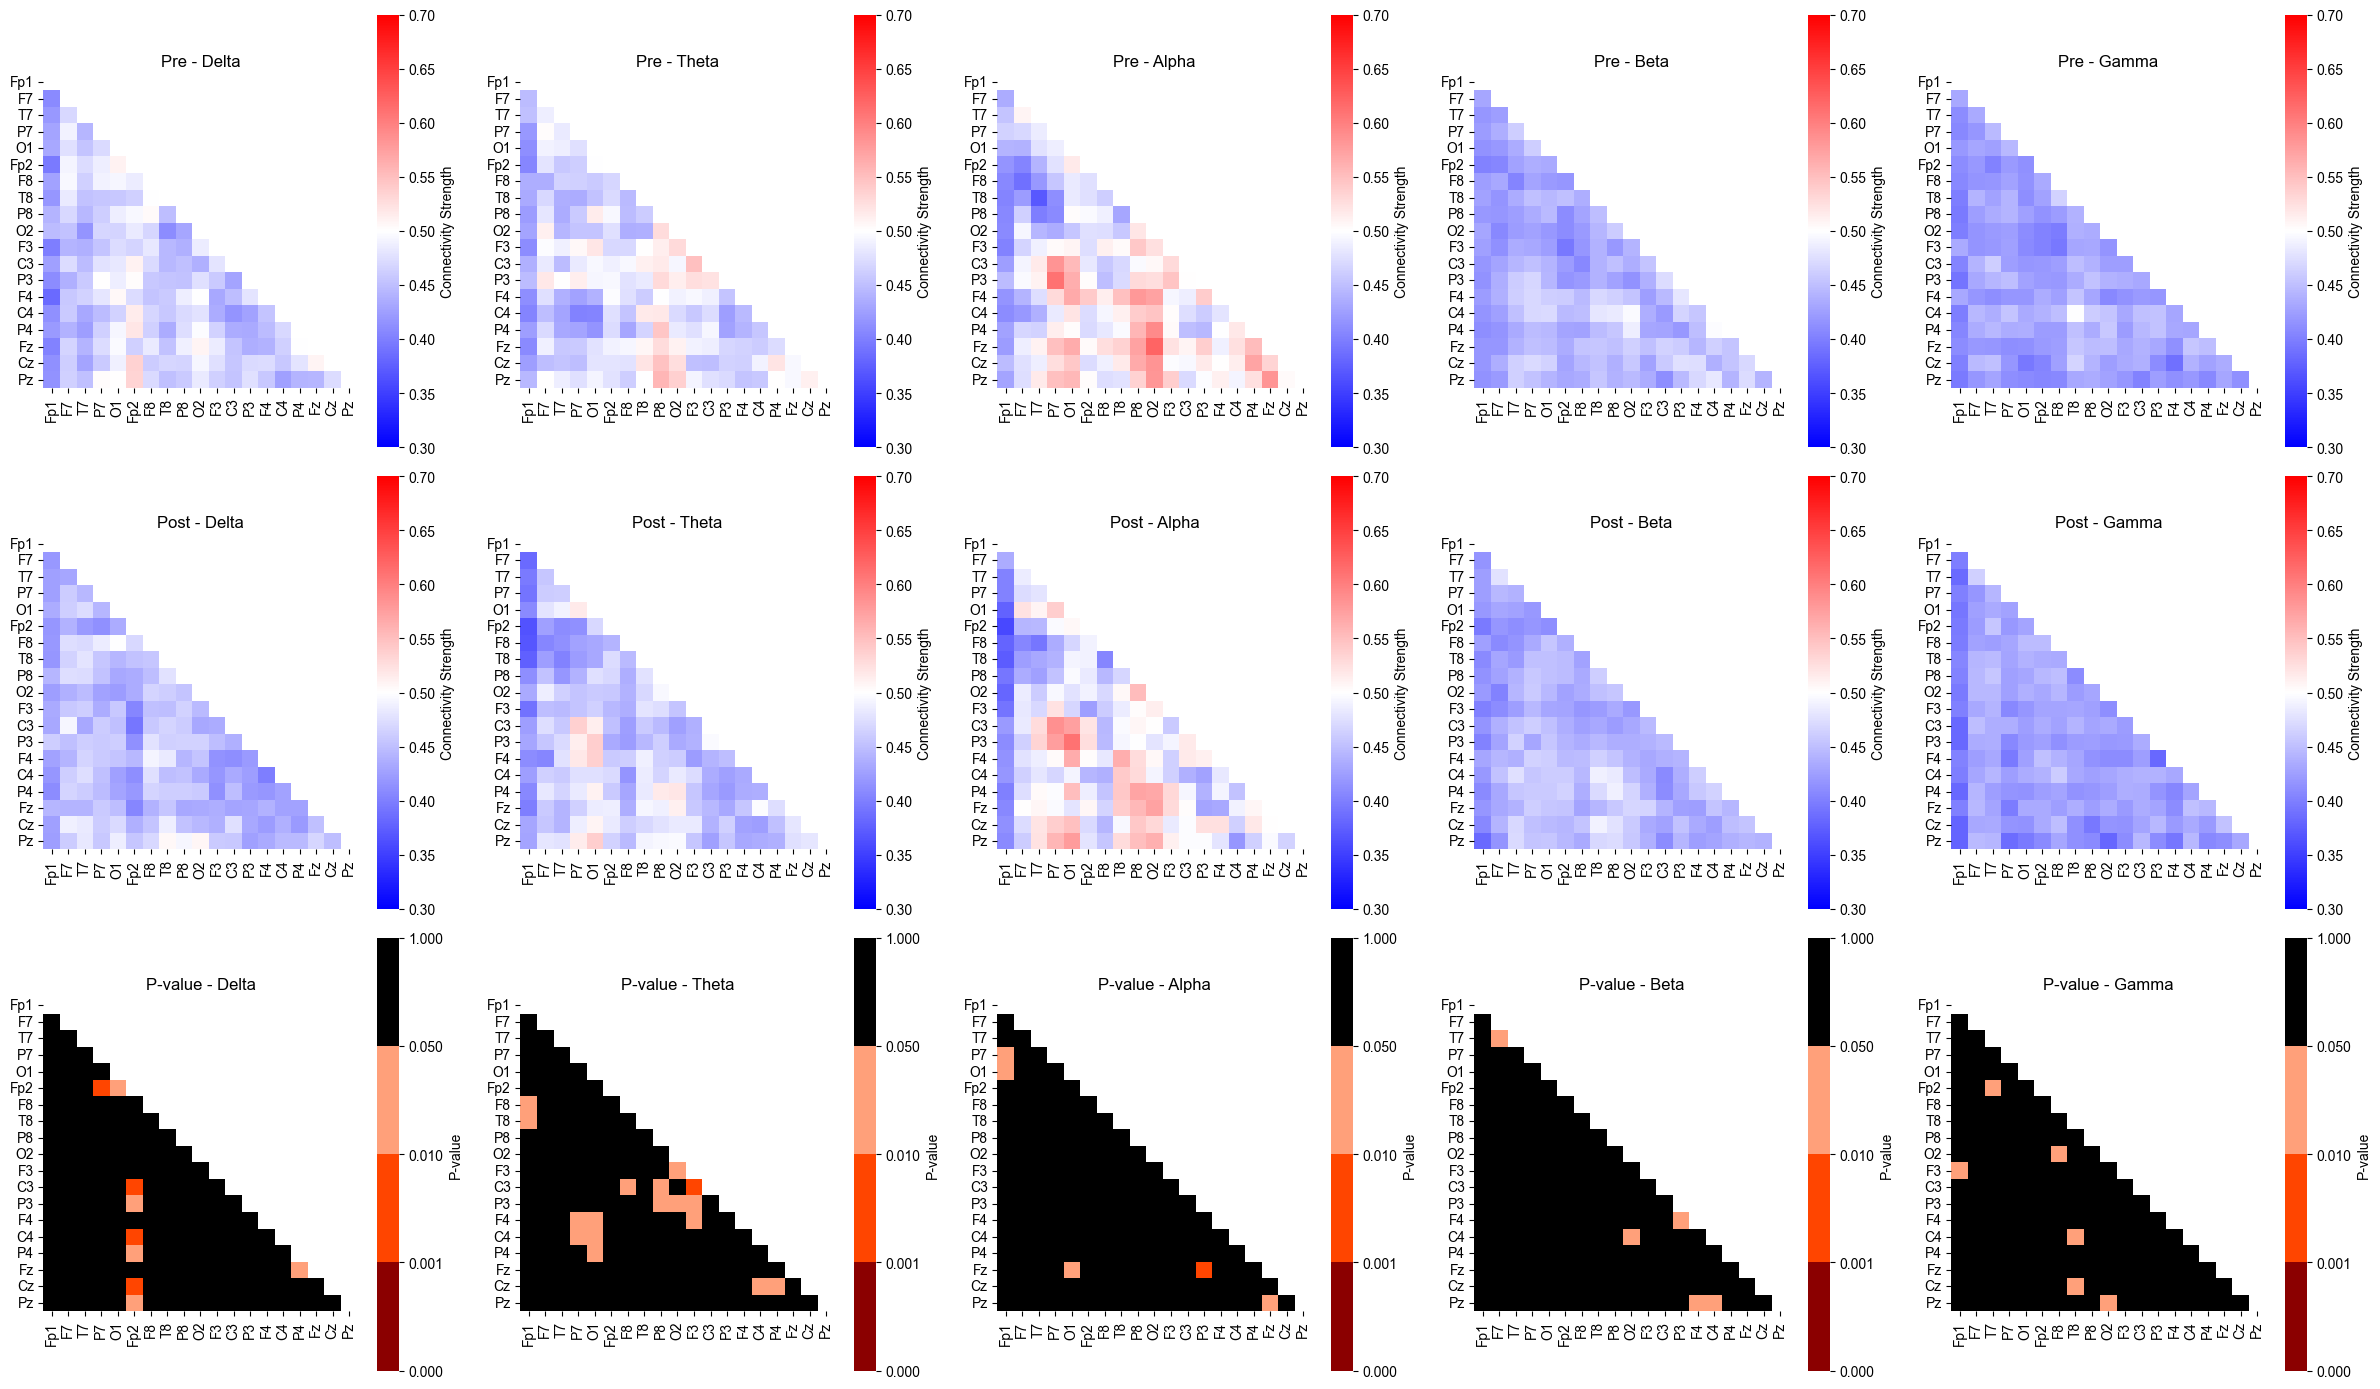

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rcParams

# 글씨체 Arial 설정
rcParams['font.family'] = 'Arial'

# CSV 불러오기
df = pd.read_csv("data_for_area_analysis_raw (1st + 2nd experiment).csv")

# EEG 채널 순서
channels = ['Fp1', 'F7', 'T7', 'P7', 'O1', 'Fp2', 'F8', 'T8', 'P8', 'O2',
            'F3', 'C3', 'P3', 'F4', 'C4', 'P4', 'Fz', 'Cz', 'Pz']
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Responsiveness = 0인 group만 선택 (오타 수정됨)
df_responsive = df.copy()

# 결과 저장용 딕셔너리
adj_matrices_pre = {}
adj_matrices_post = {}
adj_matrices_pval = {}

# 행렬 구성
for band in bands:
    pre_matrix = np.zeros((19, 19))
    post_matrix = np.zeros((19, 19))
    pval_matrix = np.ones((19, 19))

    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            if i > j:
                pre_col = f'pre_{band}-{ch1}-{ch2}' if f'pre_{band}-{ch1}-{ch2}' in df_responsive.columns else f'pre_{band}-{ch2}-{ch1}'
                post_col = f'post_{band}-{ch1}-{ch2}' if f'post_{band}-{ch1}-{ch2}' in df_responsive.columns else f'post_{band}-{ch2}-{ch1}'

                if pre_col in df_responsive.columns and post_col in df_responsive.columns:
                    pre_vals = df_responsive[pre_col]
                    post_vals = df_responsive[post_col]

                    pre_matrix[i, j] = pre_vals.mean()
                    post_matrix[i, j] = post_vals.mean()

                    t_stat, p_val = ttest_rel(pre_vals, post_vals, nan_policy='omit')
                    pval_matrix[i, j] = p_val

    adj_matrices_pre[band] = pre_matrix
    adj_matrices_post[band] = post_matrix
    adj_matrices_pval[band] = pval_matrix

# 색상 정의
pval_cmap = ListedColormap(['#8b0000', '#ff4500', '#ffa07a', 'black'])
pval_norm = BoundaryNorm([0.0, 0.001, 0.01, 0.05, 1.0], ncolors=4)

pre_vmin, pre_vmax = 0.3, 0.7

# 시각화
fig, axs = plt.subplots(3, 5, figsize=(24, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, band in enumerate(bands):
    # Pre matrix
    hm1 = sns.heatmap(adj_matrices_pre[band], xticklabels=channels, yticklabels=channels,
                      cmap='bwr', vmin=pre_vmin, vmax=pre_vmax,
                      mask=np.triu(np.ones((19, 19)), 0), ax=axs[0, idx], cbar=True, square=True)
    axs[0, idx].set_title(f"Pre - {band}")
    axs[0, idx].tick_params(axis='x', labelrotation=90)
    axs[0, idx].tick_params(axis='y', labelrotation=0)
    hm1.collections[0].colorbar.set_label('Connectivity Strength')

    # Post matrix
    hm2 = sns.heatmap(adj_matrices_post[band], xticklabels=channels, yticklabels=channels,
                      cmap='bwr', vmin=pre_vmin, vmax=pre_vmax,
                      mask=np.triu(np.ones((19, 19)), 0), ax=axs[1, idx], cbar=True, square=True)
    axs[1, idx].set_title(f"Post - {band}")
    axs[1, idx].tick_params(axis='x', labelrotation=90)
    axs[1, idx].tick_params(axis='y', labelrotation=0)
    hm2.collections[0].colorbar.set_label('Connectivity Strength')

    # P-value matrix
    hm3 = sns.heatmap(adj_matrices_pval[band], xticklabels=channels, yticklabels=channels,
                      cmap=pval_cmap, norm=pval_norm,
                      mask=np.triu(np.ones((19, 19)), 0), ax=axs[2, idx], cbar=True, square=True)
    axs[2, idx].set_title(f"P-value - {band}")
    axs[2, idx].tick_params(axis='x', labelrotation=90)
    axs[2, idx].tick_params(axis='y', labelrotation=0)
    hm3.collections[0].colorbar.set_label('P-value')

plt.tight_layout()

# EPS 저장
plt.savefig("eeg_connectivity_analysis.eps", format='eps', dpi=300)
plt.show()


# ROI-based Connectivity Visualization

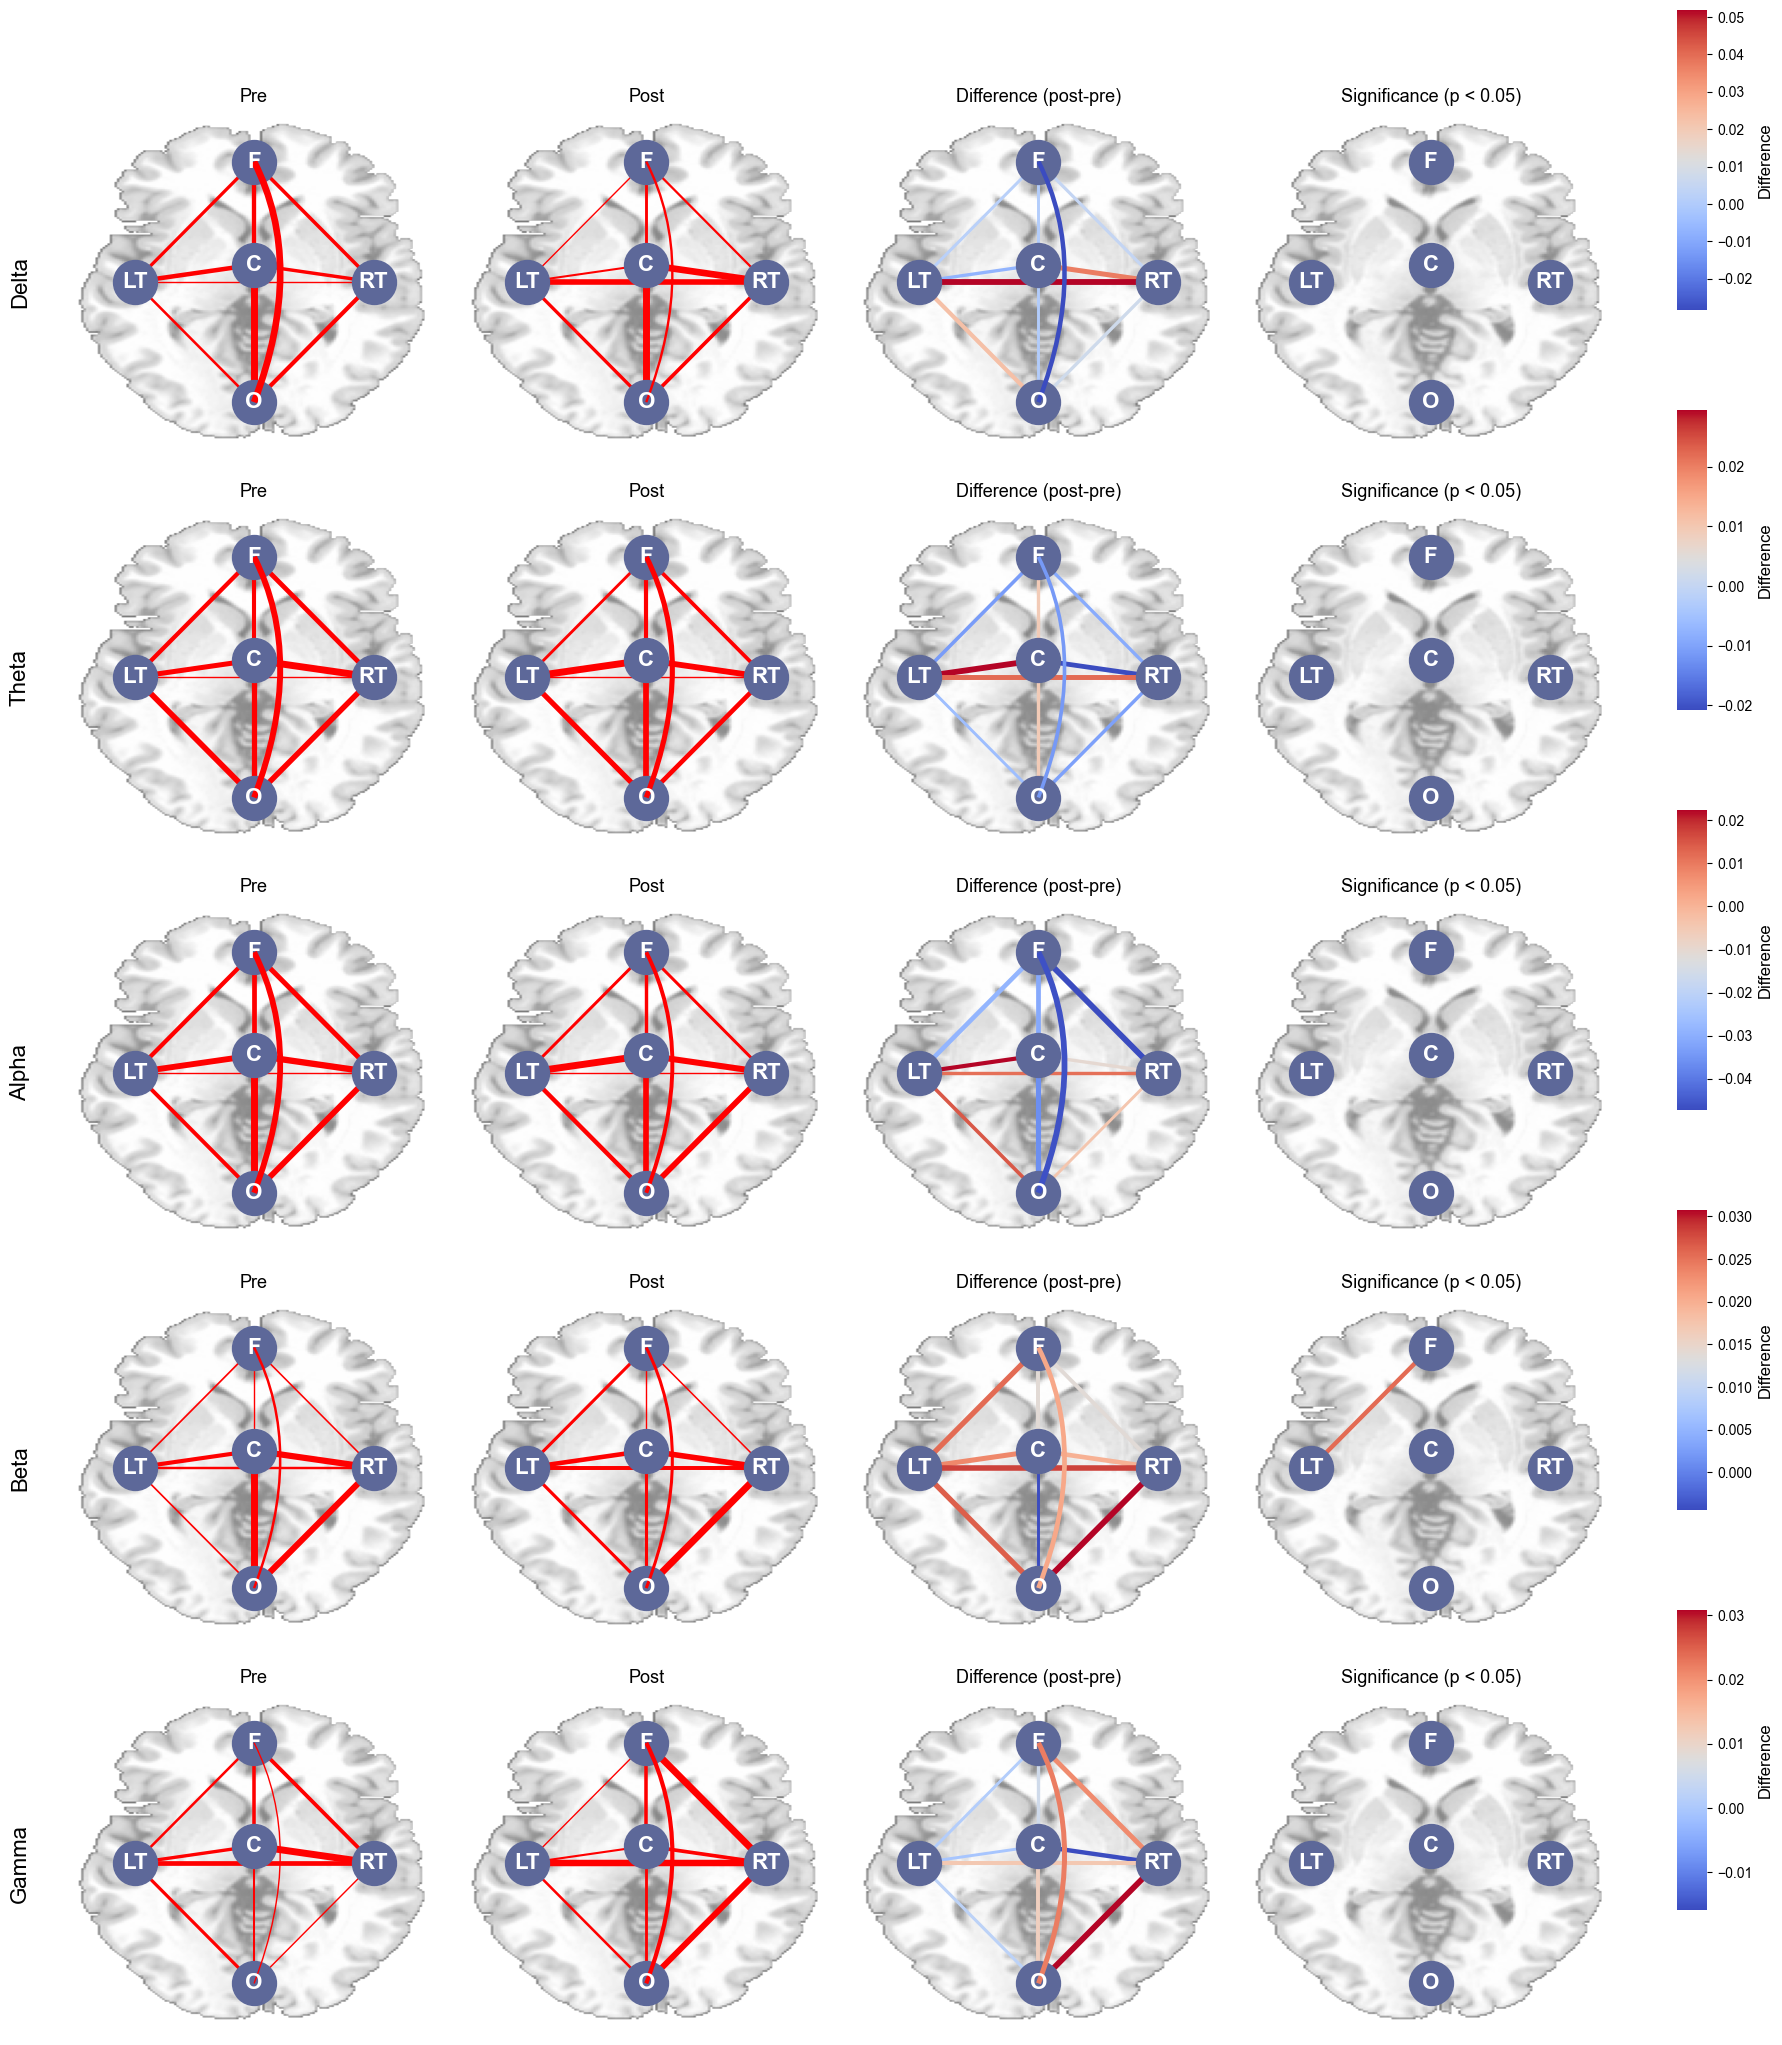

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
from scipy.stats import ttest_rel
import matplotlib as mpl

# --- 데이터 불러오기 및 필터링 ---
df = pd.read_csv('data_for_ROI.csv')
regions = ['Frontal', 'Central', 'LeftTemporal', 'RightTemporal', 'Occipital']
region_abbr = {'Frontal': 'F', 'Central': 'C', 'Occipital': 'O', 'LeftTemporal': 'LT', 'RightTemporal': 'RT'}
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

df = df[(df['etiology'].str.lower() == 'fcd')]
# df = df[(df['etiology'].str.lower() == 'tle')]

def extract_matrix_band(df, prefix, band, regions):
    mat = np.full((5, 5), np.nan)
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            if i < j or i == j:
                continue
            col1 = f'{prefix}{band}-{r1}-{r2}'
            col2 = f'{prefix}{band}-{r2}-{r1}'
            val = None
            if col1 in df.columns:
                val = df[col1].mean()
            elif col2 in df.columns:
                val = df[col2].mean()
            if val is not None:
                mat[i, j] = val
    for i in range(5):
        for j in range(i):
            mat[j, i] = mat[i, j]
    np.fill_diagonal(mat, 0)
    return mat

def extract_matrix_band_allsubs(df, prefix, band, regions):
    mats = []
    for idx, row in df.iterrows():
        mat = np.full((5, 5), np.nan)
        for i, r1 in enumerate(regions):
            for j, r2 in enumerate(regions):
                if i < j or i == j:
                    continue
                col1 = f'{prefix}{band}-{r1}-{r2}'
                col2 = f'{prefix}{band}-{r2}-{r1}'
                val = None
                if col1 in df.columns:
                    val = row[col1]
                elif col2 in df.columns:
                    val = row[col2]
                if not pd.isnull(val):
                    mat[i, j] = val
        for i in range(5):
            for j in range(i):
                mat[j, i] = mat[i, j]
        np.fill_diagonal(mat, 0)
        mats.append(mat)
    return np.array(mats)

def plot_brain_network(connectivity_matrix, title, ax, sig_mask=None, imgfile='brain_outline_transparent.png',
                       edge_cmap=None, vmin=None, vmax=None, node_color='#5D6899', edge_width_mode='strength',
                       min_width=1, max_width=5, frontal_occipital_curve=0.14):
    pos = {'Frontal': (0.5, 0.85), 'Central': (0.5, 0.55), 'Occipital': (0.5, 0.15),
           'LeftTemporal': (0.18, 0.5), 'RightTemporal': (0.82, 0.5)}
    G = nx.Graph()
    for name in regions:
        G.add_node(name)
    for i in range(len(regions)):
        for j in range(i+1, len(regions)):
            weight = connectivity_matrix[i, j]
            if not np.isnan(weight) and weight != 0:
                if sig_mask is None or sig_mask[i, j]:
                    G.add_edge(regions[i], regions[j], weight=weight)
    edges = G.edges(data=True)

    img = mpimg.imread(imgfile)
    ax.imshow(img, extent=[0, 1, 0, 1], aspect='auto', alpha=0.6)
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=1000, ax=ax)
    for node, (x, y) in pos.items():
        ax.text(x, y, region_abbr[node], ha='center', va='center', fontsize=16, color='white', fontfamily='Arial', fontweight='bold')

    all_weights = [abs(d['weight']) for (u, v, d) in edges]
    min_w, max_w = (min(all_weights), max(all_weights)) if all_weights else (0, 1)

    for (u, v, d) in edges:
        if set([u, v]) == set(['Frontal', 'Occipital']):
            continue
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        color = 'red' if edge_cmap is None else edge_cmap(mpl.colors.Normalize(vmin=vmin, vmax=vmax)(d['weight']))
        width = (min_width + (abs(d['weight']) - min_w) / (max_w - min_w) * (max_width - min_width)) if max_w > min_w else (min_width + max_width) / 2
        ax.plot([x0, x1], [y0, y1], color=color, linewidth=width, zorder=1)

    if G.has_edge('Frontal', 'Occipital'):
        x0, y0 = pos['Frontal']
        x1, y1 = pos['Occipital']
        xc, yc = pos['Central']
        ctrl_x, ctrl_y = xc + frontal_occipital_curve, yc
        path = Path([(x0, y0), (ctrl_x, ctrl_y), (x1, y1)], [Path.MOVETO, Path.CURVE3, Path.CURVE3])
        color = 'red' if edge_cmap is None else edge_cmap(mpl.colors.Normalize(vmin=vmin, vmax=vmax)(connectivity_matrix[0,4]))
        w = abs(connectivity_matrix[0,4])
        width = (min_width + (w - min_w) / (max_w - min_w) * (max_width - min_width)) if max_w > min_w else (min_width + max_width) / 2
        ax.add_patch(patches.PathPatch(path, facecolor='none', lw=width, edgecolor=color, zorder=2))

    ax.set_title(title, fontsize=13, fontfamily='Arial')
    ax.axis('off')

# ---- 전체 Figure 설정 (5 bands x 4 panels) ----
fig, axes = plt.subplots(len(bands), 4, figsize=(20, 25))
plt.subplots_adjust(wspace=0.05, hspace=0.15)

for row, band in enumerate(bands):
    pre_mat = extract_matrix_band(df, 'pre_', band, regions)
    post_mat = extract_matrix_band(df, 'post_', band, regions)
    diff_mat = post_mat - pre_mat
    pre_all = extract_matrix_band_allsubs(df, 'pre_', band, regions)
    post_all = extract_matrix_band_allsubs(df, 'post_', band, regions)
    t_mat = np.full((5,5), np.nan)
    p_mat = np.full((5,5), np.nan)
    for i in range(5):
        for j in range(5):
            if i < j:
                continue
            x = pre_all[:,i,j]
            y = post_all[:,i,j]
            mask = ~np.isnan(x) & ~np.isnan(y)
            if np.sum(mask) > 1:
                t, p = ttest_rel(x[mask], y[mask])
                t_mat[i,j] = t
                p_mat[i,j] = p
    for i in range(5):
        for j in range(i):
            t_mat[j,i] = t_mat[i,j]
            p_mat[j,i] = p_mat[i,j]
    np.fill_diagonal(t_mat, 0)
    np.fill_diagonal(p_mat, 1)

    vmin = np.nanmin(diff_mat)
    vmax = np.nanmax(diff_mat)
    edge_cmap = mpl.cm.coolwarm

    plot_brain_network(pre_mat, 'Pre', axes[row, 0], node_color='#5D6899', edge_width_mode='strength', min_width=1, max_width=5)
    plot_brain_network(post_mat, 'Post', axes[row, 1], node_color='#5D6899', edge_width_mode='strength', min_width=1, max_width=5)
    plot_brain_network(diff_mat, 'Difference (post-pre)', axes[row, 2], edge_cmap=edge_cmap, vmin=vmin, vmax=vmax,
                       node_color='#5D6899', edge_width_mode='strength', min_width=2.1, max_width=4.2)
    plot_brain_network(diff_mat, 'Significance (p < 0.05)', axes[row, 3], sig_mask=(p_mat<0.05), edge_cmap=edge_cmap, vmin=vmin, vmax=vmax,
                       node_color='#5D6899', edge_width_mode='strength', min_width=2.1, max_width=4.2)
    axes[row, 0].text(-0.1, 0.5, band, va='center', ha='right', fontsize=16, fontfamily='Arial', rotation=90, transform=axes[row, 0].transAxes)

    # ---- 밴드별 colorbar 추가 ----
    cbar_ax = fig.add_axes([0.93, 0.8 - row * 0.16, 0.015, 0.12])  # 위치 조정
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=edge_cmap, norm=norm, orientation='vertical')
    cb1.set_label('Difference', fontsize=12, fontfamily='Arial')
    cb1.outline.set_visible(False)

fig.savefig('all_bands_network_with_individual_cbar-fcd.eps', dpi=600, bbox_inches='tight')
plt.show()

# Correlation Analysis

Loading and filtering data for FCD patients...
Total patients: 39
FCD patients: 20
Analyzing correlations...
Saved significant correlations to fcd_significant_correlations.csv
Creating correlation plots...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


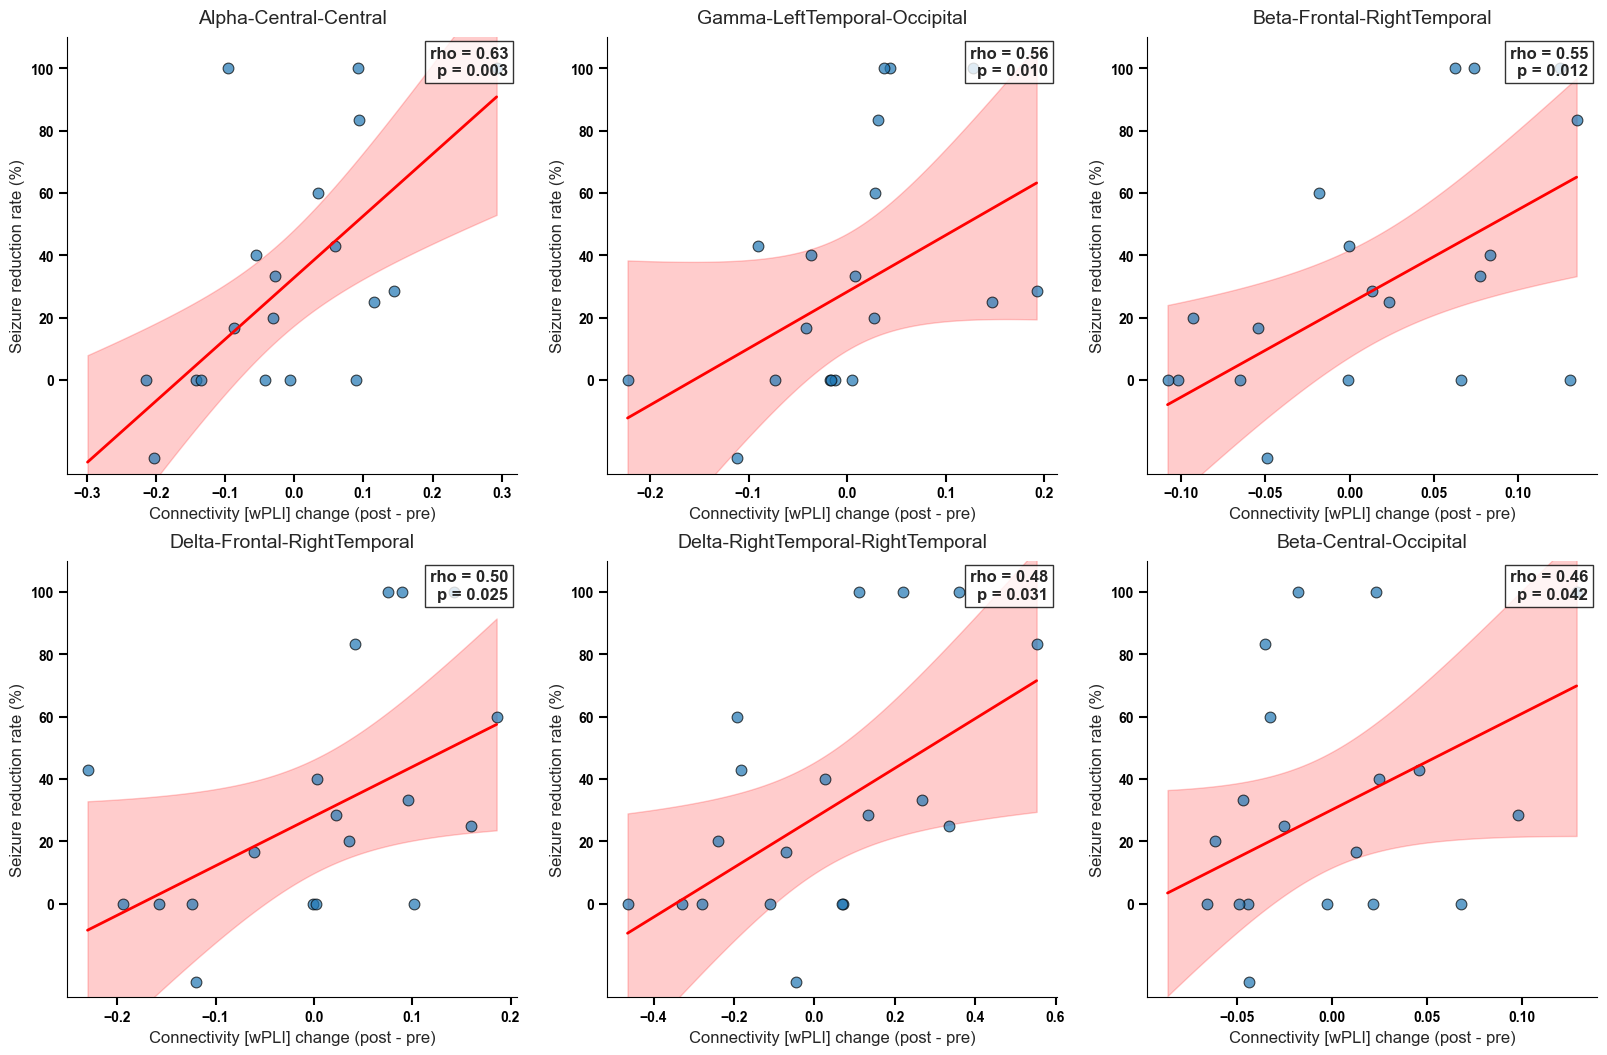

Saved correlation plots to fcd_roi_corrplot.eps

Analysis complete!

Significant correlations found:
         connection          band  correlation  p_value
      Alpha-Central       Central     0.625022 0.003213
 Gamma-LeftTemporal     Occipital     0.563969 0.009598
       Beta-Frontal RightTemporal     0.550233 0.011946
      Delta-Frontal RightTemporal     0.499865 0.024815
Delta-RightTemporal RightTemporal     0.482312 0.031263
       Beta-Central     Occipital     0.459418 0.041567


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings('ignore')

def load_and_filter_fcd_data():
    df = pd.read_csv('data_for_ROI.csv')
    fcd_df = df[df['etiology'].str.lower() == 'fcd'].copy()
    
    print(f"Total patients: {len(df)}")
    print(f"FCD patients: {len(fcd_df)}")
    
    if fcd_df.empty:
        print("No FCD patients found in the dataset.")
        return None
    
    return fcd_df

def analyze_correlations(df):
    pre_cols = [col for col in df.columns if col.startswith('pre_')]
    results = []
    
    for pre_col in pre_cols:
        suffix = pre_col[4:]
        post_col = 'post_' + suffix
        
        if post_col not in df.columns:
            continue
        
        diff_col = 'diff_' + suffix
        df[diff_col] = df[post_col] - df[pre_col]
        
        valid_idx = df[['seizure_diff', diff_col]].dropna().index
        if len(valid_idx) < 3:
            continue
            
        rho, p_value = stats.spearmanr(df.loc[valid_idx, 'seizure_diff'], df.loc[valid_idx, diff_col])
        
        parts = suffix.split('-')
        if len(parts) >= 3:
            region1 = parts[0]
            region2 = parts[1]
            band = parts[-1]
            connection = f"{region1}-{region2}"
        else:
            connection = "Unknown"
            band = "Unknown"
        
        results.append({
            'connection': connection,
            'band': band,
            'variable': diff_col,
            'correlation': rho,
            'p_value': p_value,
            'n': len(valid_idx)
        })
    
    results_df = pd.DataFrame(results)
    results_df['significant'] = results_df['p_value'] < 0.05
    results_df['abs_corr'] = results_df['correlation'].abs()
    results_df = results_df.sort_values('abs_corr', ascending=False)
    
    return results_df

def plot_significant_correlations(df, results_df, output_file='fcd_roi_corrplot.eps'):
    significant = results_df[results_df['significant']].copy()

    if significant.empty:
        print("No significant correlations found for FCD patients.")
        return

    n_plots = len(significant)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.ravel()

    for i, (_, row) in enumerate(significant.iterrows()):
        ax = axes[i]
        var_name = row['variable']
        clean_var_name = var_name.replace('diff_', '')

        x = df[var_name]
        y = df['seizure_diff']
        x_pred = np.linspace(x.min(), x.max(), 100)
        
        x_with_const = sm.add_constant(x)
        model = sm.OLS(y, x_with_const).fit()
        x_pred_with_const = sm.add_constant(x_pred)
        y_pred = model.predict(x_pred_with_const)
        
        pred_summary = model.get_prediction(x_pred_with_const).summary_frame(alpha=0.05)
        ci_lower = pred_summary['mean_ci_lower']
        ci_upper = pred_summary['mean_ci_upper']

        # ✅ 먼저 CI shaded area (가장 뒤쪽으로 먼저 그리기)
        ax.fill_between(x_pred, ci_lower, ci_upper, color='red', alpha=0.2, zorder=1)

        # Scatter plot (앞쪽)
        ax.scatter(x, y, s=60, alpha=0.7, edgecolors='black', linewidths=0.8, zorder=3)

        # Regression line (앞쪽)
        ax.plot(x_pred, y_pred, 'r-', lw=2, zorder=4)

        # Labels and title
        ax.set_title(clean_var_name, fontsize=14, fontname='Arial', pad=10)
        ax.set_xlabel('Connectivity [wPLI] change (post - pre)', fontsize=12, fontname='Arial')
        ax.set_ylabel('Seizure reduction rate (%)', fontsize=12, fontname='Arial')

        ax.set_ylim(-30, 110)
        ax.set_yticks(np.linspace(0, 100, 6))

        stats_text = f"rho = {row['correlation']:.2f}\np = {row['p_value']:.3f}"
        ax.text(
            0.98, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=12,
            fontname='Arial',
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3', alpha=0.8)
        )

        # ✅ Tick 및 축 설정 (검정색, 바깥쪽, 길이 강조)
        ax.tick_params(axis='both', which='both', direction='out', length=6, width=1.5, colors='black')
        ax.tick_params(axis='both', which='minor', direction='out', length=4, width=1, colors='black')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # ✅ 상단, 오른쪽 테두리 제거
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')

        ax.grid(False)

    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved correlation plots to {output_file}")

def save_significant_results(results_df, output_file='fcd_significant_correlations.csv'):
    significant = results_df[results_df['significant']].copy()
    if significant.empty:
        print("No significant correlations to save.")
        return
    
    output_df = significant[['connection', 'band', 'correlation', 'p_value', 'n']]
    output_df.columns = ['Connection', 'Frequency Band', 'Correlation (rho)', 'p-value', 'N']
    output_df['Correlation (rho)'] = output_df['Correlation (rho)'].round(3)
    output_df['p-value'] = output_df['p-value'].apply(lambda x: f"{x:.3f}")
    output_df.to_csv(output_file, index=False)
    print(f"Saved significant correlations to {output_file}")

def main():
    print("Loading and filtering data for FCD patients...")
    fcd_df = load_and_filter_fcd_data()
    if fcd_df is None or fcd_df.empty:
        return
    
    print("Analyzing correlations...")
    results_df = analyze_correlations(fcd_df)
    save_significant_results(results_df)
    
    print("Creating correlation plots...")
    plot_significant_correlations(fcd_df, results_df)
    
    print("\nAnalysis complete!")
    if not results_df[results_df['significant']].empty:
        print("\nSignificant correlations found:")
        print(results_df[results_df['significant']][['connection', 'band', 'correlation', 'p_value']].to_string(index=False))
    else:
        print("\nNo significant correlations found.")

if __name__ == "__main__":
    main()


Loaded data: data_for_GM.csv, N=39


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


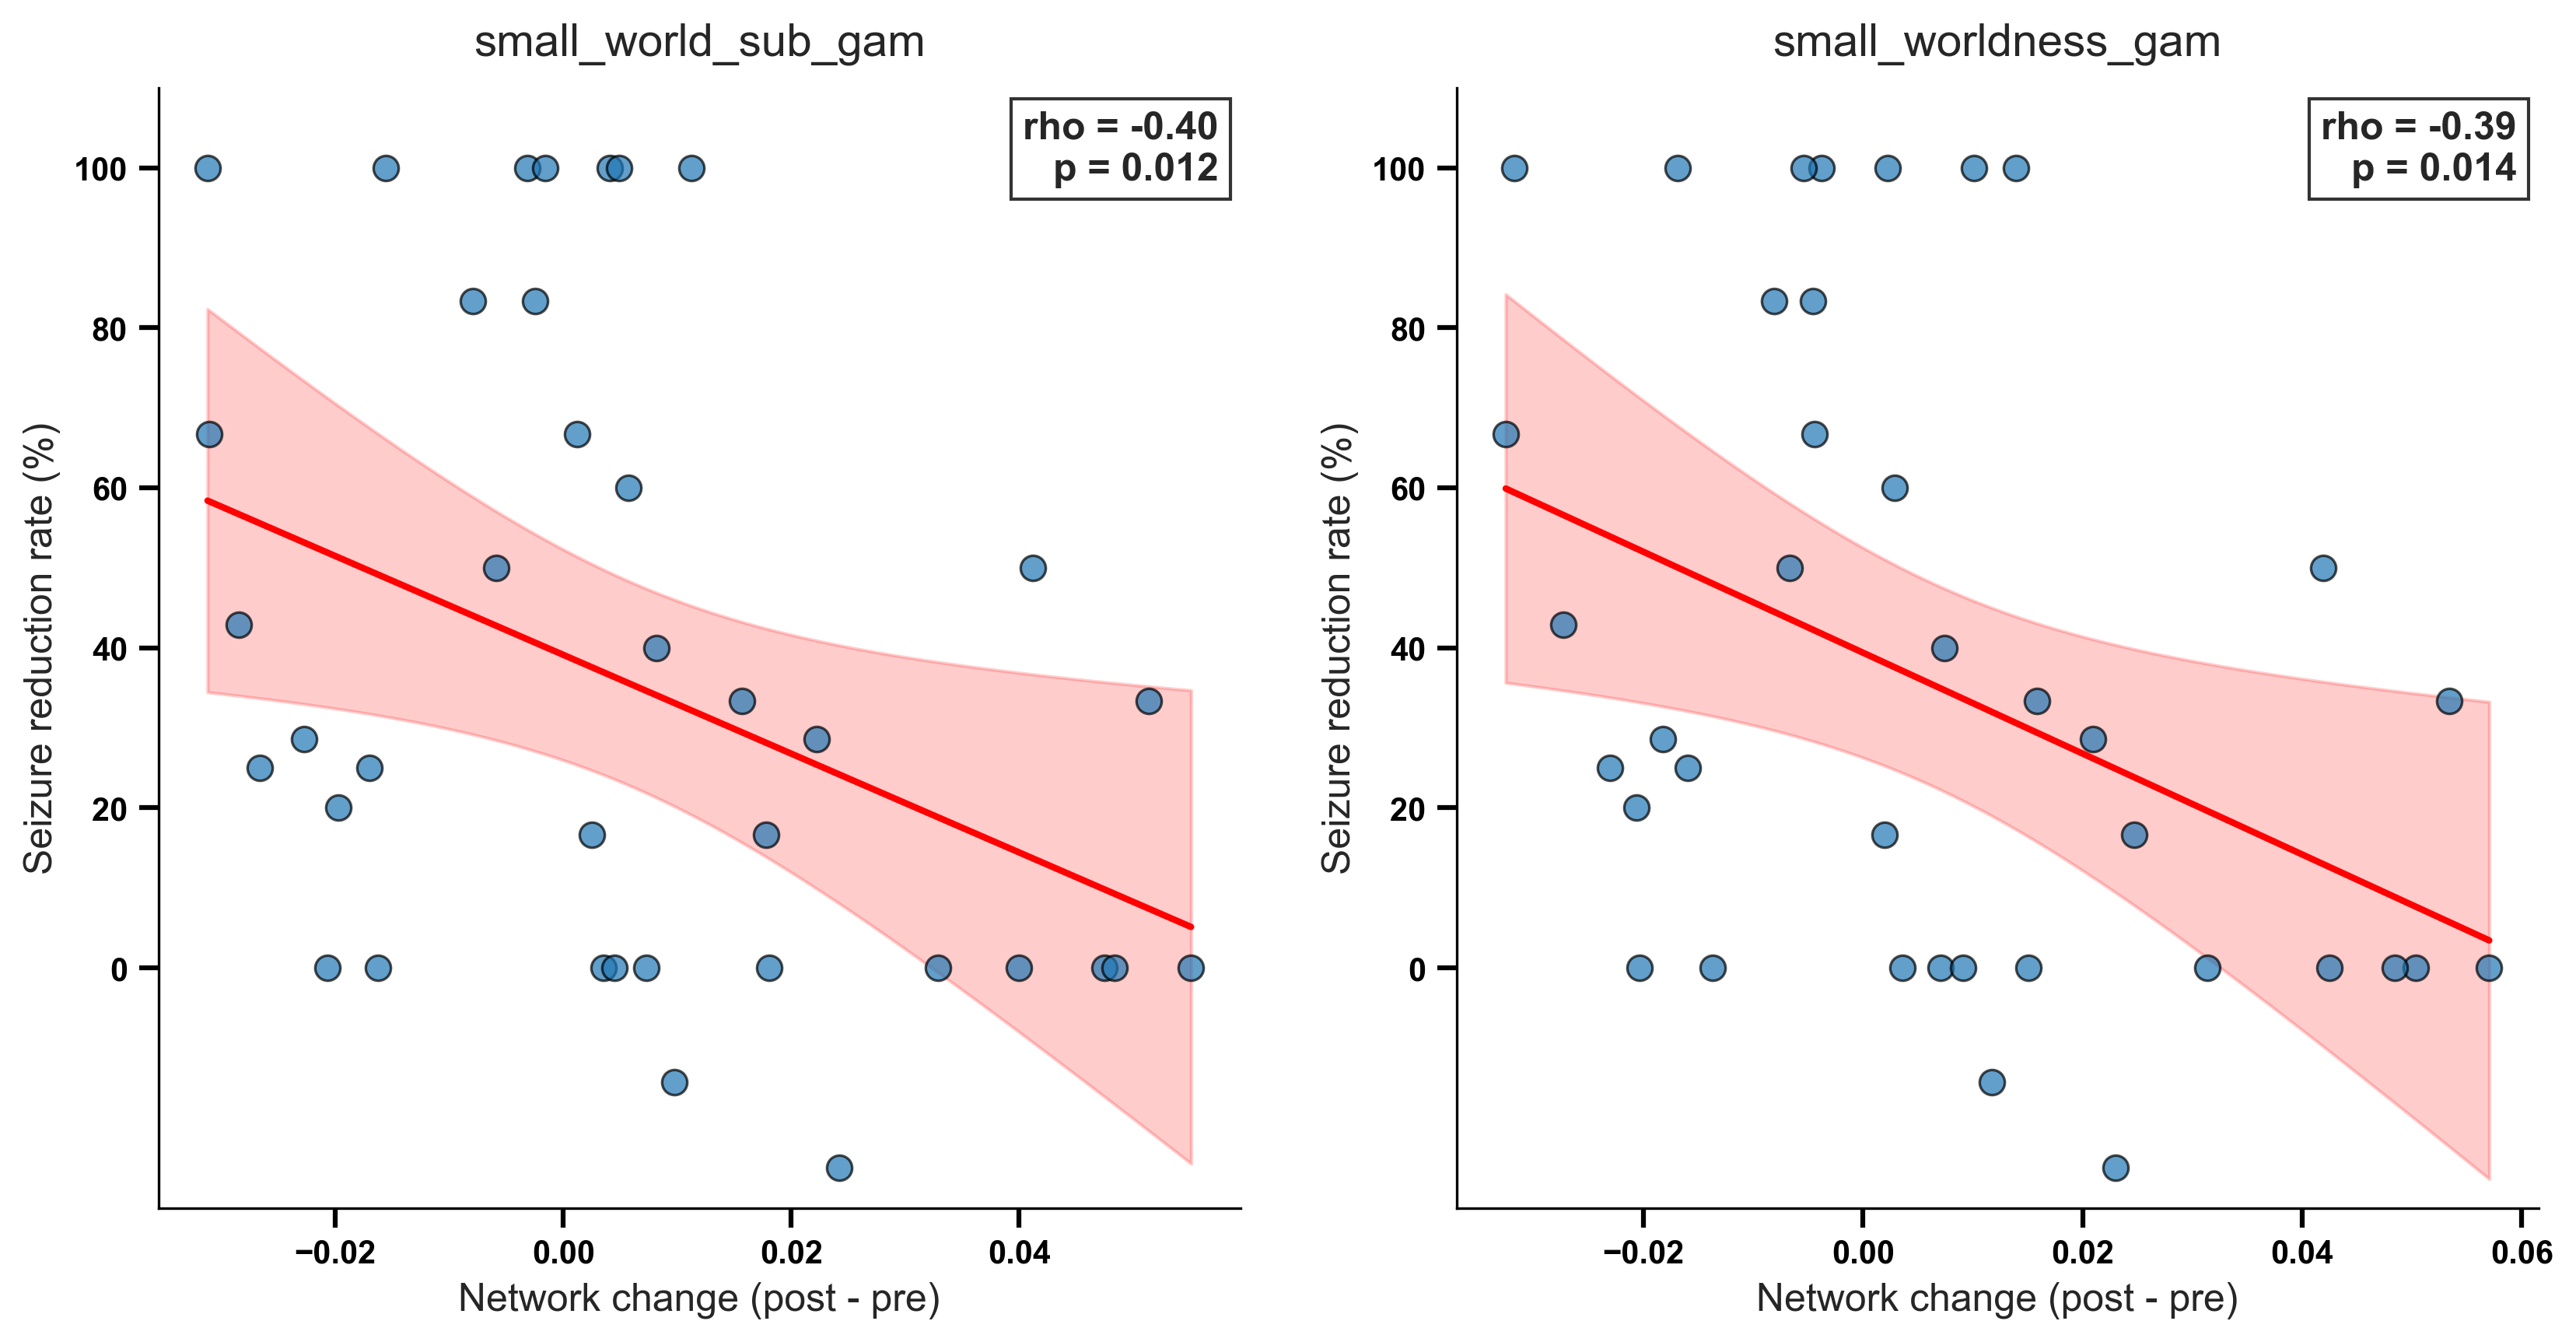

Saved plot: GM_all_all_corrplot.eps
Saved docx: GM_all_all_correlations.docx


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


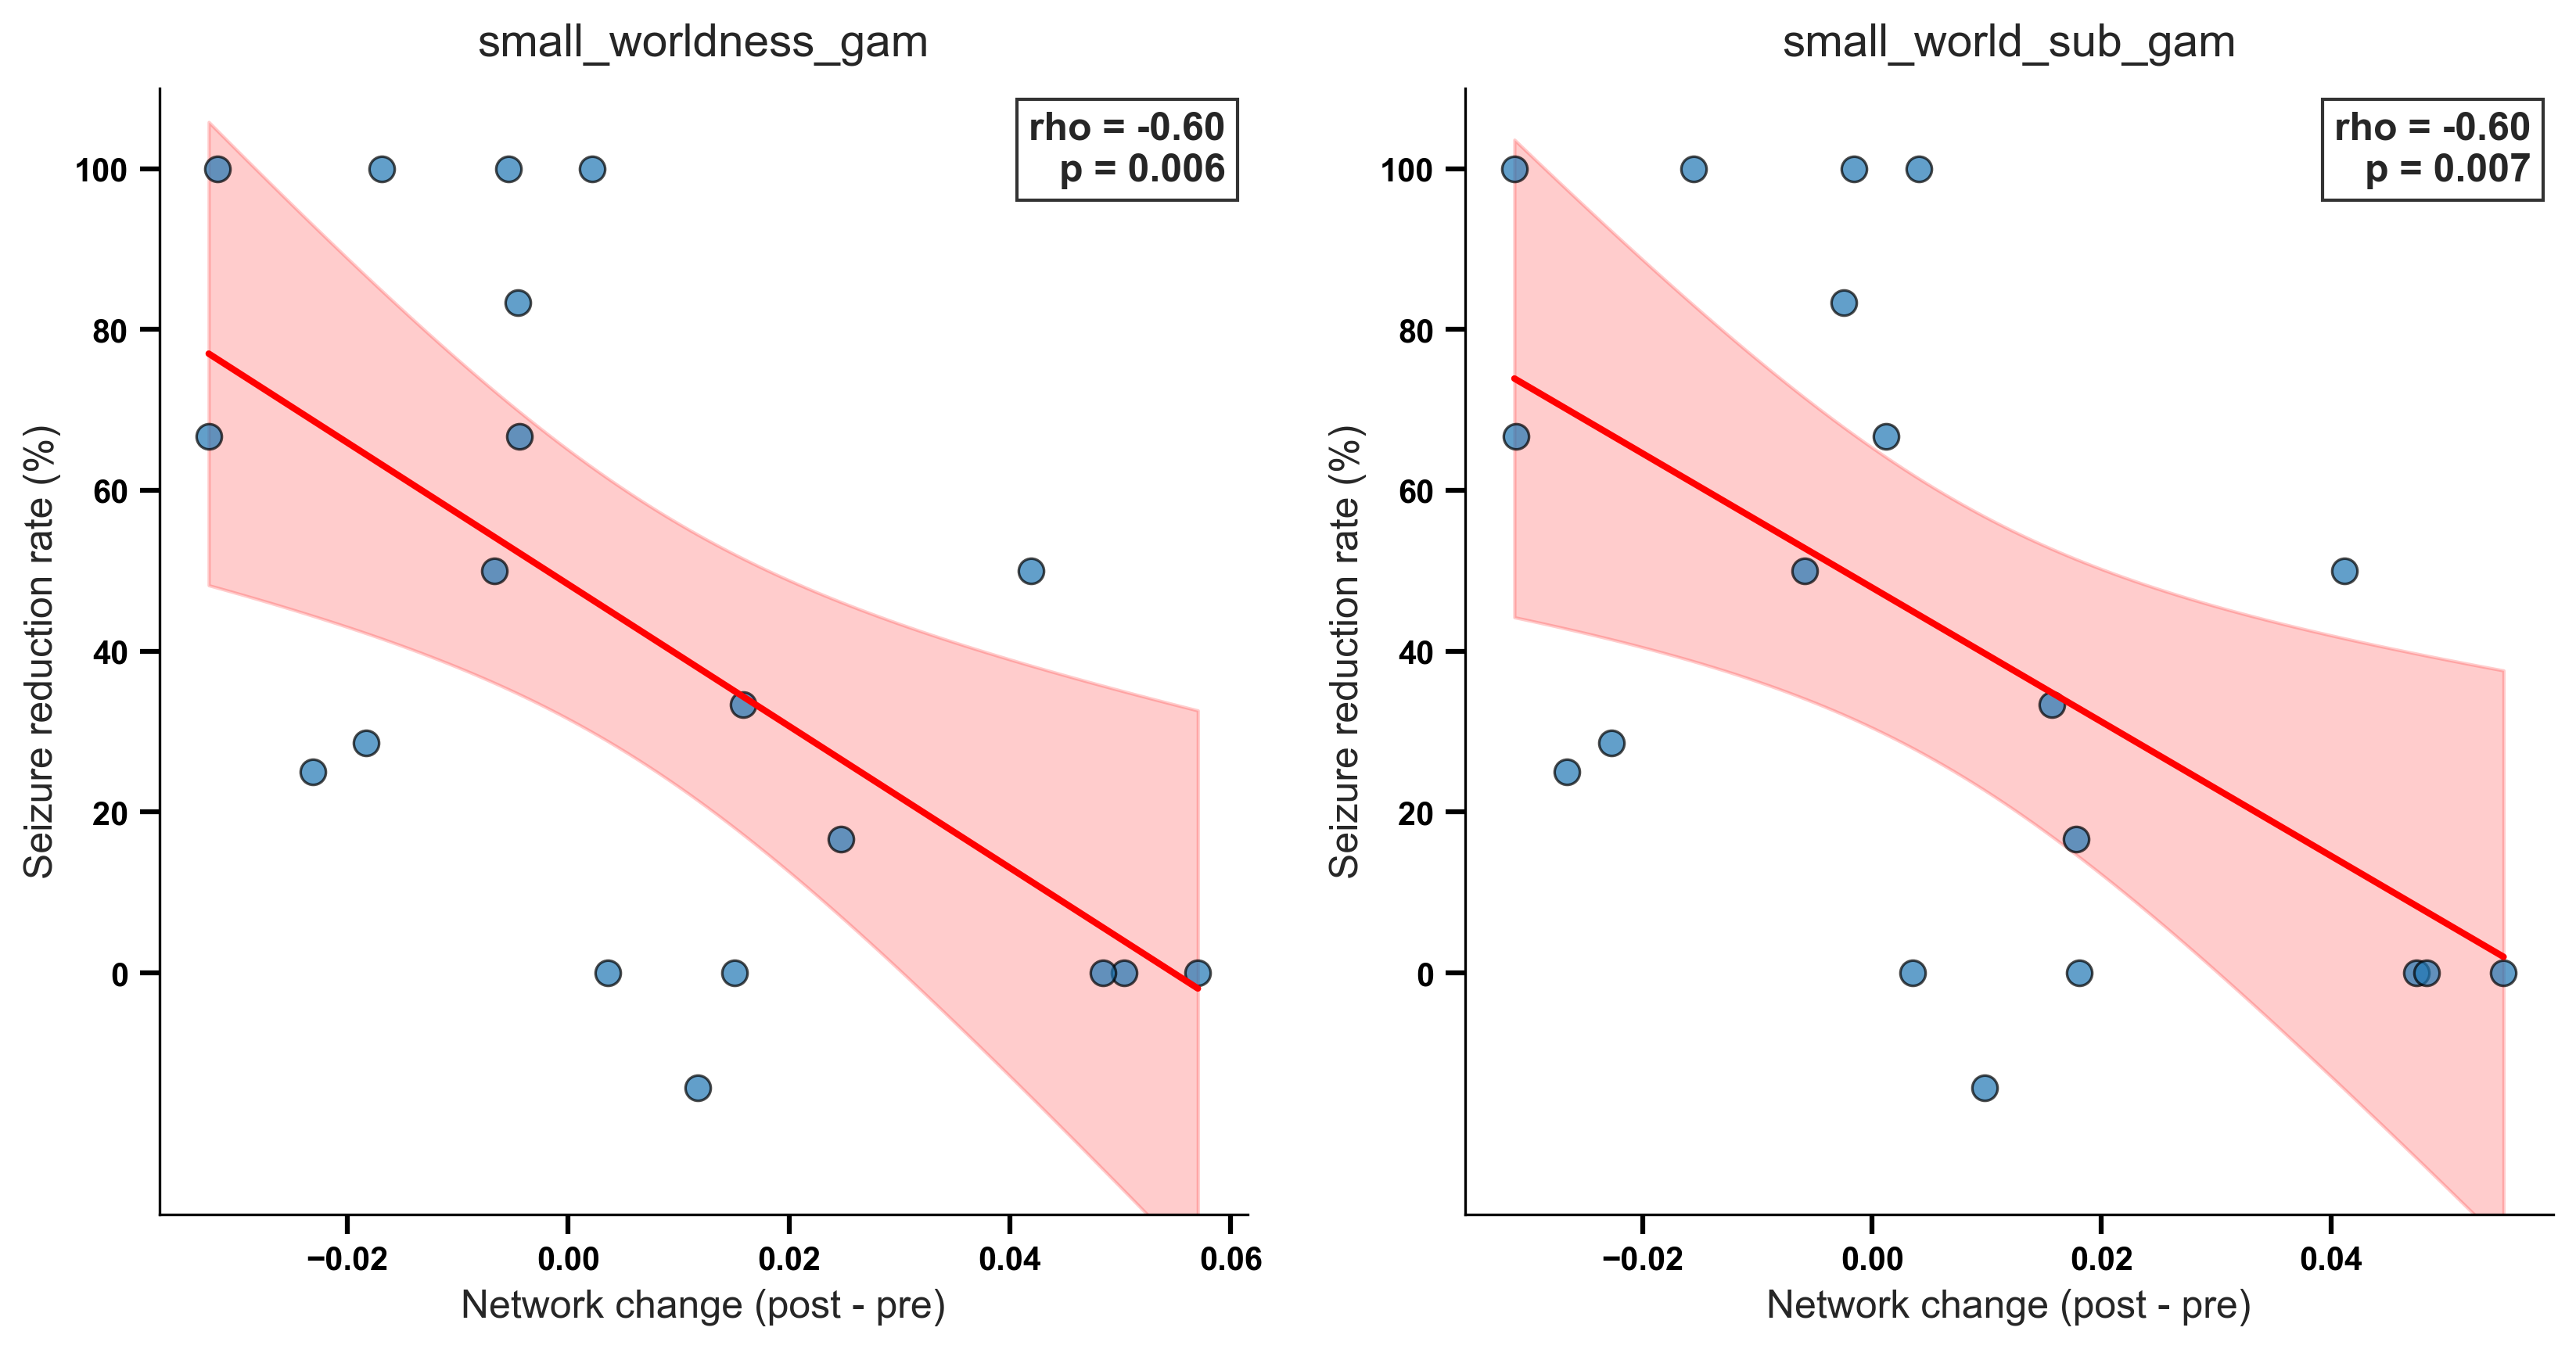

Saved plot: GM_TLE_TLE_corrplot.eps
Saved docx: GM_TLE_TLE_correlations.docx


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


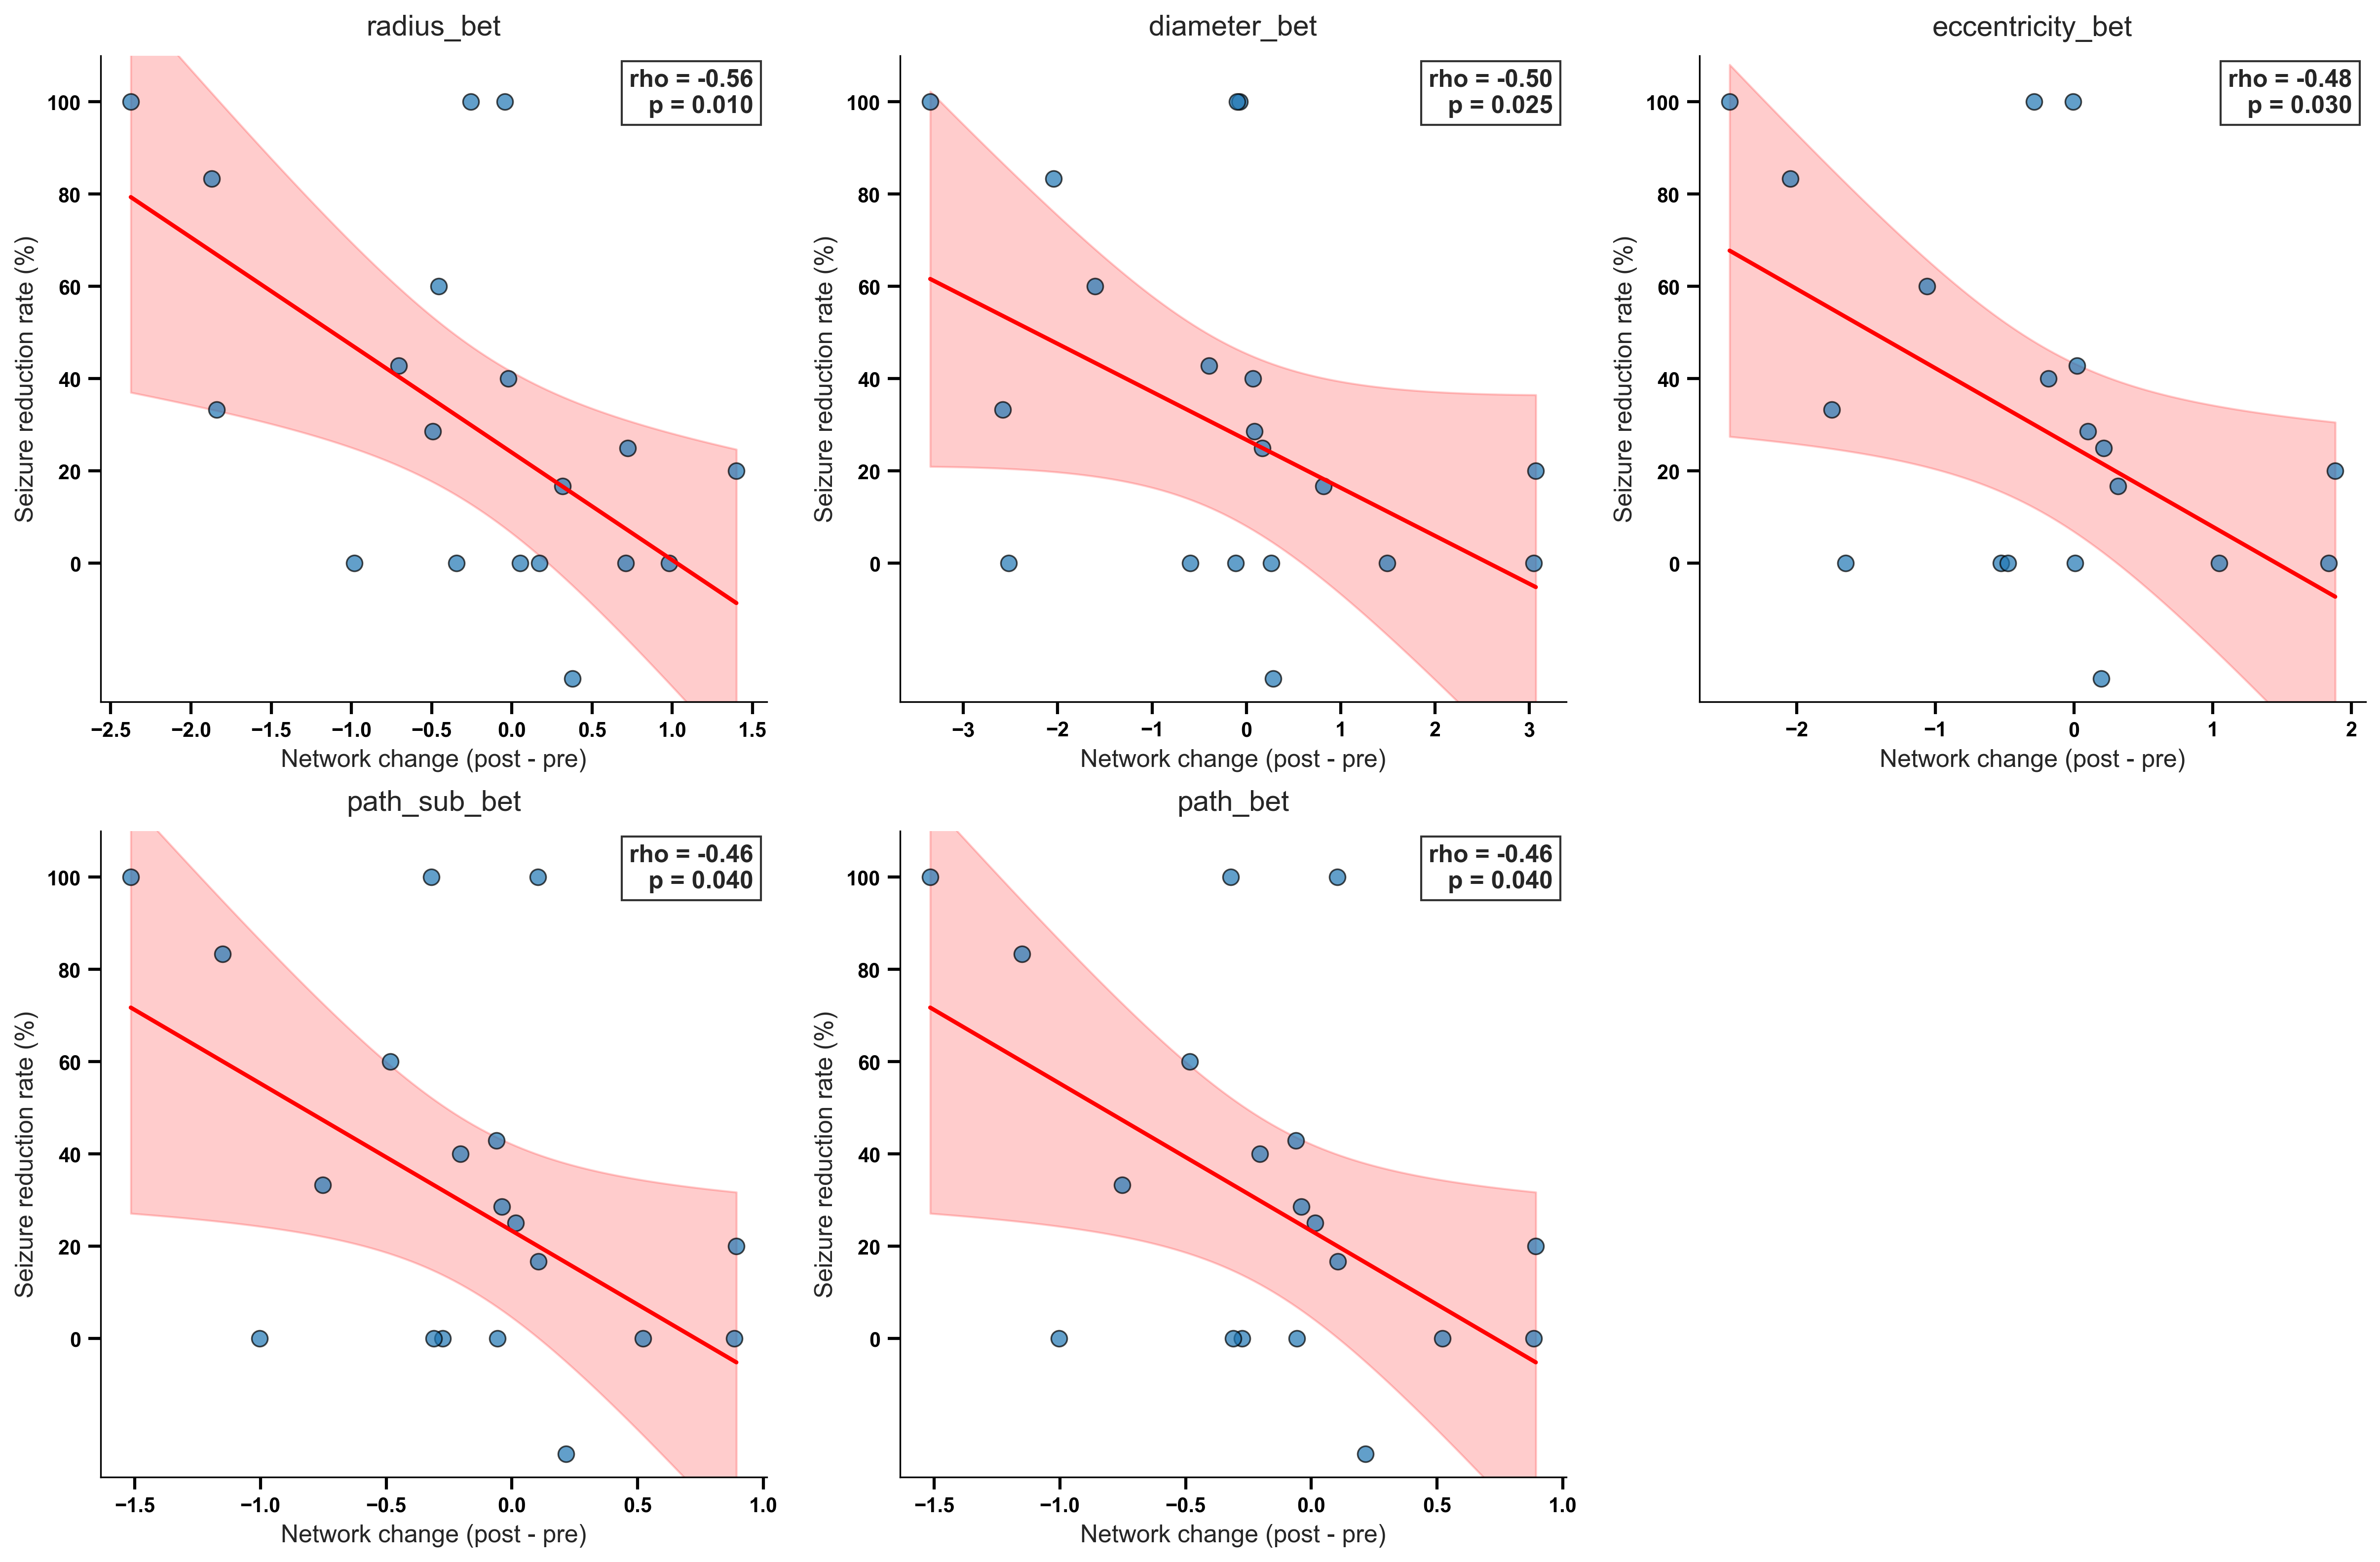

Saved plot: GM_FCD_FCD_corrplot.eps
Saved docx: GM_FCD_FCD_correlations.docx
완료!


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from docx import Document
import os
import warnings
warnings.filterwarnings('ignore')

def analyze_and_plot(df, group_name, plot_prefix, docx_prefix):
    import statsmodels.api as sm

    results = []
    pre_cols = [col for col in df.columns if col.startswith('pre_')]
    for pre_col in pre_cols:
        suffix = pre_col[4:]
        post_col = 'post_' + suffix
        if post_col not in df.columns:
            continue
        diff_col = 'diff_' + suffix
        df[diff_col] = df[post_col] - df[pre_col]
        valid_idx = df[['seizure_diff', diff_col]].dropna().index
        if len(valid_idx) < 3:
            continue
        rho, p_value = stats.spearmanr(df.loc[valid_idx, 'seizure_diff'], df.loc[valid_idx, diff_col])
        results.append({
            'Variable': diff_col,
            'Correlation (rho)': rho,
            'p-value': p_value,
            'N': len(valid_idx)
        })

    results_df = pd.DataFrame(results)
    results_df['significant'] = results_df['p-value'] < 0.05
    results_df = results_df.sort_values('Correlation (rho)', key=np.abs, ascending=False)

    sig = results_df[results_df['significant']]
    if not sig.empty:
        n_plots = len(sig)
        n_cols = min(3, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), dpi=300)
        if n_plots == 1:
            axes = np.array([axes])
        axes = axes.ravel()
        for i, (_, row) in enumerate(sig.iterrows()):
            ax = axes[i]
            var = row['Variable']
            x = df[var]
            y = df['seizure_diff']
            x_pred = np.linspace(x.min(), x.max(), 100)
            x_with_const = sm.add_constant(x)
            model = sm.OLS(y, x_with_const).fit()
            x_pred_with_const = sm.add_constant(x_pred)
            y_pred = model.predict(x_pred_with_const)
            pred_summary = model.get_prediction(x_pred_with_const).summary_frame(alpha=0.05)
            ci_lower = pred_summary['mean_ci_lower']
            ci_upper = pred_summary['mean_ci_upper']

            # Shaded area (뒤에)
            ax.fill_between(x_pred, ci_lower, ci_upper, color='red', alpha=0.2, zorder=1)

            # Scatter (앞쪽)
            ax.scatter(x, y, s=60, alpha=0.7, edgecolors='black', linewidths=0.8, zorder=3)

            # Regression line (더 두껍게)
            ax.plot(x_pred, y_pred, color='red', lw=2, zorder=4)

            clean_var = var.replace('diff_', '')
            ax.set_title(clean_var, fontsize=14, fontname='Arial', pad=10)
            ax.set_xlabel('Network change (post - pre)', fontsize=12, fontname='Arial')
            ax.set_ylabel('Seizure reduction rate (%)', fontsize=12, fontname='Arial')
            ax.set_ylim(-30, 110)
            ax.set_yticks(np.linspace(0, 100, 6))

            stats_text = f"rho = {row['Correlation (rho)']:.2f}\np = {row['p-value']:.3f}"
            ax.text(
                0.98, 0.98, stats_text,
                transform=ax.transAxes,
                fontsize=12,
                fontname='Arial',
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3', alpha=0.8)
            )

            # Tick 및 스파인 처리
            ax.tick_params(axis='both', which='both', direction='out', length=6, width=1.5, colors='black')
            ax.tick_params(axis='both', which='minor', direction='out', length=4, width=1, colors='black')
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.grid(False)

        for i in range(n_plots, len(axes)):
            fig.delaxes(axes[i])
        plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
        plot_file = f"{plot_prefix}_{group_name}_corrplot.eps"
        plt.savefig(plot_file, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Saved plot: {plot_file}")
    else:
        print(f"No significant correlations found for {group_name}.")

    # docx 저장
    doc = Document()
    doc.add_heading(f'Significant Correlations ({group_name})', 0)
    if not sig.empty:
        table = doc.add_table(rows=1, cols=len(sig.columns))
        hdr_cells = table.rows[0].cells
        for j, col in enumerate(sig.columns):
            hdr_cells[j].text = col
        for _, row in sig.iterrows():
            row_cells = table.add_row().cells
            for j, col in enumerate(sig.columns):
                row_cells[j].text = str(row[col])
    else:
        doc.add_paragraph("No significant correlations found.")
    docx_file = f"{docx_prefix}_{group_name}_correlations.docx"
    doc.save(docx_file)
    print(f"Saved docx: {docx_file}")

def main():
    # 파일 경로
    data_path = 'data_for_GM.csv'
    df = pd.read_csv(data_path)
    print(f"Loaded data: {data_path}, N={len(df)}")

    # 전체
    analyze_and_plot(df, group_name='all', plot_prefix='GM_all', docx_prefix='GM_all')

    # TLE
    tle_df = df[df['etiology'].str.strip().str.lower() == 'tle']
    analyze_and_plot(tle_df, group_name='TLE', plot_prefix='GM_TLE', docx_prefix='GM_TLE')

    # FCD
    fcd_df = df[df['etiology'].str.strip().str.lower() == 'fcd']
    analyze_and_plot(fcd_df, group_name='FCD', plot_prefix='GM_FCD', docx_prefix='GM_FCD')

    print("완료!")

if __name__ == "__main__":
    main()

Loading and filtering data for TLE patients...
Total patients: 39
TLE patients: 19
Analyzing correlations...
Saved significant correlations to TLE_significant_correlations.csv
Creating correlation plots...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


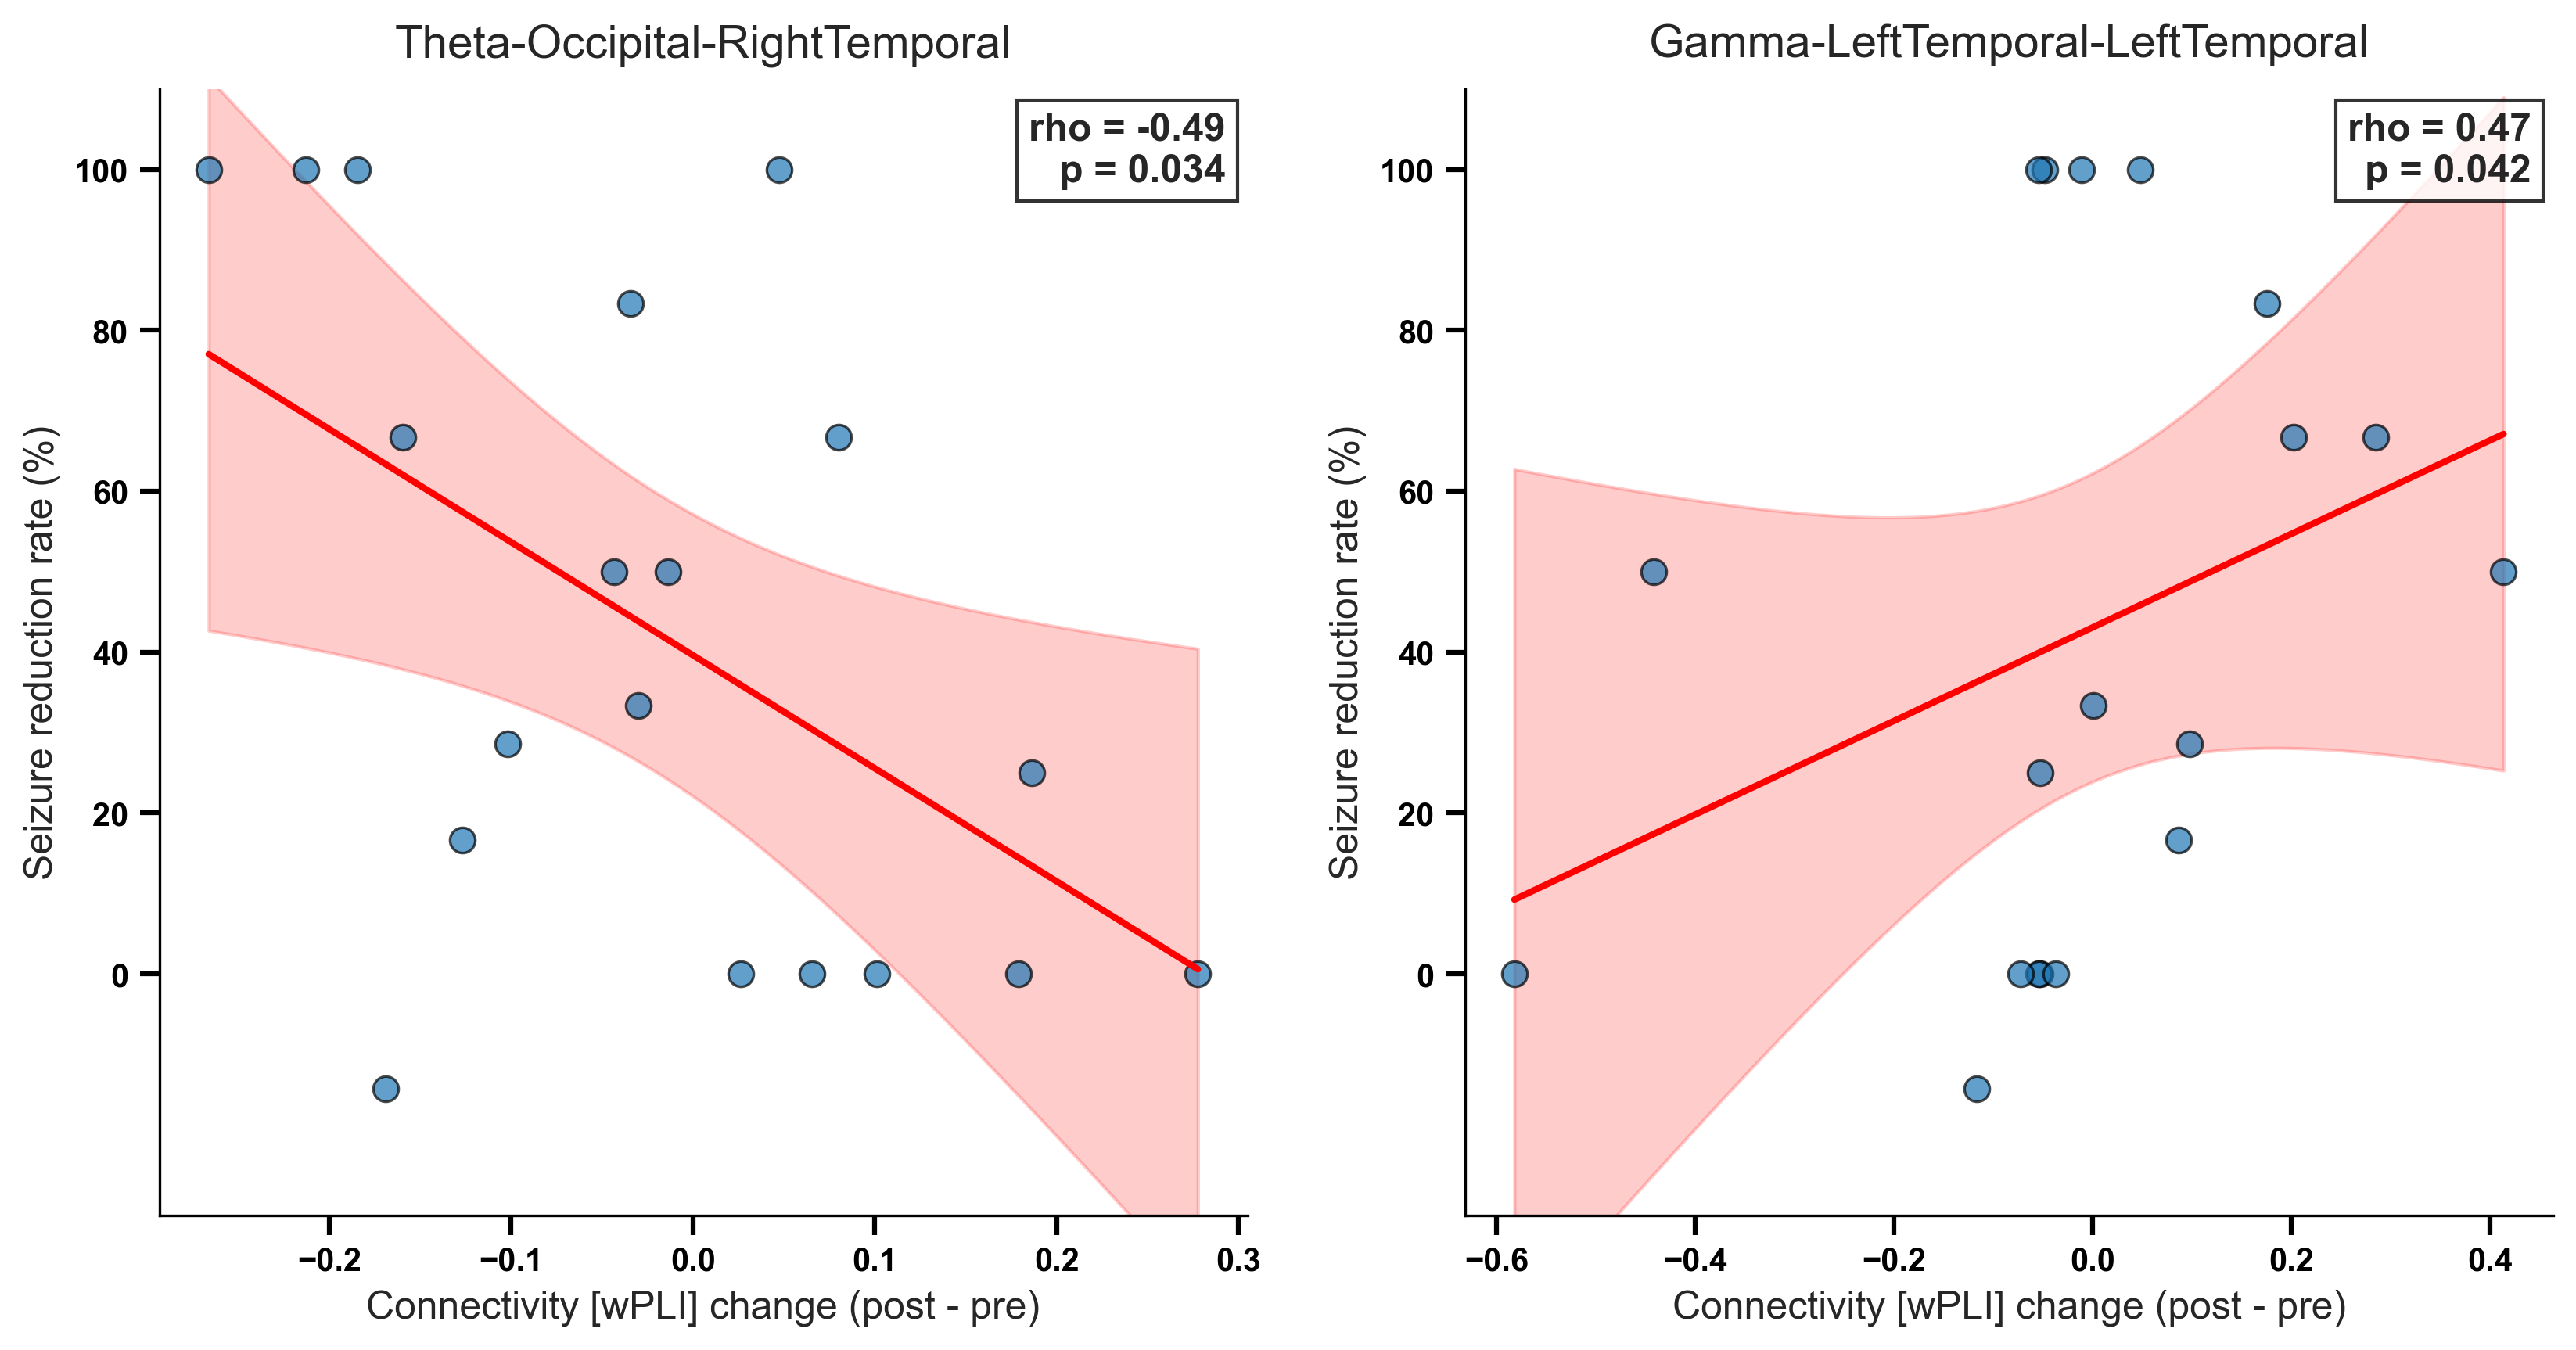

Saved correlation plots to TLE_roi_corrplot.eps

Analysis complete!

Significant correlations found:
        connection          band  correlation  p_value
   Theta-Occipital RightTemporal    -0.487374 0.034297
Gamma-LeftTemporal  LeftTemporal     0.471365 0.041624


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

def load_and_filter_fcd_data():
    """Load the data and filter for FCD patients."""
    # Load the data
    df = pd.read_csv('data_for_ROI.csv')
    
    # Filter for FCD patients (case-insensitive check)
    fcd_df = df[df['etiology'].str.lower() == 'tle'].copy()
    
    print(f"Total patients: {len(df)}")
    print(f"TLE patients: {len(fcd_df)}")
    
    if fcd_df.empty:
        print("No TLE patients found in the dataset.")
        return None
    
    return fcd_df

def analyze_correlations(df):
    """Analyze correlations between connectivity changes and seizure frequency."""
    # Get all pre_ and post_ columns
    pre_cols = [col for col in df.columns if col.startswith('pre_')]
    
    # Create a list to store results
    results = []
    
    # For each pre_ column, find corresponding post_ column
    for pre_col in pre_cols:
        # Extract the part after 'pre_'
        suffix = pre_col[4:]
        post_col = 'post_' + suffix
        
        if post_col not in df.columns:
            continue
        
        # Calculate post - pre difference
        diff_col = 'diff_' + suffix
        df[diff_col] = df[post_col] - df[pre_col]
        
        # Calculate correlation with seizure_diff
        valid_idx = df[['seizure_diff', diff_col]].dropna().index
        if len(valid_idx) < 3:  # Need at least 3 points for correlation
            continue
            
        rho, p_value = stats.spearmanr(df.loc[valid_idx, 'seizure_diff'], 
                                      df.loc[valid_idx, diff_col])
        
        # Parse region and band information
        parts = suffix.split('-')
        if len(parts) >= 3:  # Format: Region1-Region2-Band or similar
            region1 = parts[0]
            region2 = parts[1]
            band = parts[-1]
            connection = f"{region1}-{region2}"
        else:
            connection = "Unknown"
            band = "Unknown"
        
        results.append({
            'connection': connection,
            'band': band,
            'variable': diff_col,
            'correlation': rho,
            'p_value': p_value,
            'n': len(valid_idx)
        })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Add significance flag
    results_df['significant'] = results_df['p_value'] < 0.05
    
    # Sort by absolute correlation strength
    results_df['abs_corr'] = results_df['correlation'].abs()
    results_df = results_df.sort_values('abs_corr', ascending=False)
    
    return results_df
def plot_significant_correlations(df, results_df, output_file='TLE_roi_corrplot.eps'):
    import statsmodels.api as sm

    significant = results_df[results_df['significant']].copy()
    if significant.empty:
        print("No significant correlations found for TLE patients.")
        return

    n_plots = len(significant)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), dpi=300)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.ravel()

    for i, (_, row) in enumerate(significant.iterrows()):
        ax = axes[i]
        var_name = row['variable']
        clean_var_name = var_name.replace('diff_', '')

        x = df[var_name]
        y = df['seizure_diff']
        x_pred = np.linspace(x.min(), x.max(), 100)
        x_with_const = sm.add_constant(x)
        model = sm.OLS(y, x_with_const).fit()
        x_pred_with_const = sm.add_constant(x_pred)
        y_pred = model.predict(x_pred_with_const)
        pred_summary = model.get_prediction(x_pred_with_const).summary_frame(alpha=0.05)
        ci_lower = pred_summary['mean_ci_lower']
        ci_upper = pred_summary['mean_ci_upper']

        # CI area
        ax.fill_between(x_pred, ci_lower, ci_upper, color='red', alpha=0.2, zorder=1)

        # Scatter
        ax.scatter(x, y, s=60, alpha=0.7, edgecolors='black', linewidths=0.8, zorder=3)

        # Regression line
        ax.plot(x_pred, y_pred, color='red', lw=2, zorder=4)

        # Title
        ax.set_title(clean_var_name, fontsize=14, fontname='Arial', pad=10)

        # Labels
        ax.set_xlabel('Connectivity [wPLI] change (post - pre)', fontsize=12, fontname='Arial')
        ax.set_ylabel('Seizure reduction rate (%)', fontsize=12, fontname='Arial')

        # Y axis
        ax.set_ylim(-30, 110)
        ax.set_yticks(np.linspace(0, 100, 6))

        # Stats box
        stats_text = f"rho = {row['correlation']:.2f}\np = {row['p_value']:.3f}"
        ax.text(
            0.98, 0.98, stats_text,
            transform=ax.transAxes,
            fontsize=12,
            fontname='Arial',
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.3', alpha=0.8)
        )

        # Tick & spines
        ax.tick_params(axis='both', which='both', direction='out', length=6, width=1.5, colors='black')
        ax.tick_params(axis='both', which='minor', direction='out', length=4, width=1, colors='black')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.grid(False)

    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved correlation plots to {output_file}")


def save_significant_results(results_df, output_file='TLE_significant_correlations.csv'):
    """Save significant results to a CSV file."""
    significant = results_df[results_df['significant']].copy()
    
    if significant.empty:
        print("No significant correlations to save.")
        return
    
    # Format the output
    output_df = significant[[
        'connection', 'band', 'correlation', 'p_value', 'n'
    ]]
    output_df.columns = ['Connection', 'Frequency Band', 'Correlation (rho)', 'p-value', 'N']
    
    # Format numbers
    output_df['Correlation (rho)'] = output_df['Correlation (rho)'].round(3)
    output_df['p-value'] = output_df['p-value'].apply(lambda x: f"{x:.3f}")
    
    # Save to CSV
    output_df.to_csv(output_file, index=False)
    print(f"Saved significant correlations to {output_file}")

def main():
    # Load and filter data for FCD patients
    print("Loading and filtering data for TLE patients...")
    fcd_df = load_and_filter_fcd_data()
    
    if fcd_df is None or fcd_df.empty:
        return
    
    # Analyze correlations
    print("Analyzing correlations...")
    results_df = analyze_correlations(fcd_df)
    
    # Save significant results
    save_significant_results(results_df)
    
    # Create and save plots
    print("Creating correlation plots...")
    plot_significant_correlations(fcd_df, results_df)
    
    print("\nAnalysis complete!")
    if not results_df[results_df['significant']].empty:
        print("\nSignificant correlations found:")
        print(results_df[results_df['significant']][['connection', 'band', 'correlation', 'p_value']].to_string(index=False))
    else:
        print("\nNo significant correlations found.")

if __name__ == "__main__":
    main()

# Logistic Regression - Responder Prediction


🔍 Analyzing: Responsiveness_0


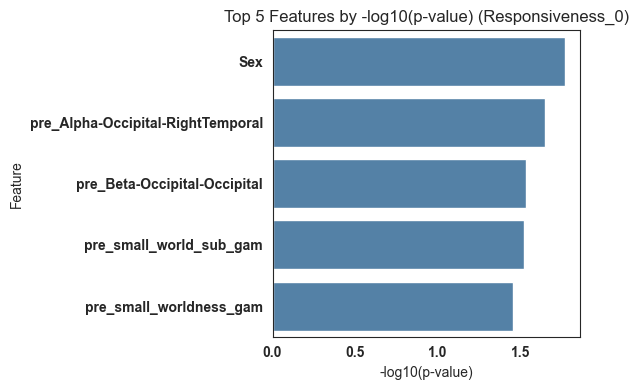

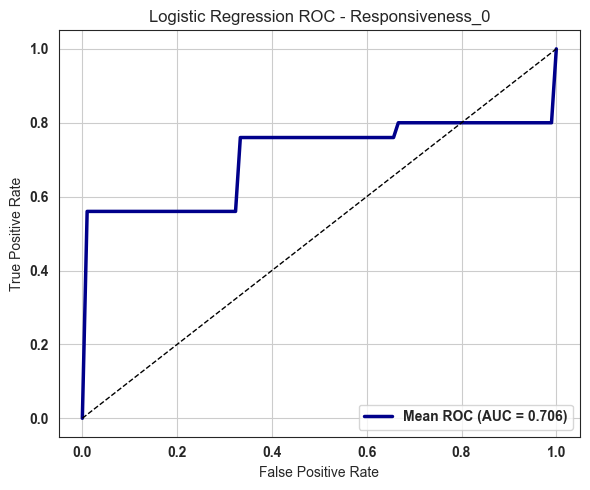


🔍 Analyzing: Responsiveness_30


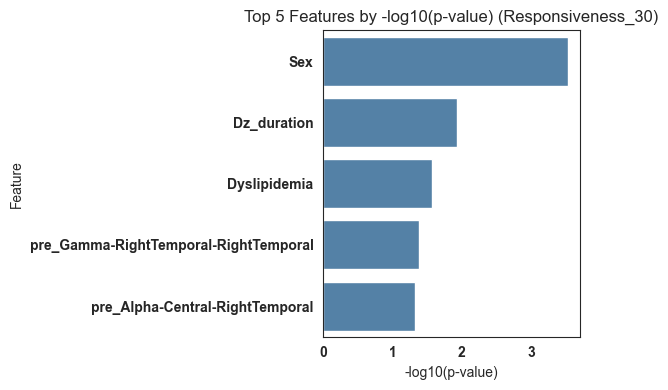

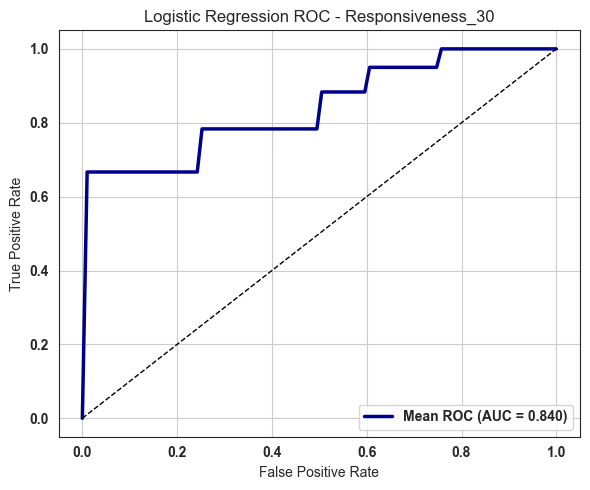


🔍 Analyzing: Responsiveness_50


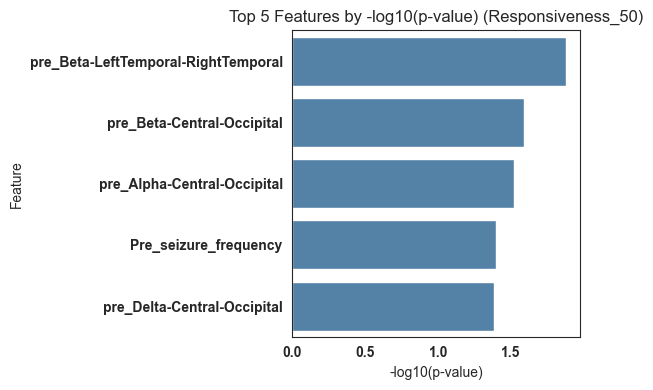

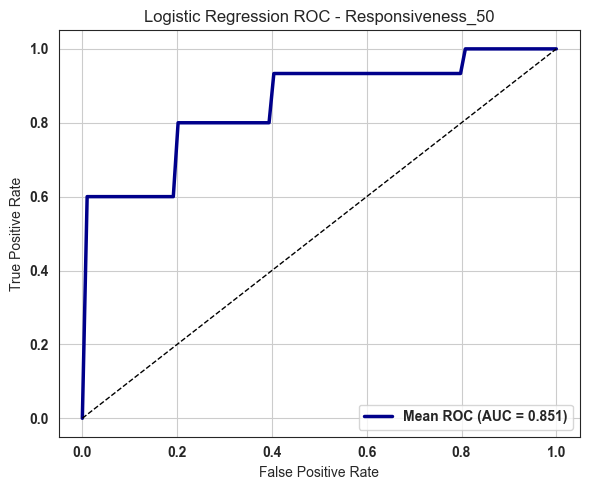


🔍 Analyzing: Responsiveness_100


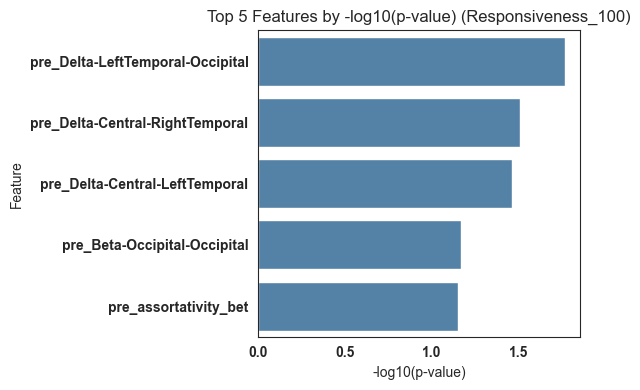

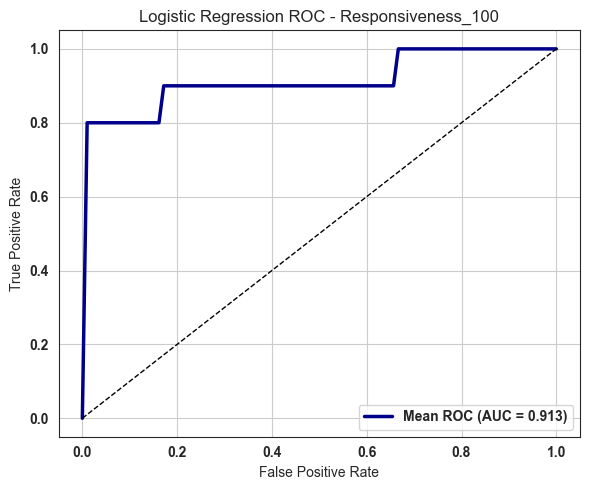

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import f_classif

# 데이터 로드
df = pd.read_csv("data_for_area_analysis_processed (1st+2nd experiment, GM, AREA).csv")

# CV 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# 경고 제거 및 기능 강화된 분석 함수
def analyze_and_plot(df, target_col):
    y = df[target_col].astype(int).values

    # 유효 feature만 추출
    valid_features = [col for col in df.columns
                      if col not in ['No', 'ID', 'Group_class', 'Experiment', 'MMSE', 'etiology']
                      and not col.lower().startswith('post')
                      and 'diff' not in col.lower()
                      and not col.startswith('Responsiveness')]

    X_valid = df[valid_features]

    # constant feature 제거 (분산=0)
    X_valid = X_valid.loc[:, X_valid.nunique() > 1].dropna()

    # f-test 기반 p-value 계산
    f_vals, p_vals = f_classif(X_valid, y)
    pval_df = pd.DataFrame({
        'Feature': X_valid.columns,
        'F-value': f_vals,
        'p-value': p_vals
    }).sort_values(by='p-value', ascending=True).reset_index(drop=True)

    # 상위 5개 feature 추출
    top5 = pval_df.head(5)
    top5_features = top5['Feature'].tolist()
    X_top5 = df[top5_features]
    X_top5_scaled = StandardScaler().fit_transform(X_top5)

    # bar plot (p-value 대신 -log10(p-value))
    top5_plot = top5.copy()
    top5_plot['-log10(p)'] = -np.log10(top5_plot['p-value'])

    plt.figure(figsize=(6, 4))
    sns.barplot(y=top5_plot['Feature'], x=top5_plot['-log10(p)'], color='steelblue')
    plt.title(f"Top 5 Features by -log10(p-value) ({target_col})")
    plt.xlabel("-log10(p-value)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Logistic Regression ROC (평균 ROC 곡선만)
    model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_idx, test_idx in cv.split(X_top5_scaled, y):
        model.fit(X_top5_scaled[train_idx], y[train_idx])
        y_score = model.predict_proba(X_top5_scaled[test_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y[test_idx], y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr, mean_tpr, color='darkblue',
             label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2.5)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Logistic Regression ROC - {target_col}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return top5_plot

# 실행
targets = ['Responsiveness_0', 'Responsiveness_30', 'Responsiveness_50', 'Responsiveness_100']
pval_results = {}

for target in targets:
    print(f"\n🔍 Analyzing: {target}")
    pval_results[target] = analyze_and_plot(df, target)


# Logistic Regression - Stimulation Setting Prediction


🔍 Analyzing Stim prediction within: Responsiveness_0


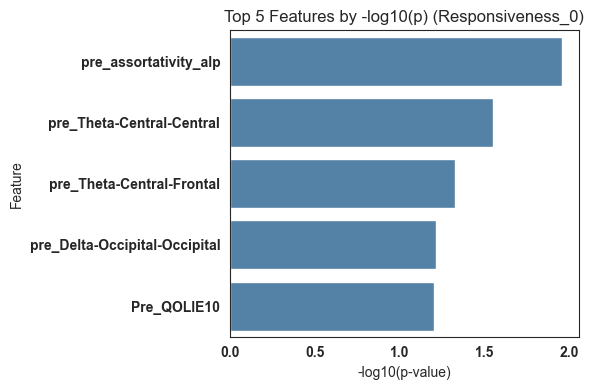

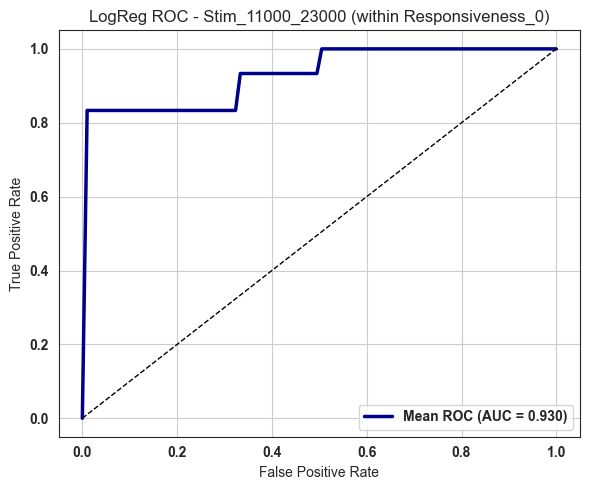


🔍 Analyzing Stim prediction within: Responsiveness_30


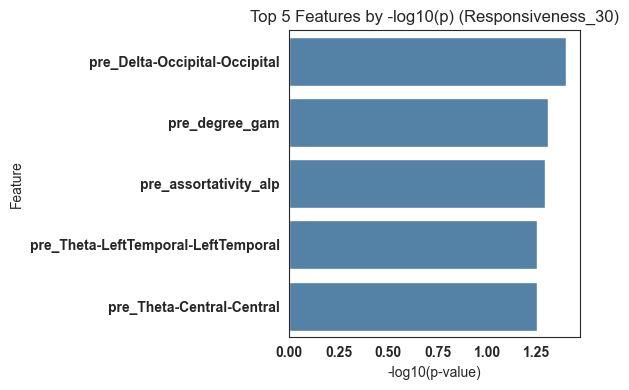

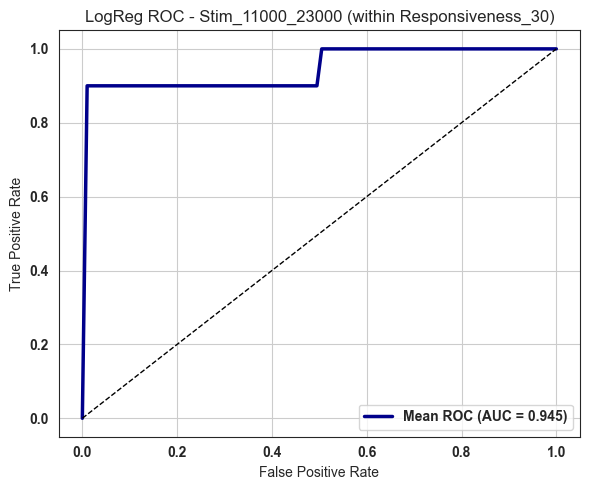


🔍 Analyzing Stim prediction within: Responsiveness_50


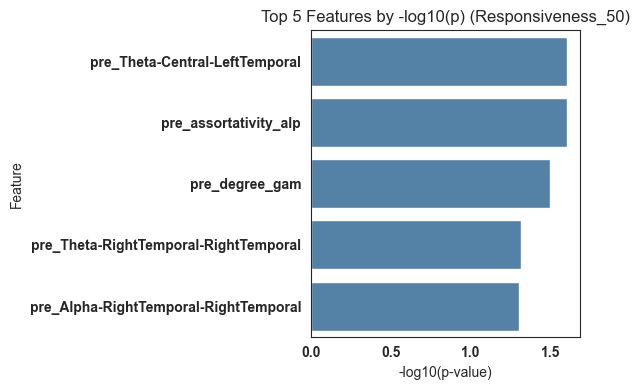

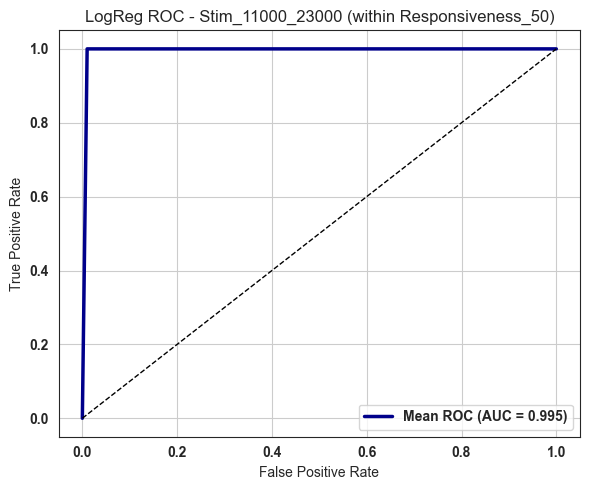


🔍 Analyzing Stim prediction within: Responsiveness_100


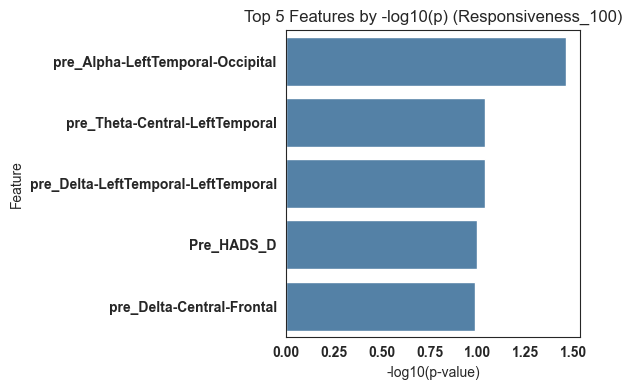

c:\Users\kyt34\anaconda3\envs\torch_book\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\kyt34\anaconda3\envs\torch_book\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\kyt34\anaconda3\envs\torch_book\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\kyt34\anaconda3\envs\torch_book\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


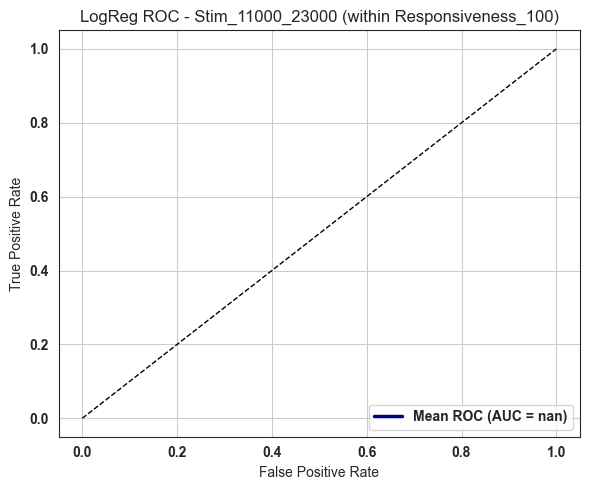

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import f_classif

# 데이터 로드
df = pd.read_csv("data_for_area_analysis_processed (1st+2nd experiment, GM, AREA).csv")

# CV 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 새로운 분석 함수 (subgroup 내 Stim 비교)
def analyze_stim_prediction_within_subgroup(df, subgroup_col):
    # 해당 subgroup 필터링
    df_sub = df[df[subgroup_col] == 1].copy()
    
    # Stim 값 1과 2만 필터링 (이진 분류)
    df_sub = df_sub[df_sub['Stim_11000_23000'].isin([1, 2])]
    
    # 타겟 변수
    y = (df_sub['Stim_11000_23000'] == 2).astype(int).values

    # 유효 feature 필터링
    valid_features = [col for col in df_sub.columns
                      if col not in ['No', 'ID', 'Group_class', 'Experiment', 'MMSE', 'etiology',
                                     'Stim_11000_23000'] + [f'Responsiveness_{i}' for i in [0, 30, 50, 100]]
                      and not col.lower().startswith('post')
                      and 'diff' not in col.lower()]

    X_valid = df_sub[valid_features]

    # constant feature 제거
    X_valid = X_valid.loc[:, X_valid.nunique() > 1].dropna()

    # f-test (1 vs 2)
    f_vals, p_vals = f_classif(X_valid, y)
    pval_df = pd.DataFrame({
        'Feature': X_valid.columns,
        'F-value': f_vals,
        'p-value': p_vals
    }).sort_values(by='p-value', ascending=True).reset_index(drop=True)

    # 상위 5개 feature
    top5 = pval_df.head(5)
    top5_features = top5['Feature'].tolist()
    X_top5 = df_sub[top5_features]
    X_top5_scaled = StandardScaler().fit_transform(X_top5)

    # bar plot (-log10(p-value))
    top5_plot = top5.copy()
    top5_plot['-log10(p)'] = -np.log10(top5_plot['p-value'])

    plt.figure(figsize=(6, 4))
    sns.barplot(y=top5_plot['Feature'], x=top5_plot['-log10(p)'], color='steelblue')
    plt.title(f"Top 5 Features by -log10(p) ({subgroup_col})")
    plt.xlabel("-log10(p-value)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # ROC curve (mean only)
    model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_idx, test_idx in cv.split(X_top5_scaled, y):
        model.fit(X_top5_scaled[train_idx], y[train_idx])
        y_score = model.predict_proba(X_top5_scaled[test_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y[test_idx], y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(mean_fpr, mean_tpr, color='darkblue',
             label=f'Mean ROC (AUC = {mean_auc:.3f})', lw=2.5)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'LogReg ROC - Stim_11000_23000 (within {subgroup_col})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return top5_plot

# 실행
subgroups = ['Responsiveness_0', 'Responsiveness_30', 'Responsiveness_50', 'Responsiveness_100']
stim_results = {}

for subgroup in subgroups:
    print(f"\n🔍 Analyzing Stim prediction within: {subgroup}")
    stim_results[subgroup] = analyze_stim_prediction_within_subgroup(df, subgroup)


# ROI-subgroup Analysis

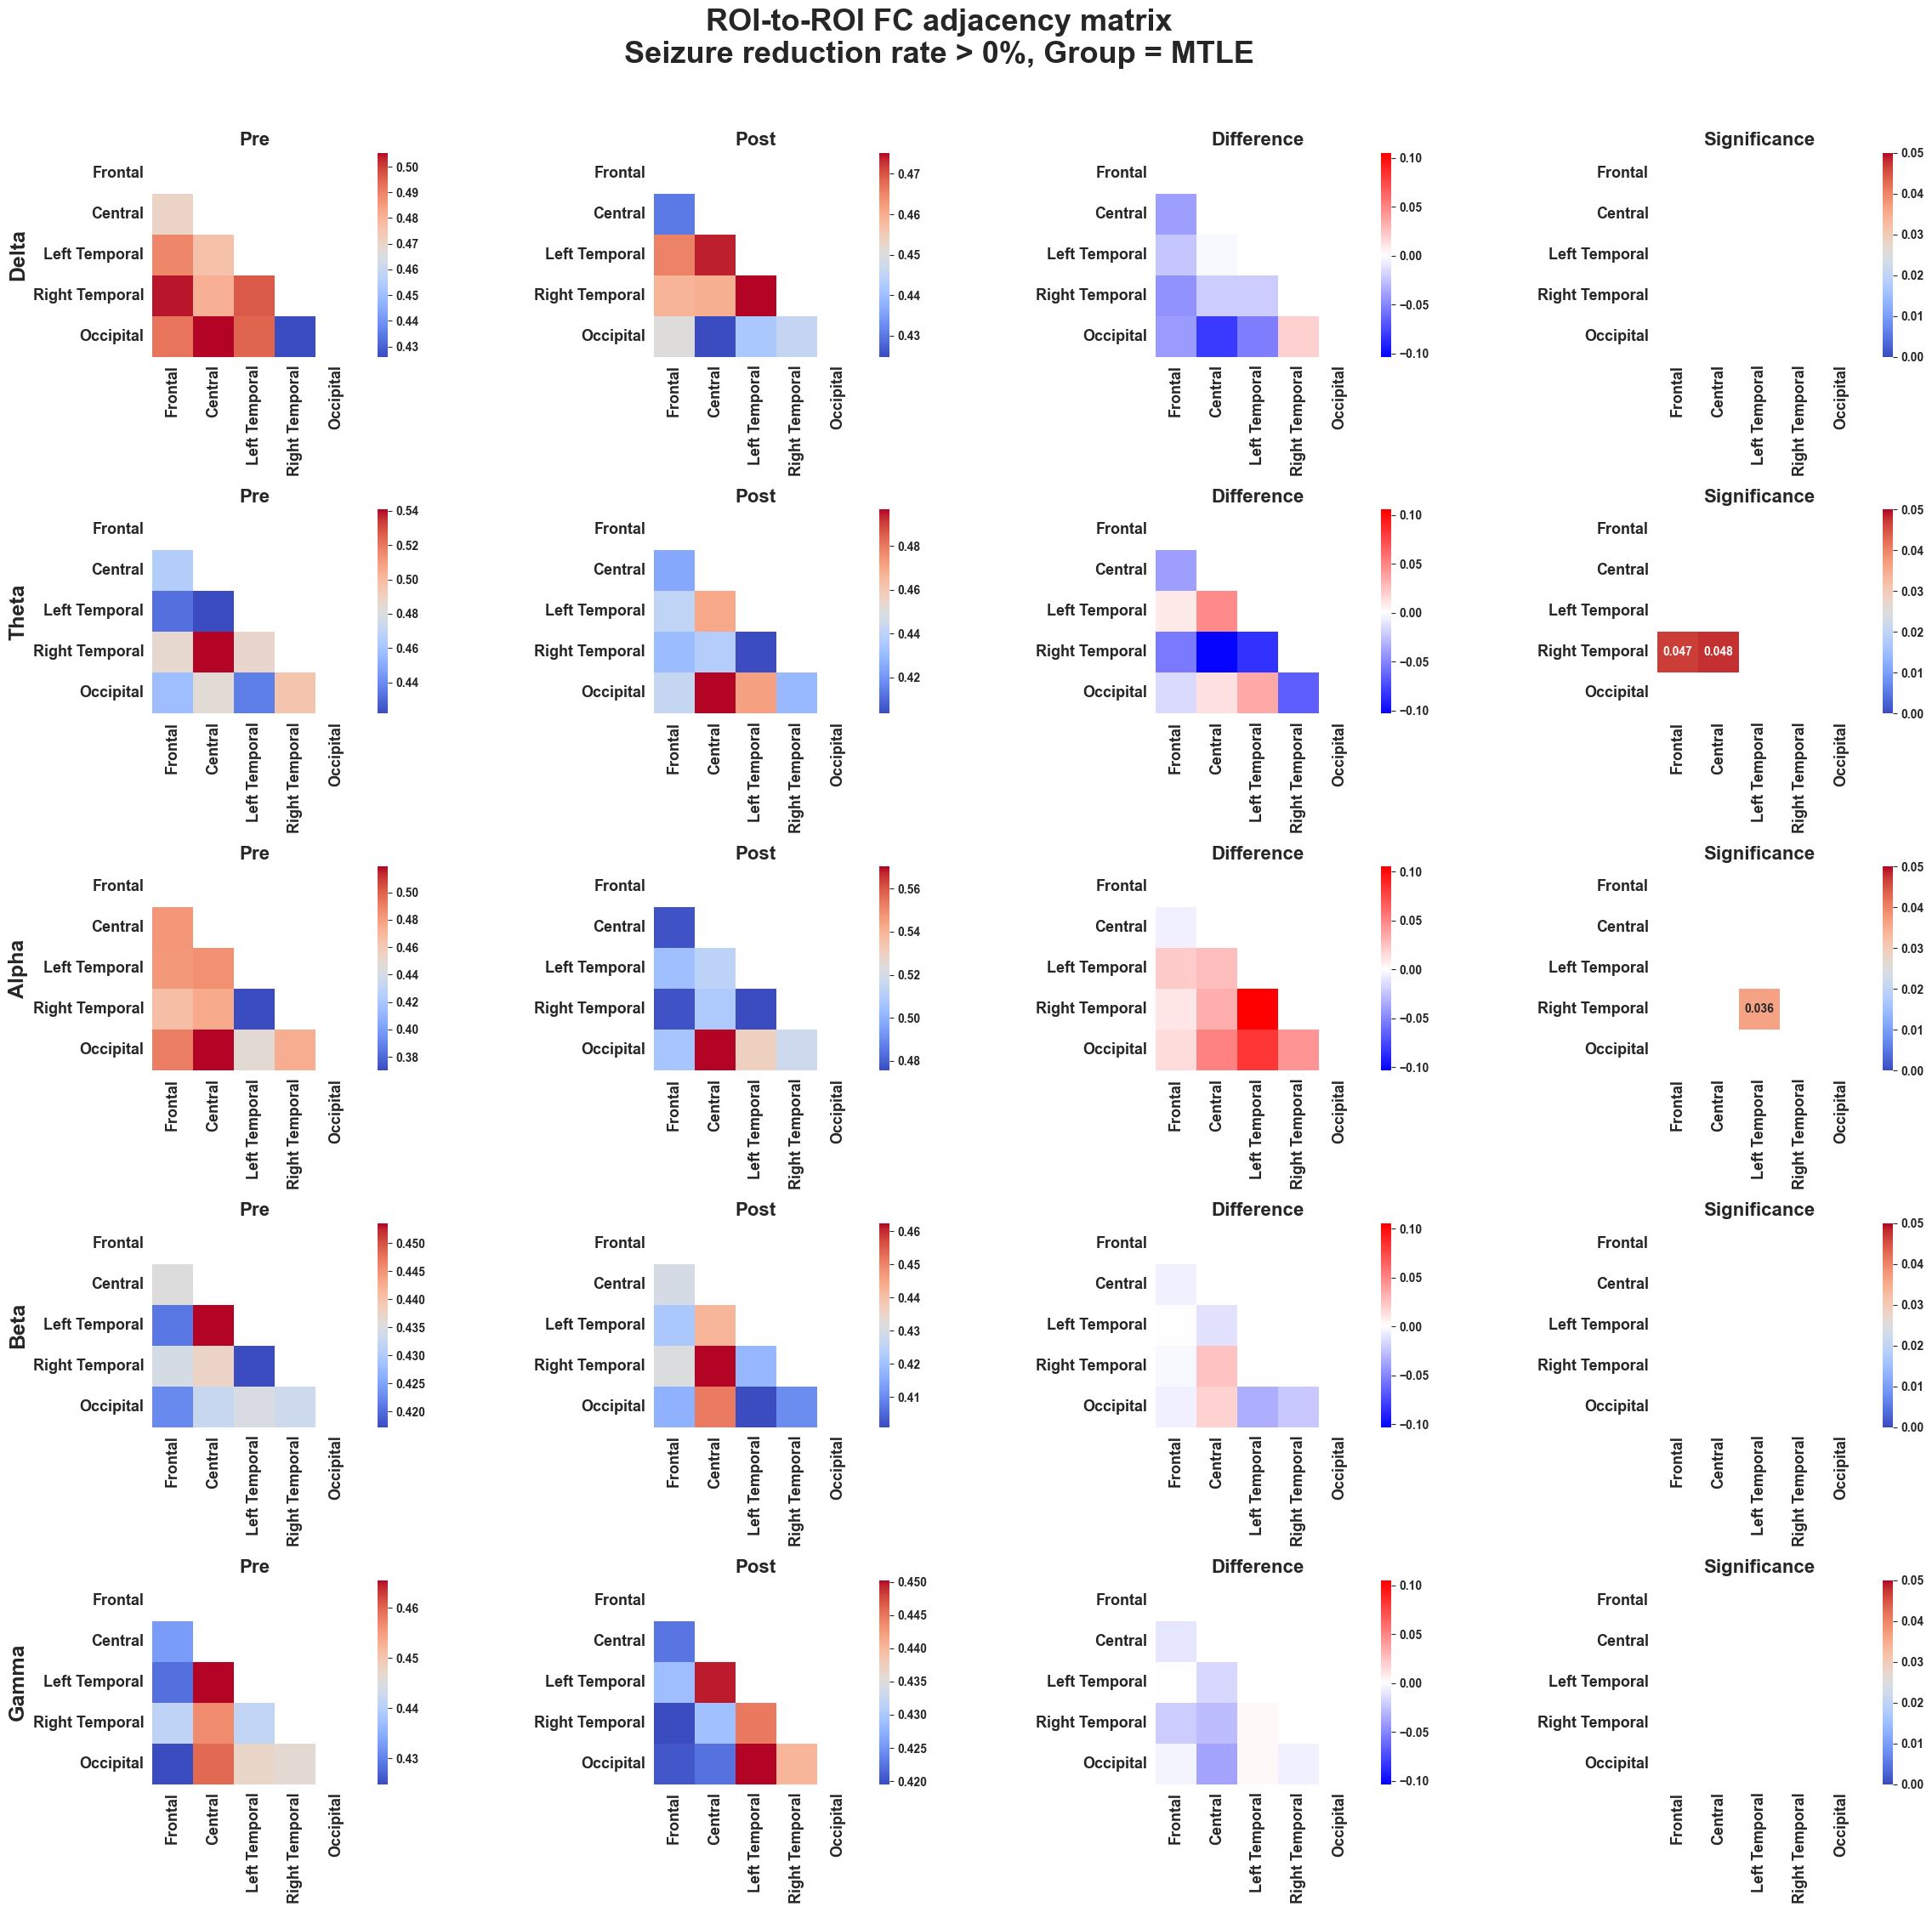

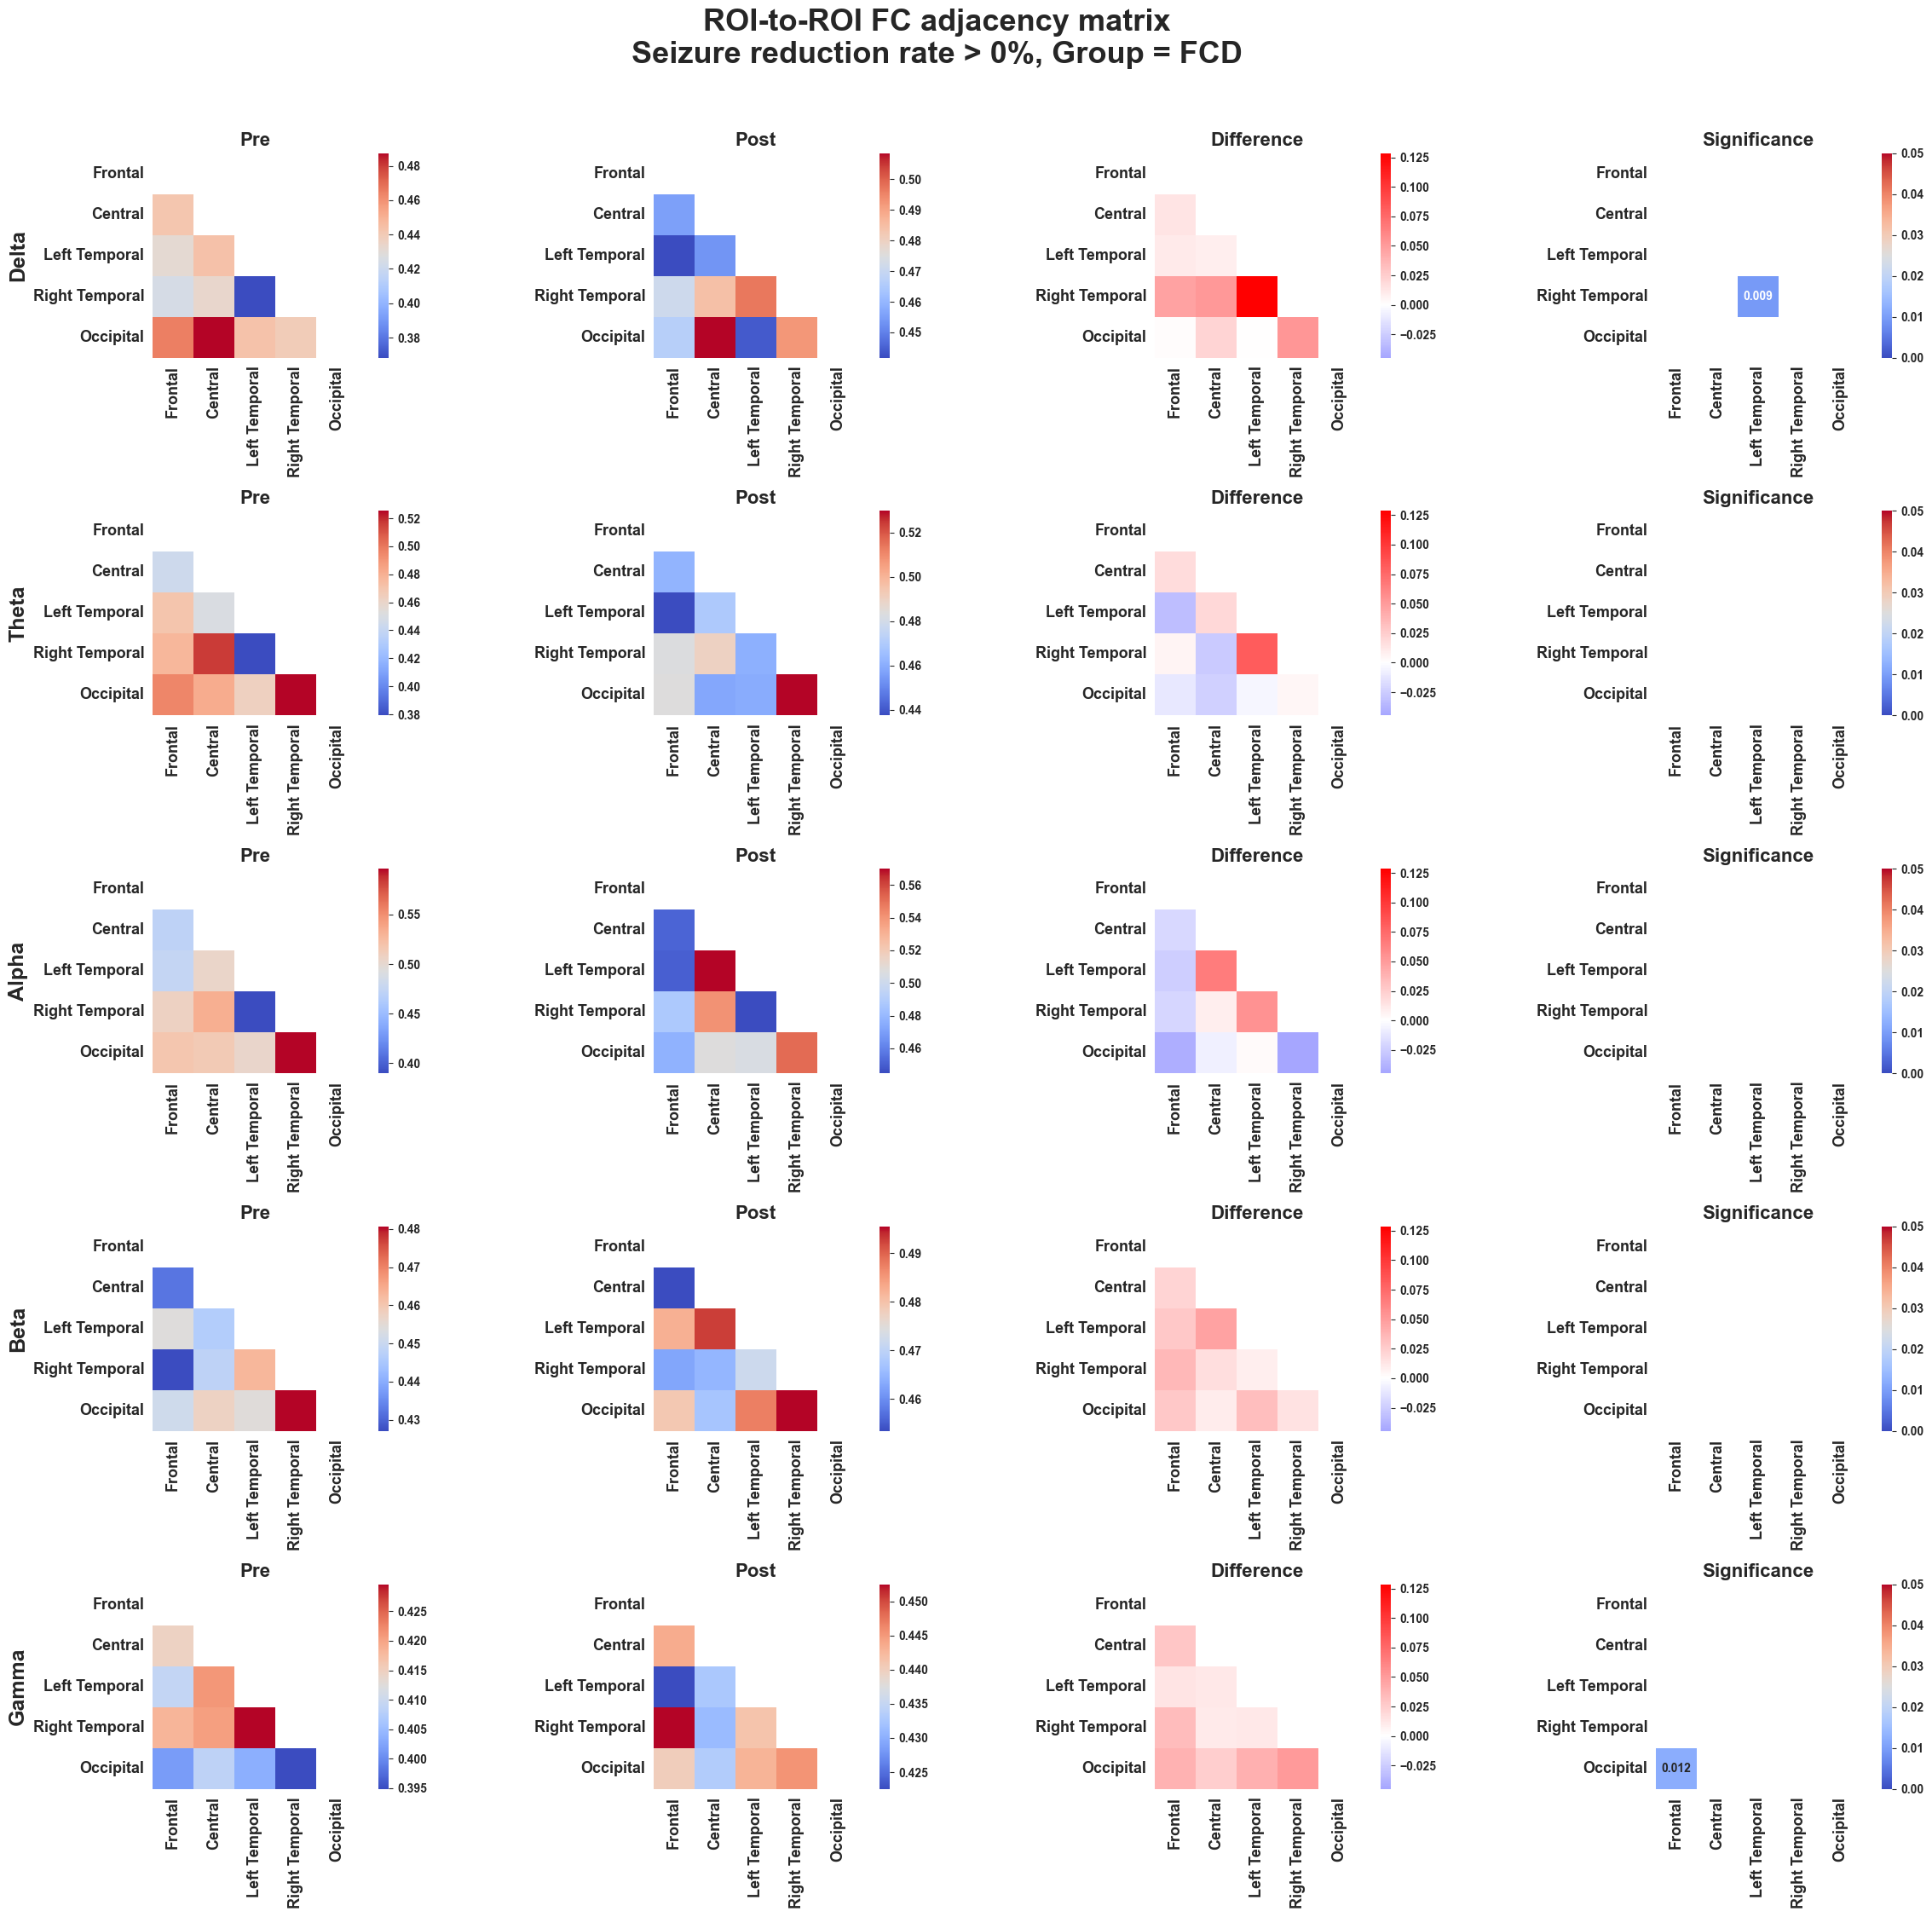

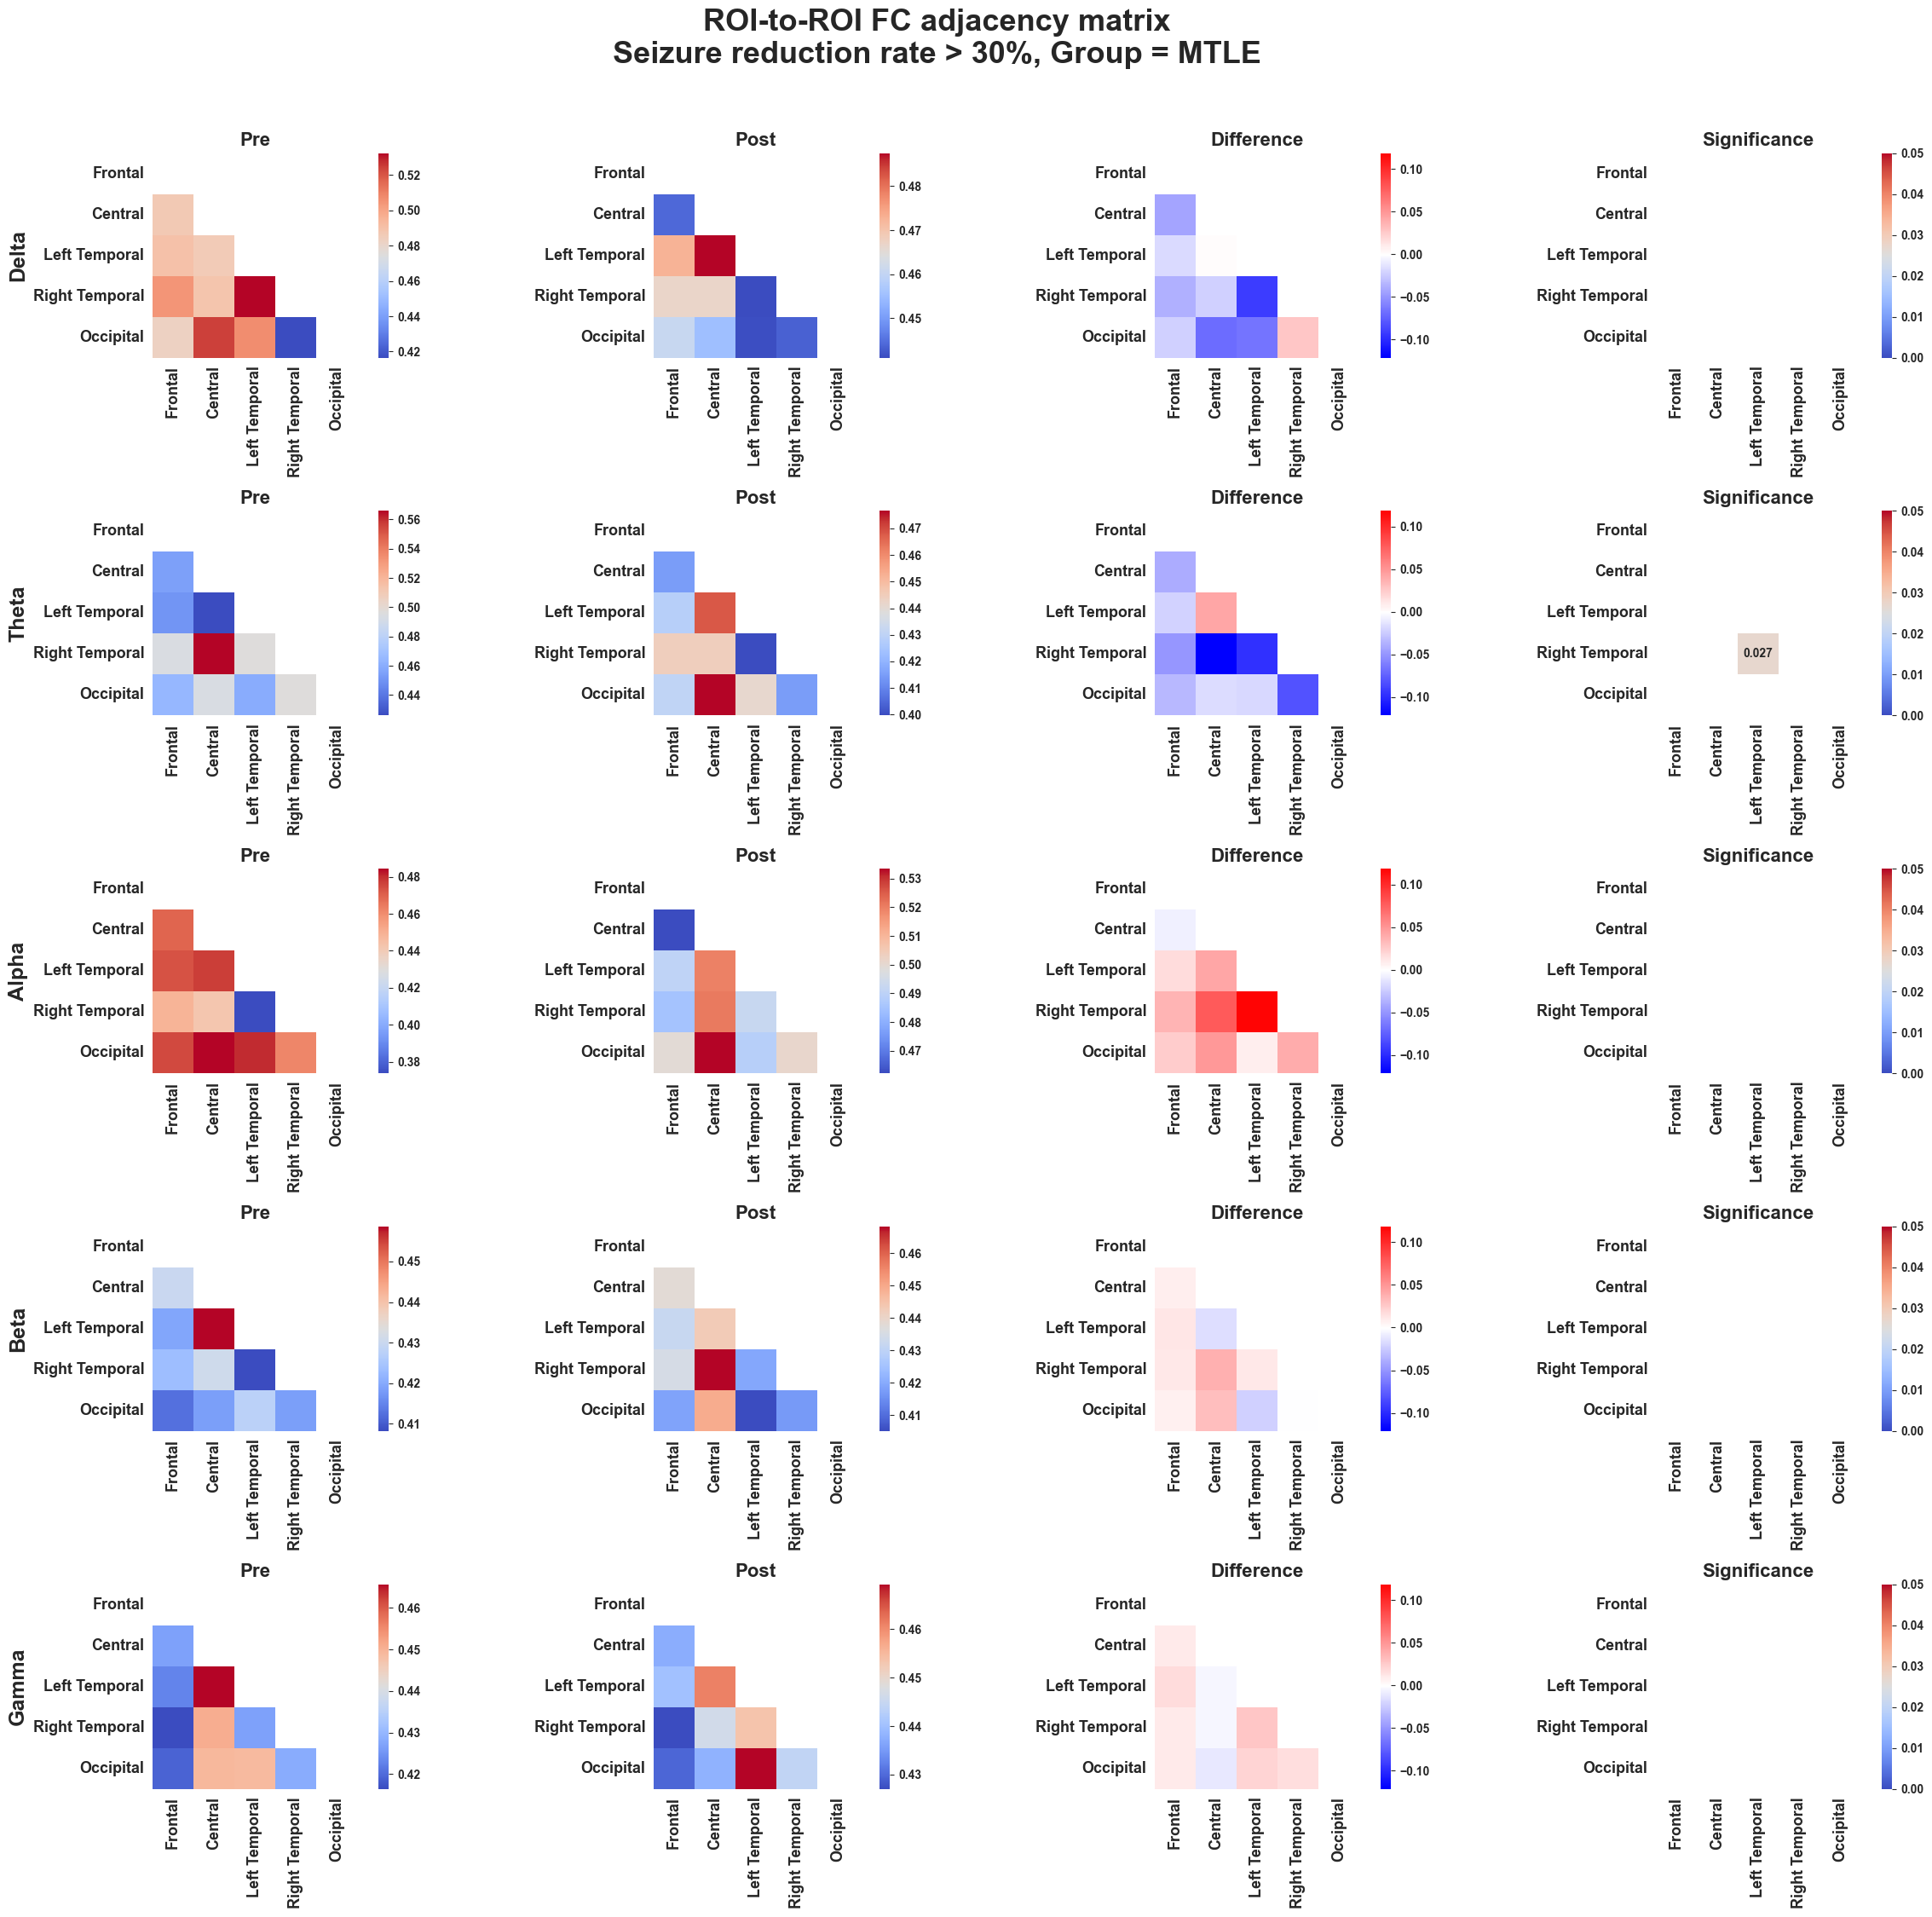

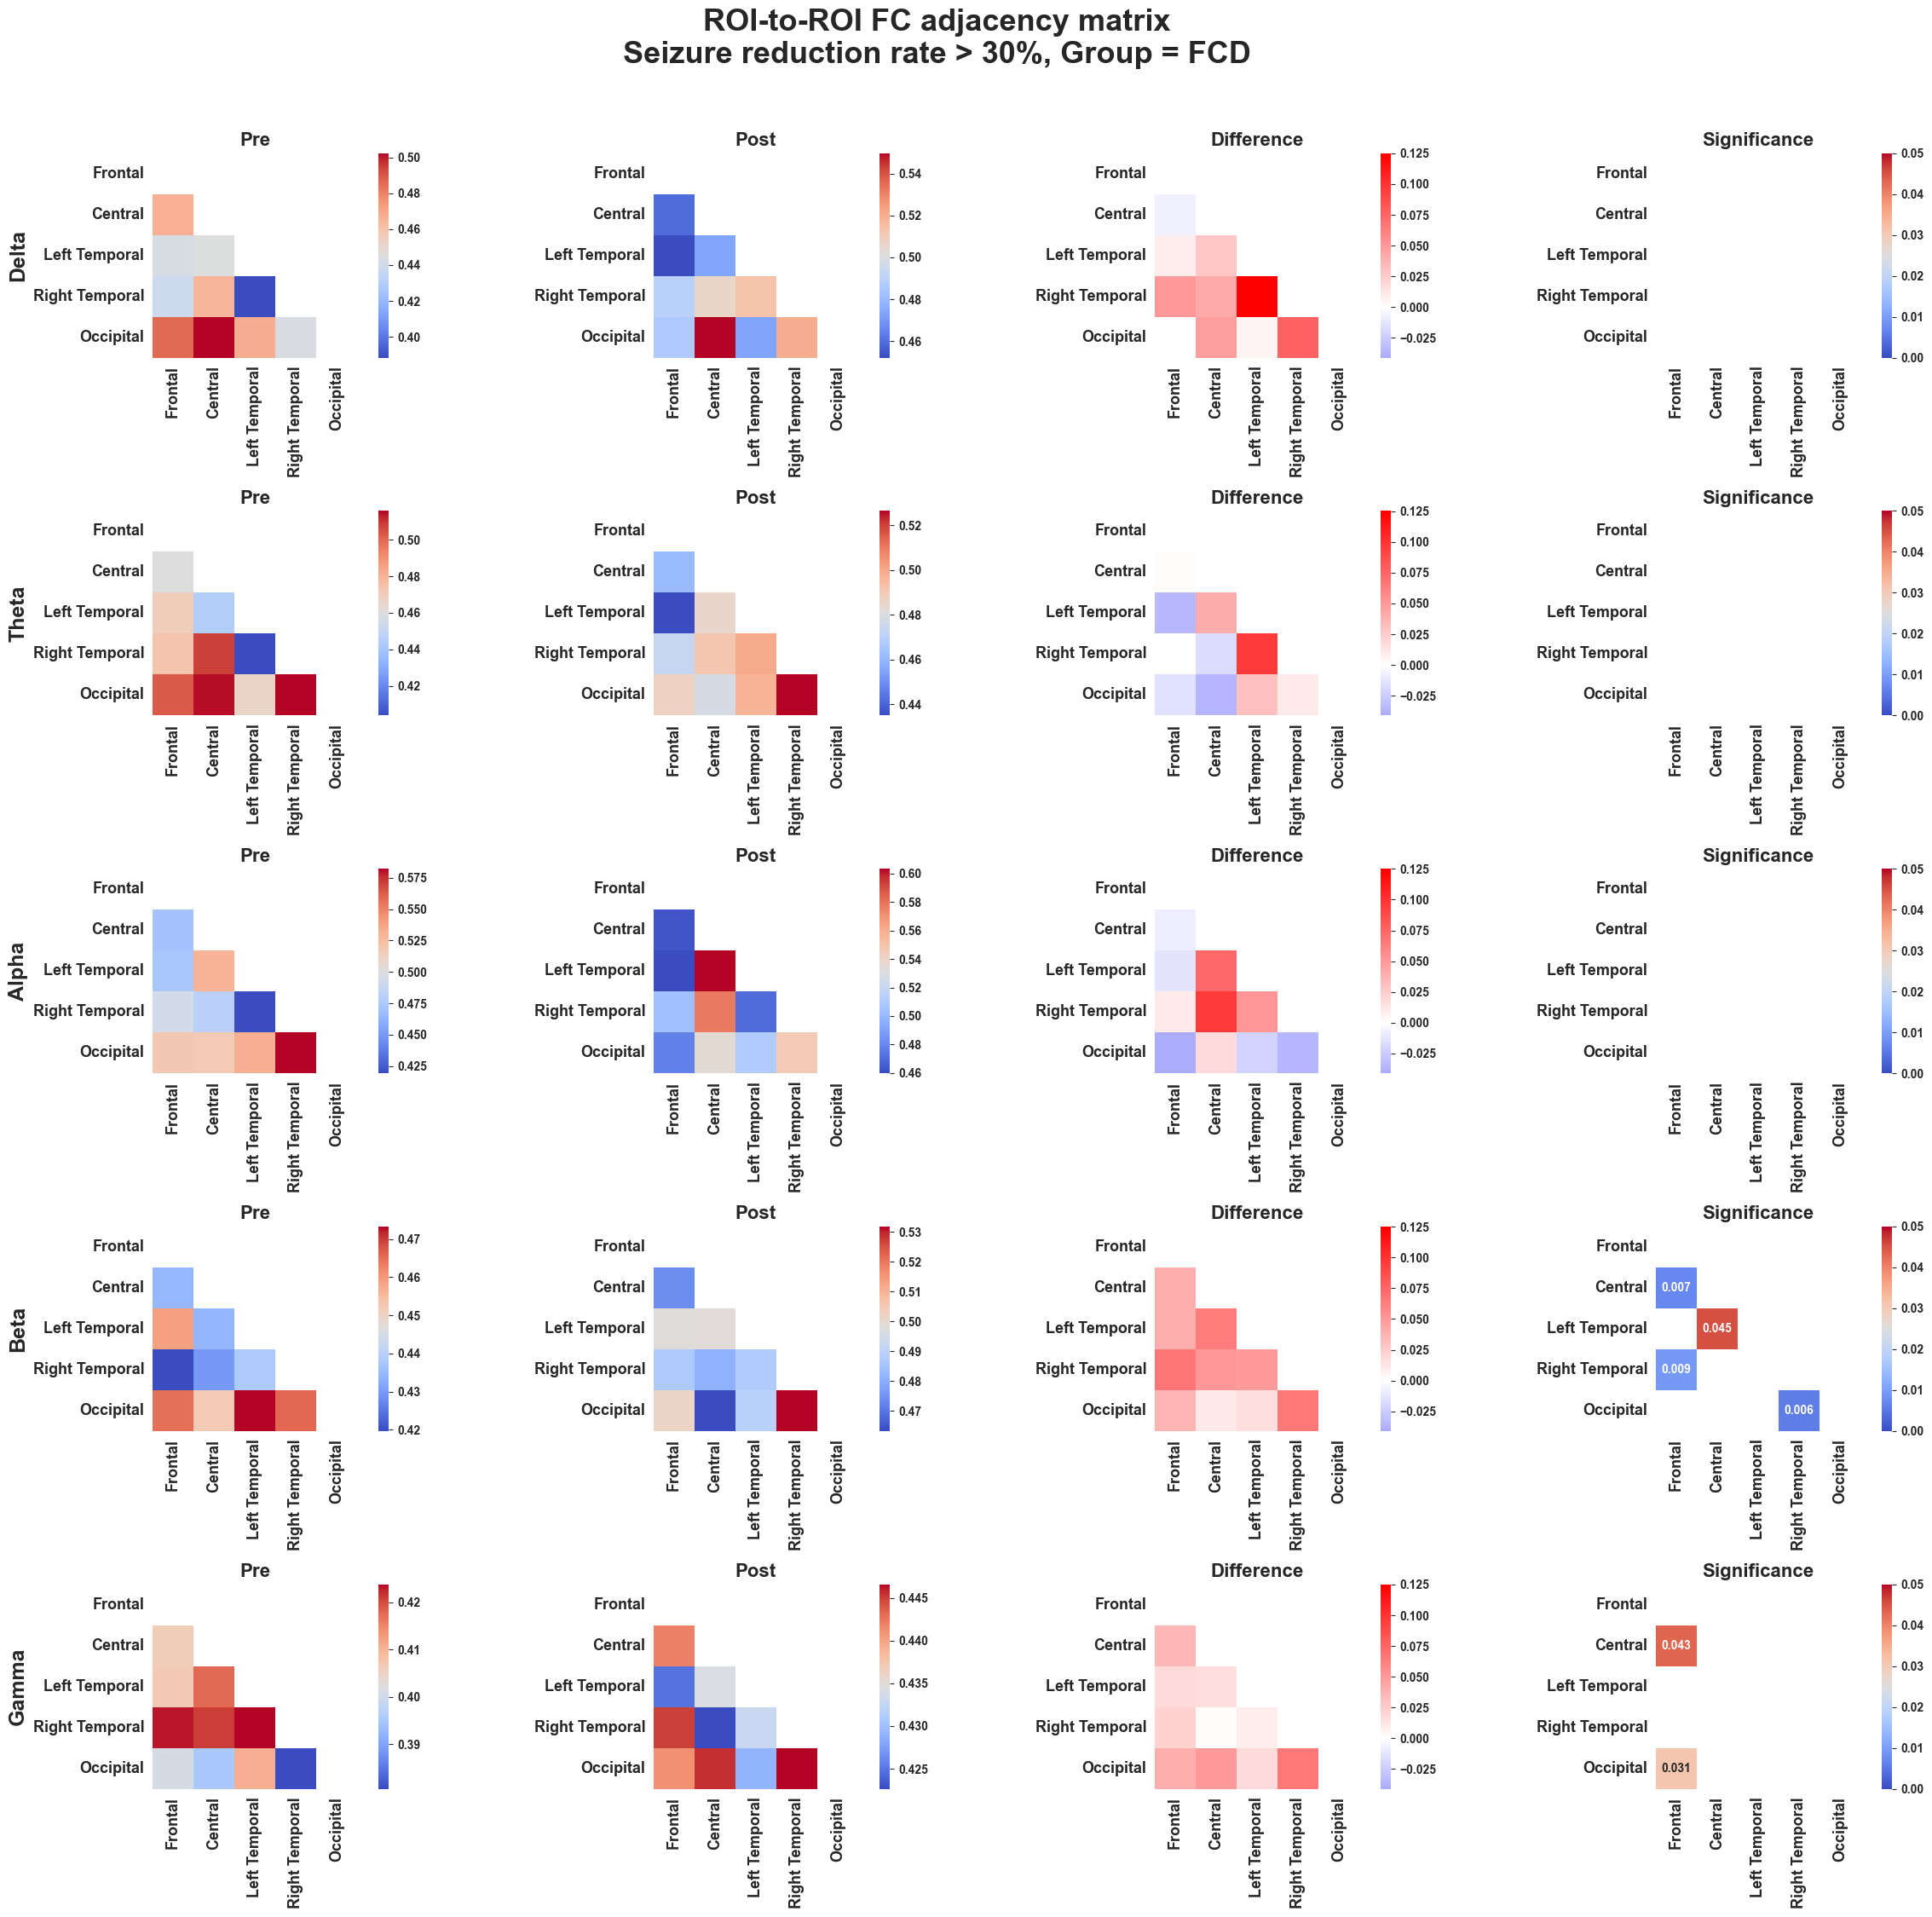

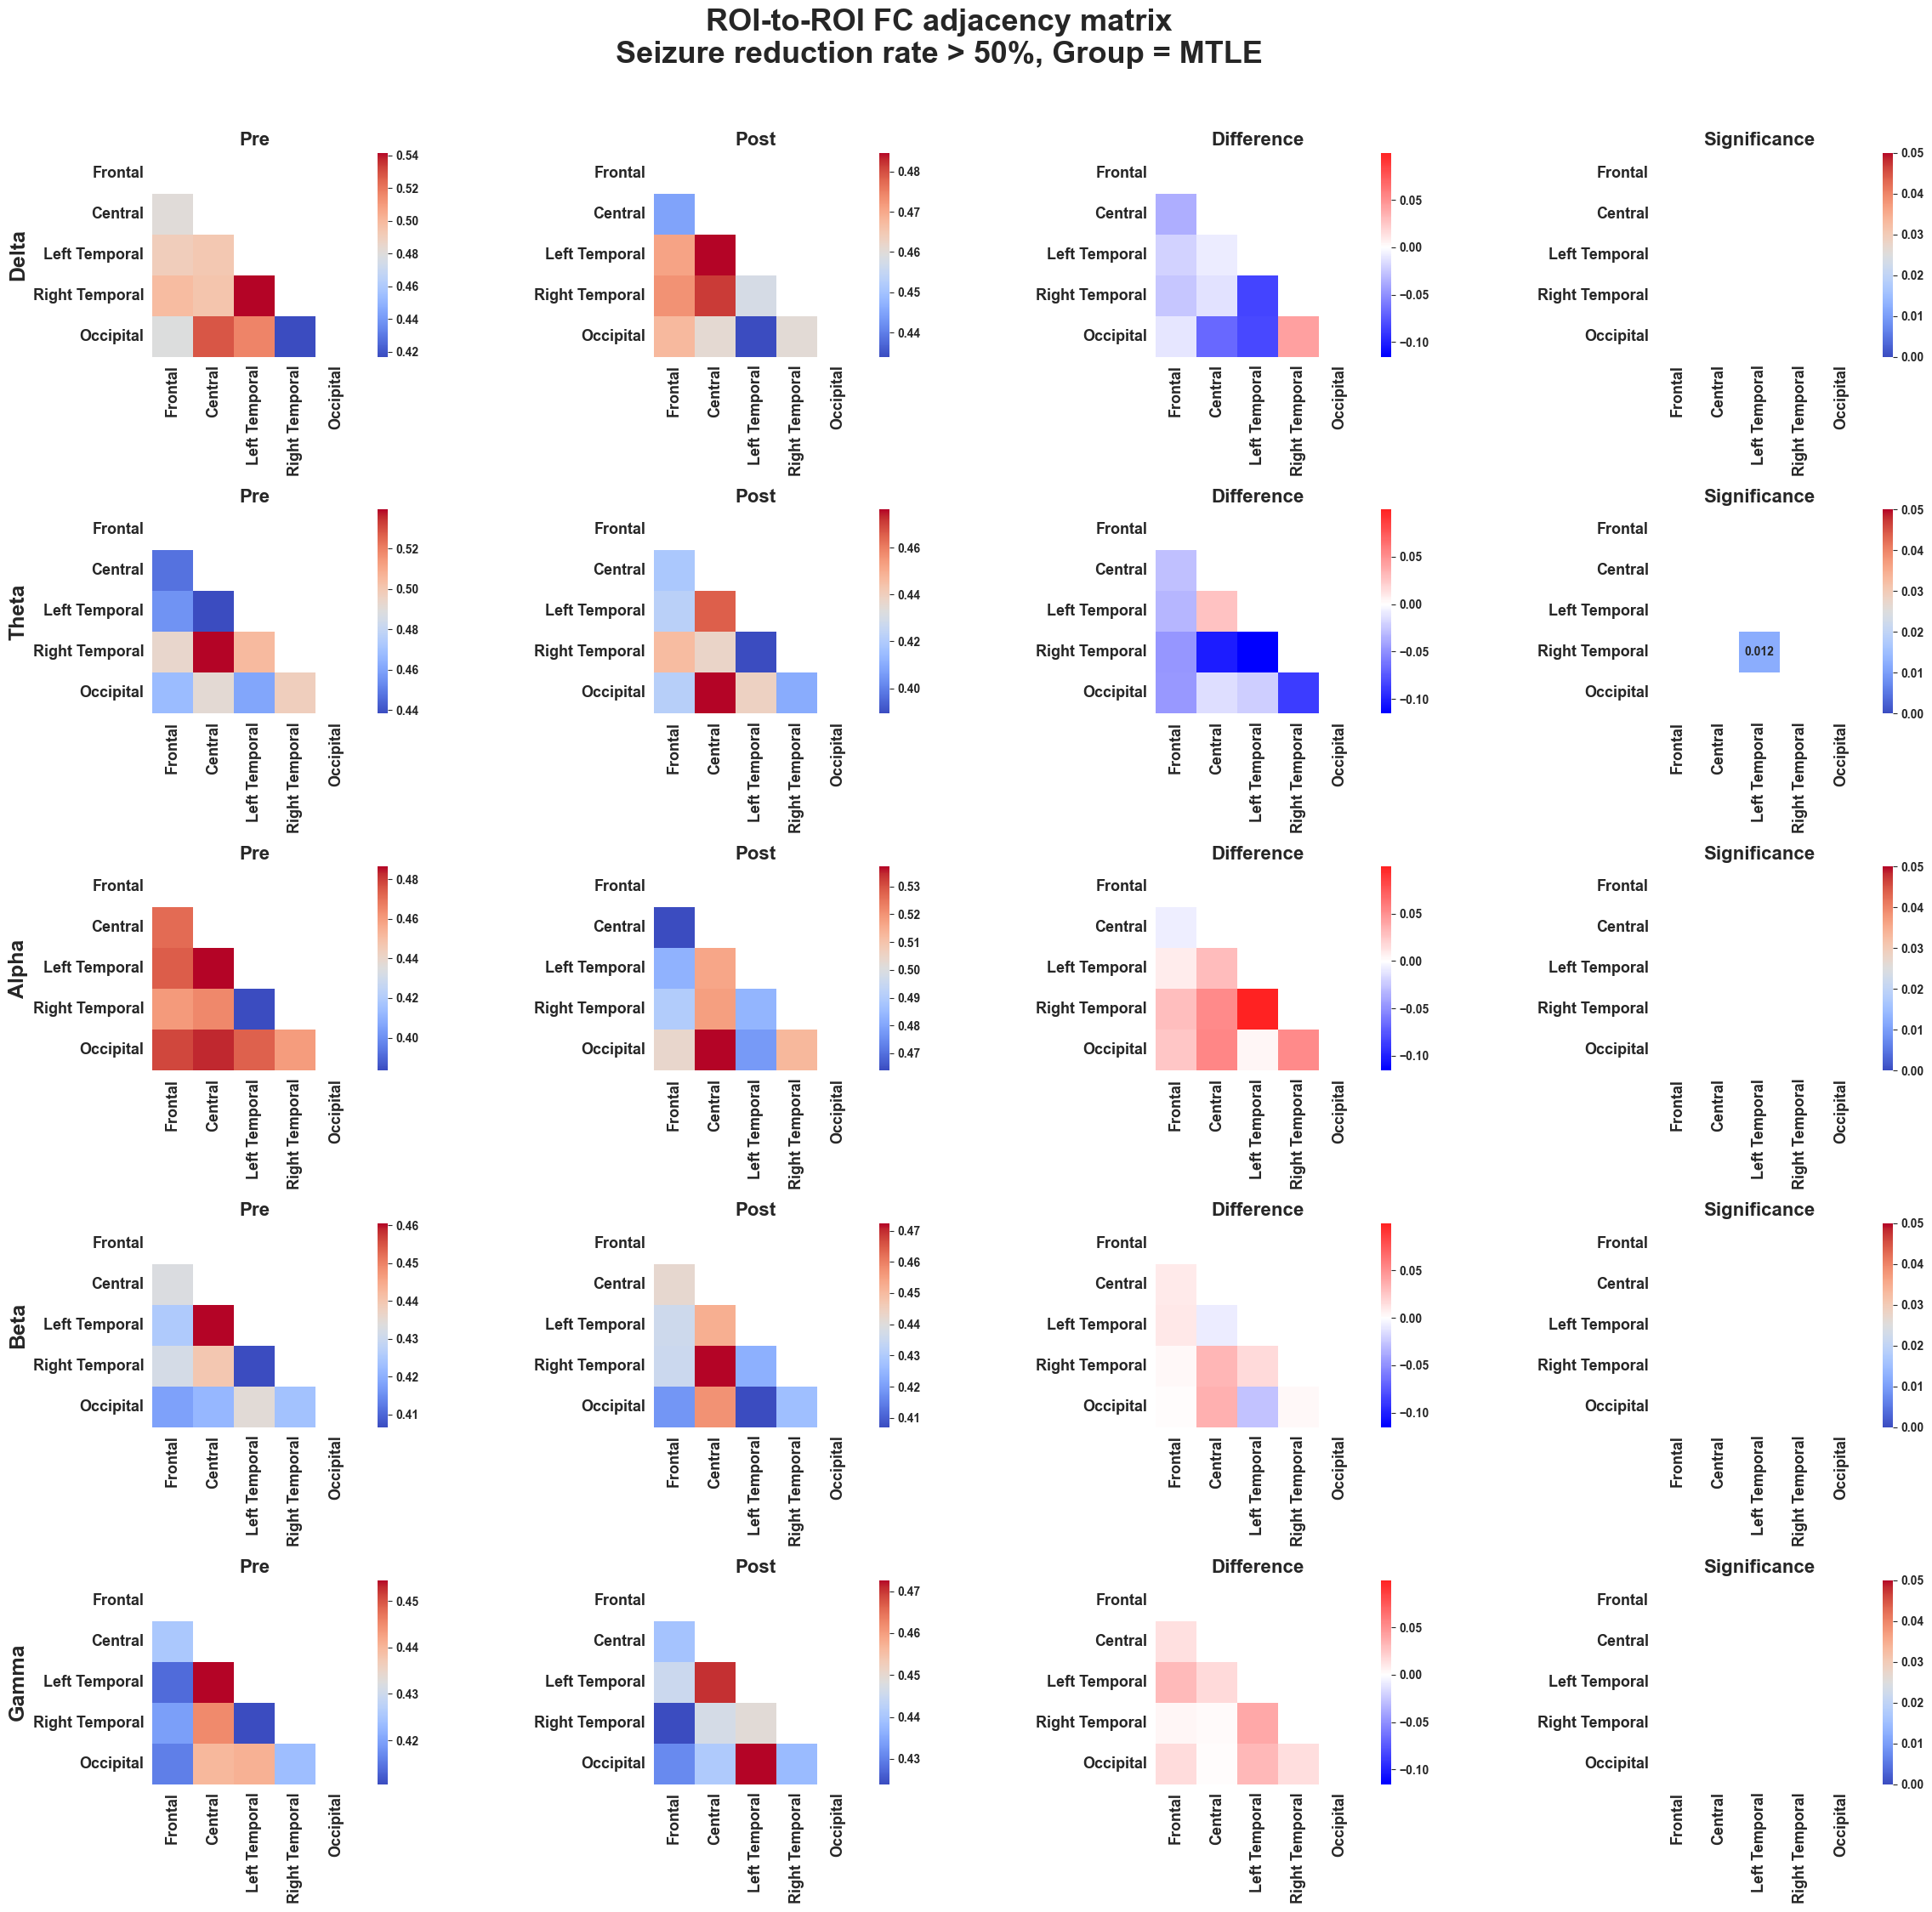

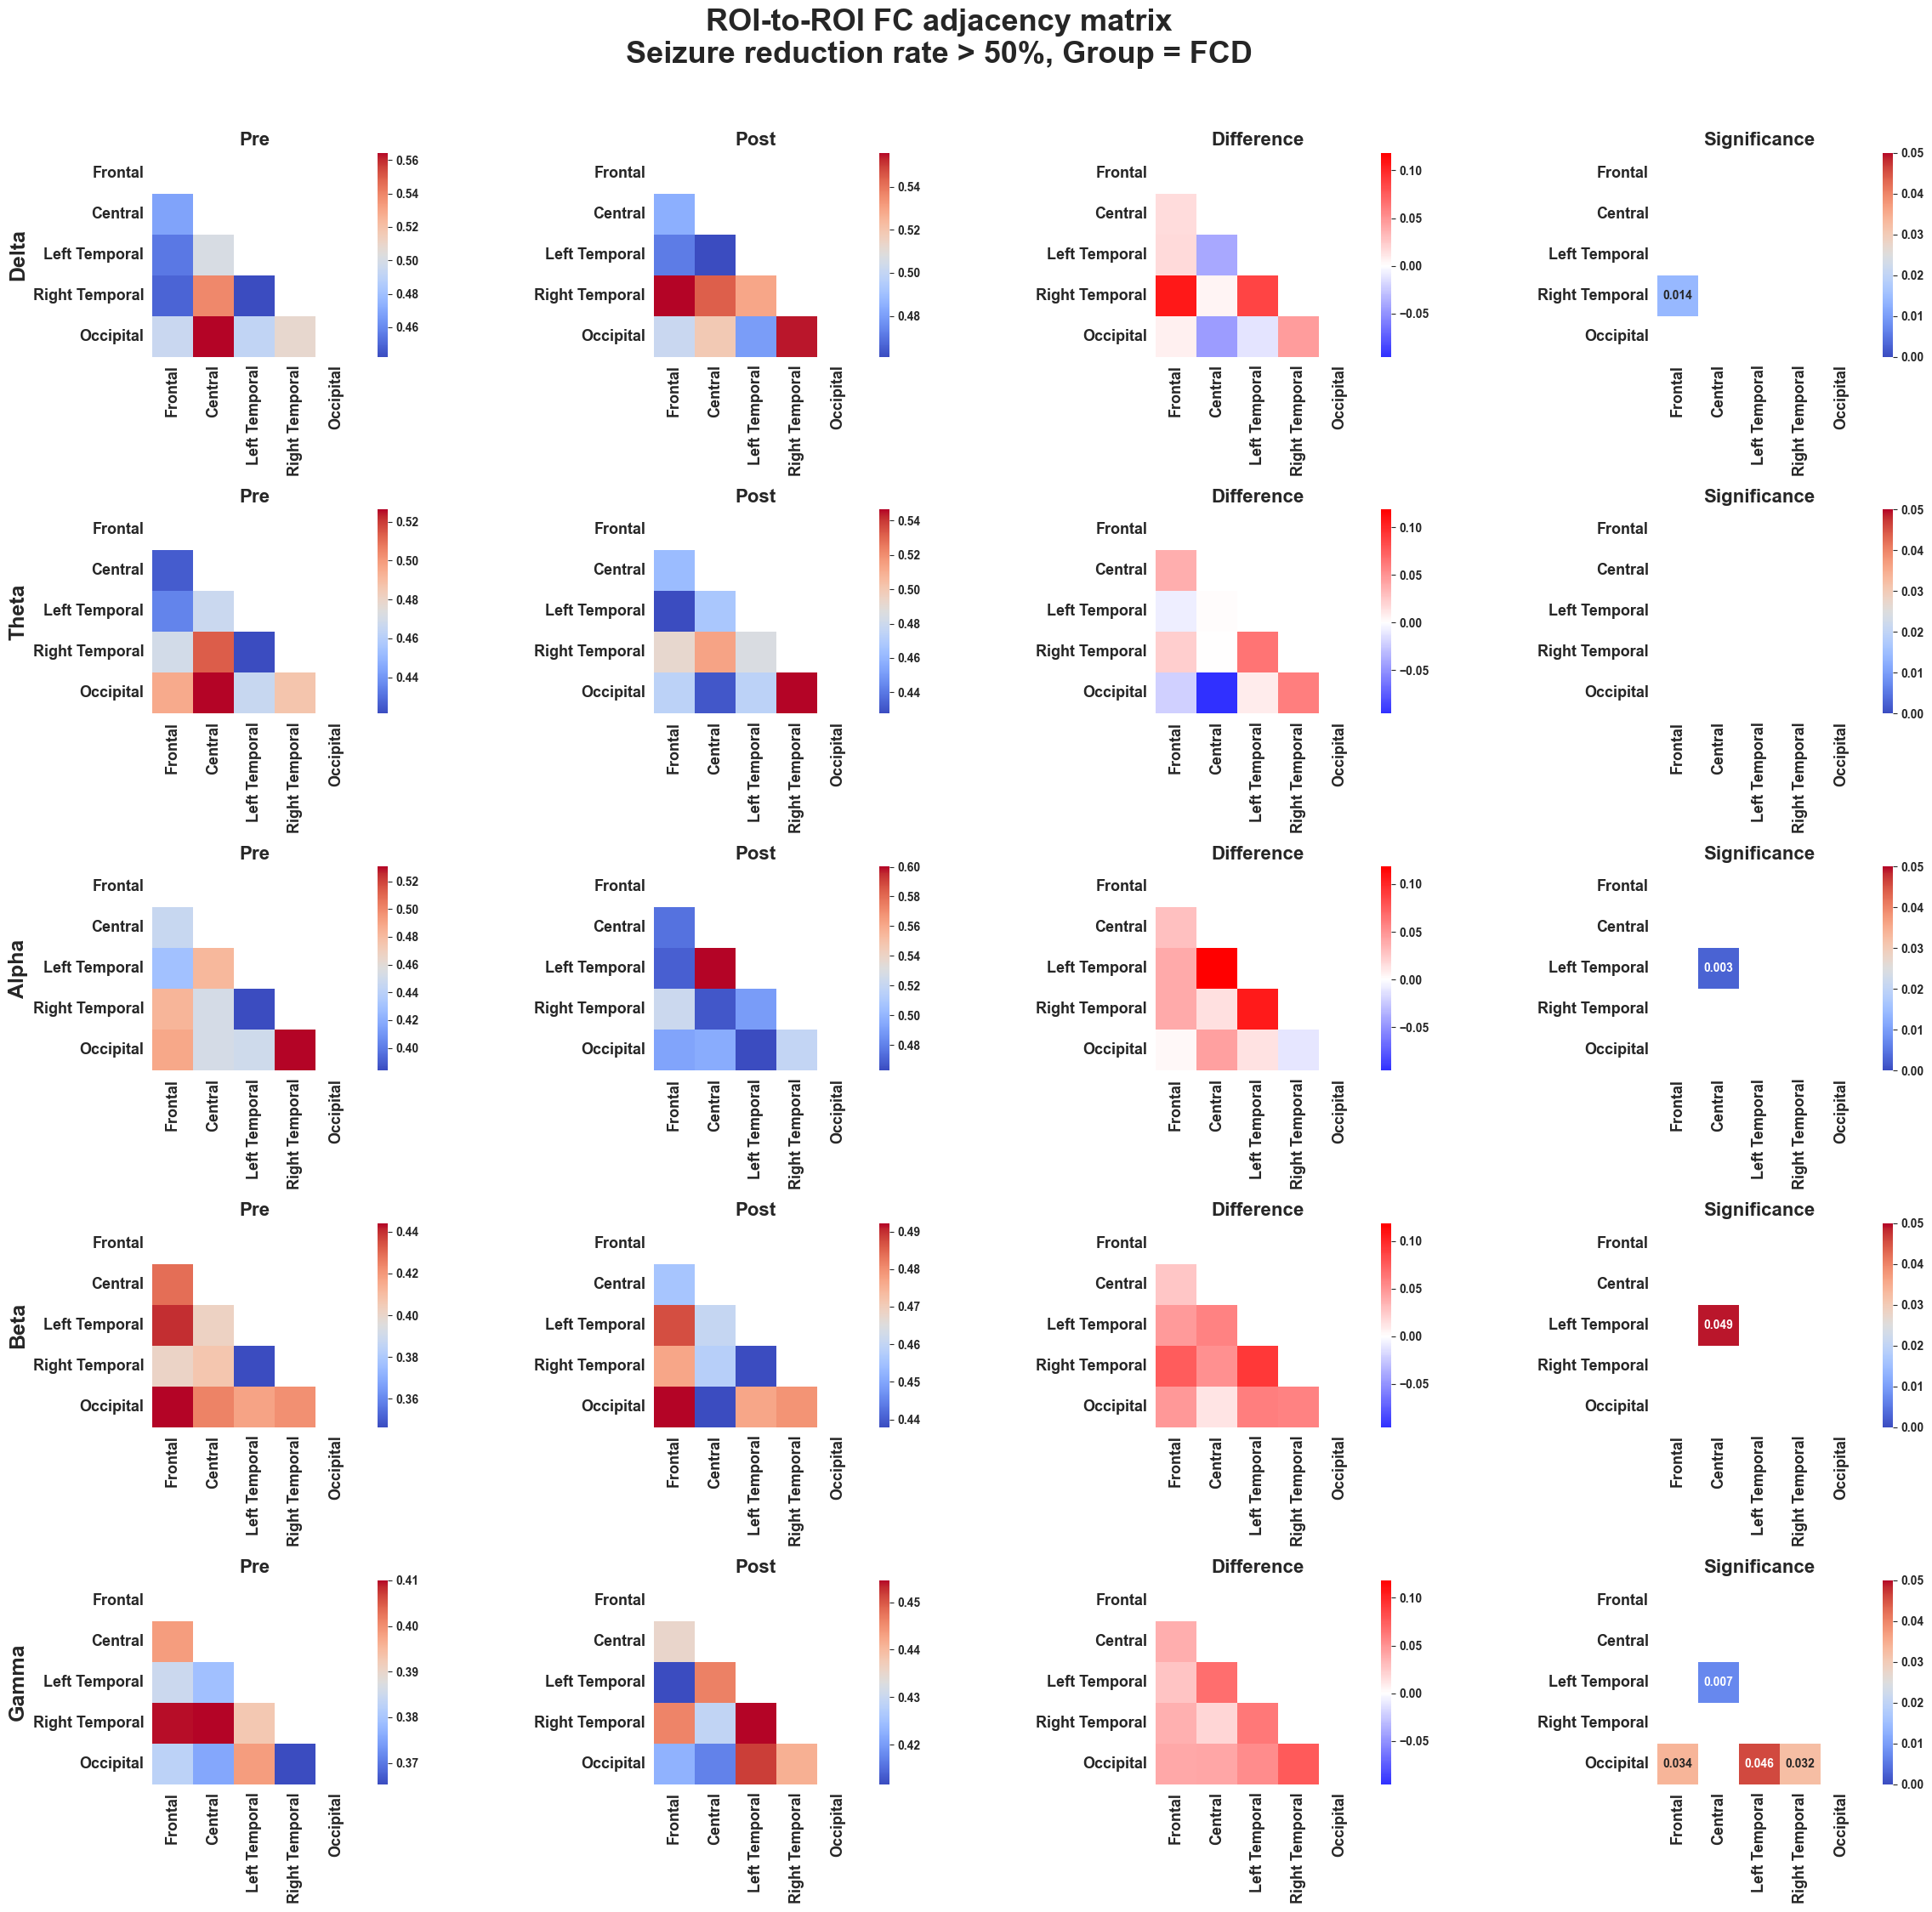

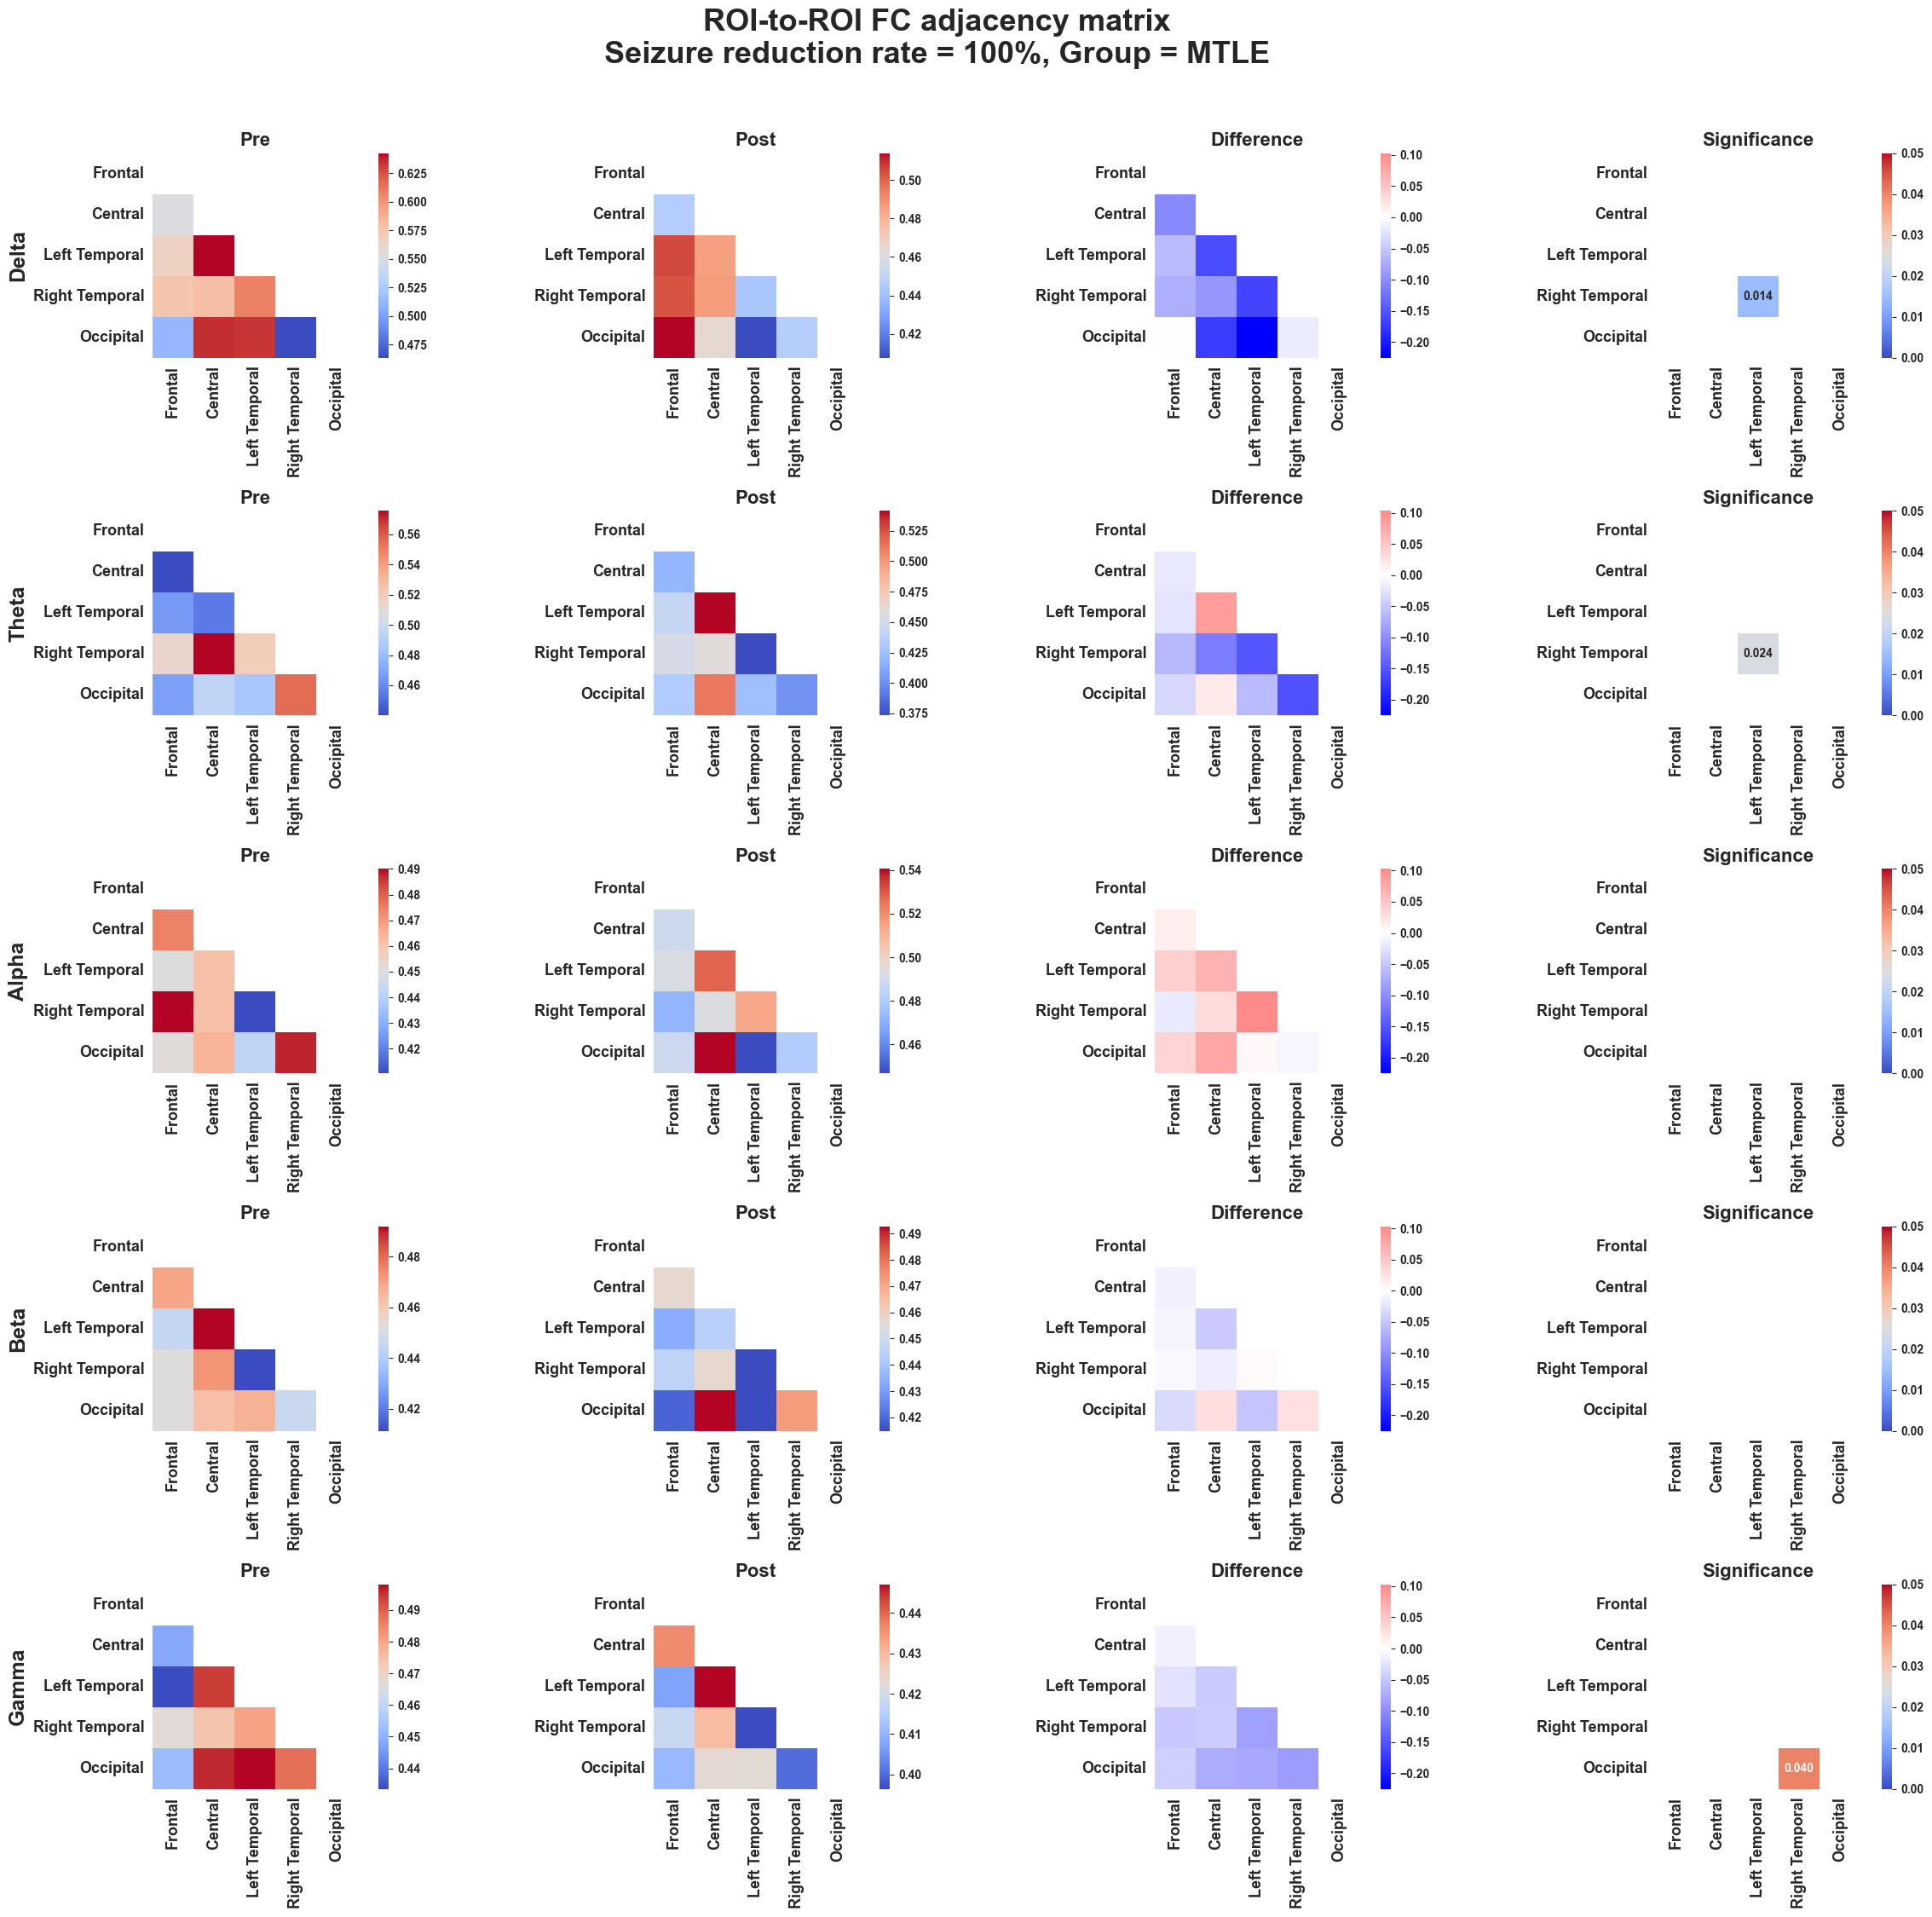

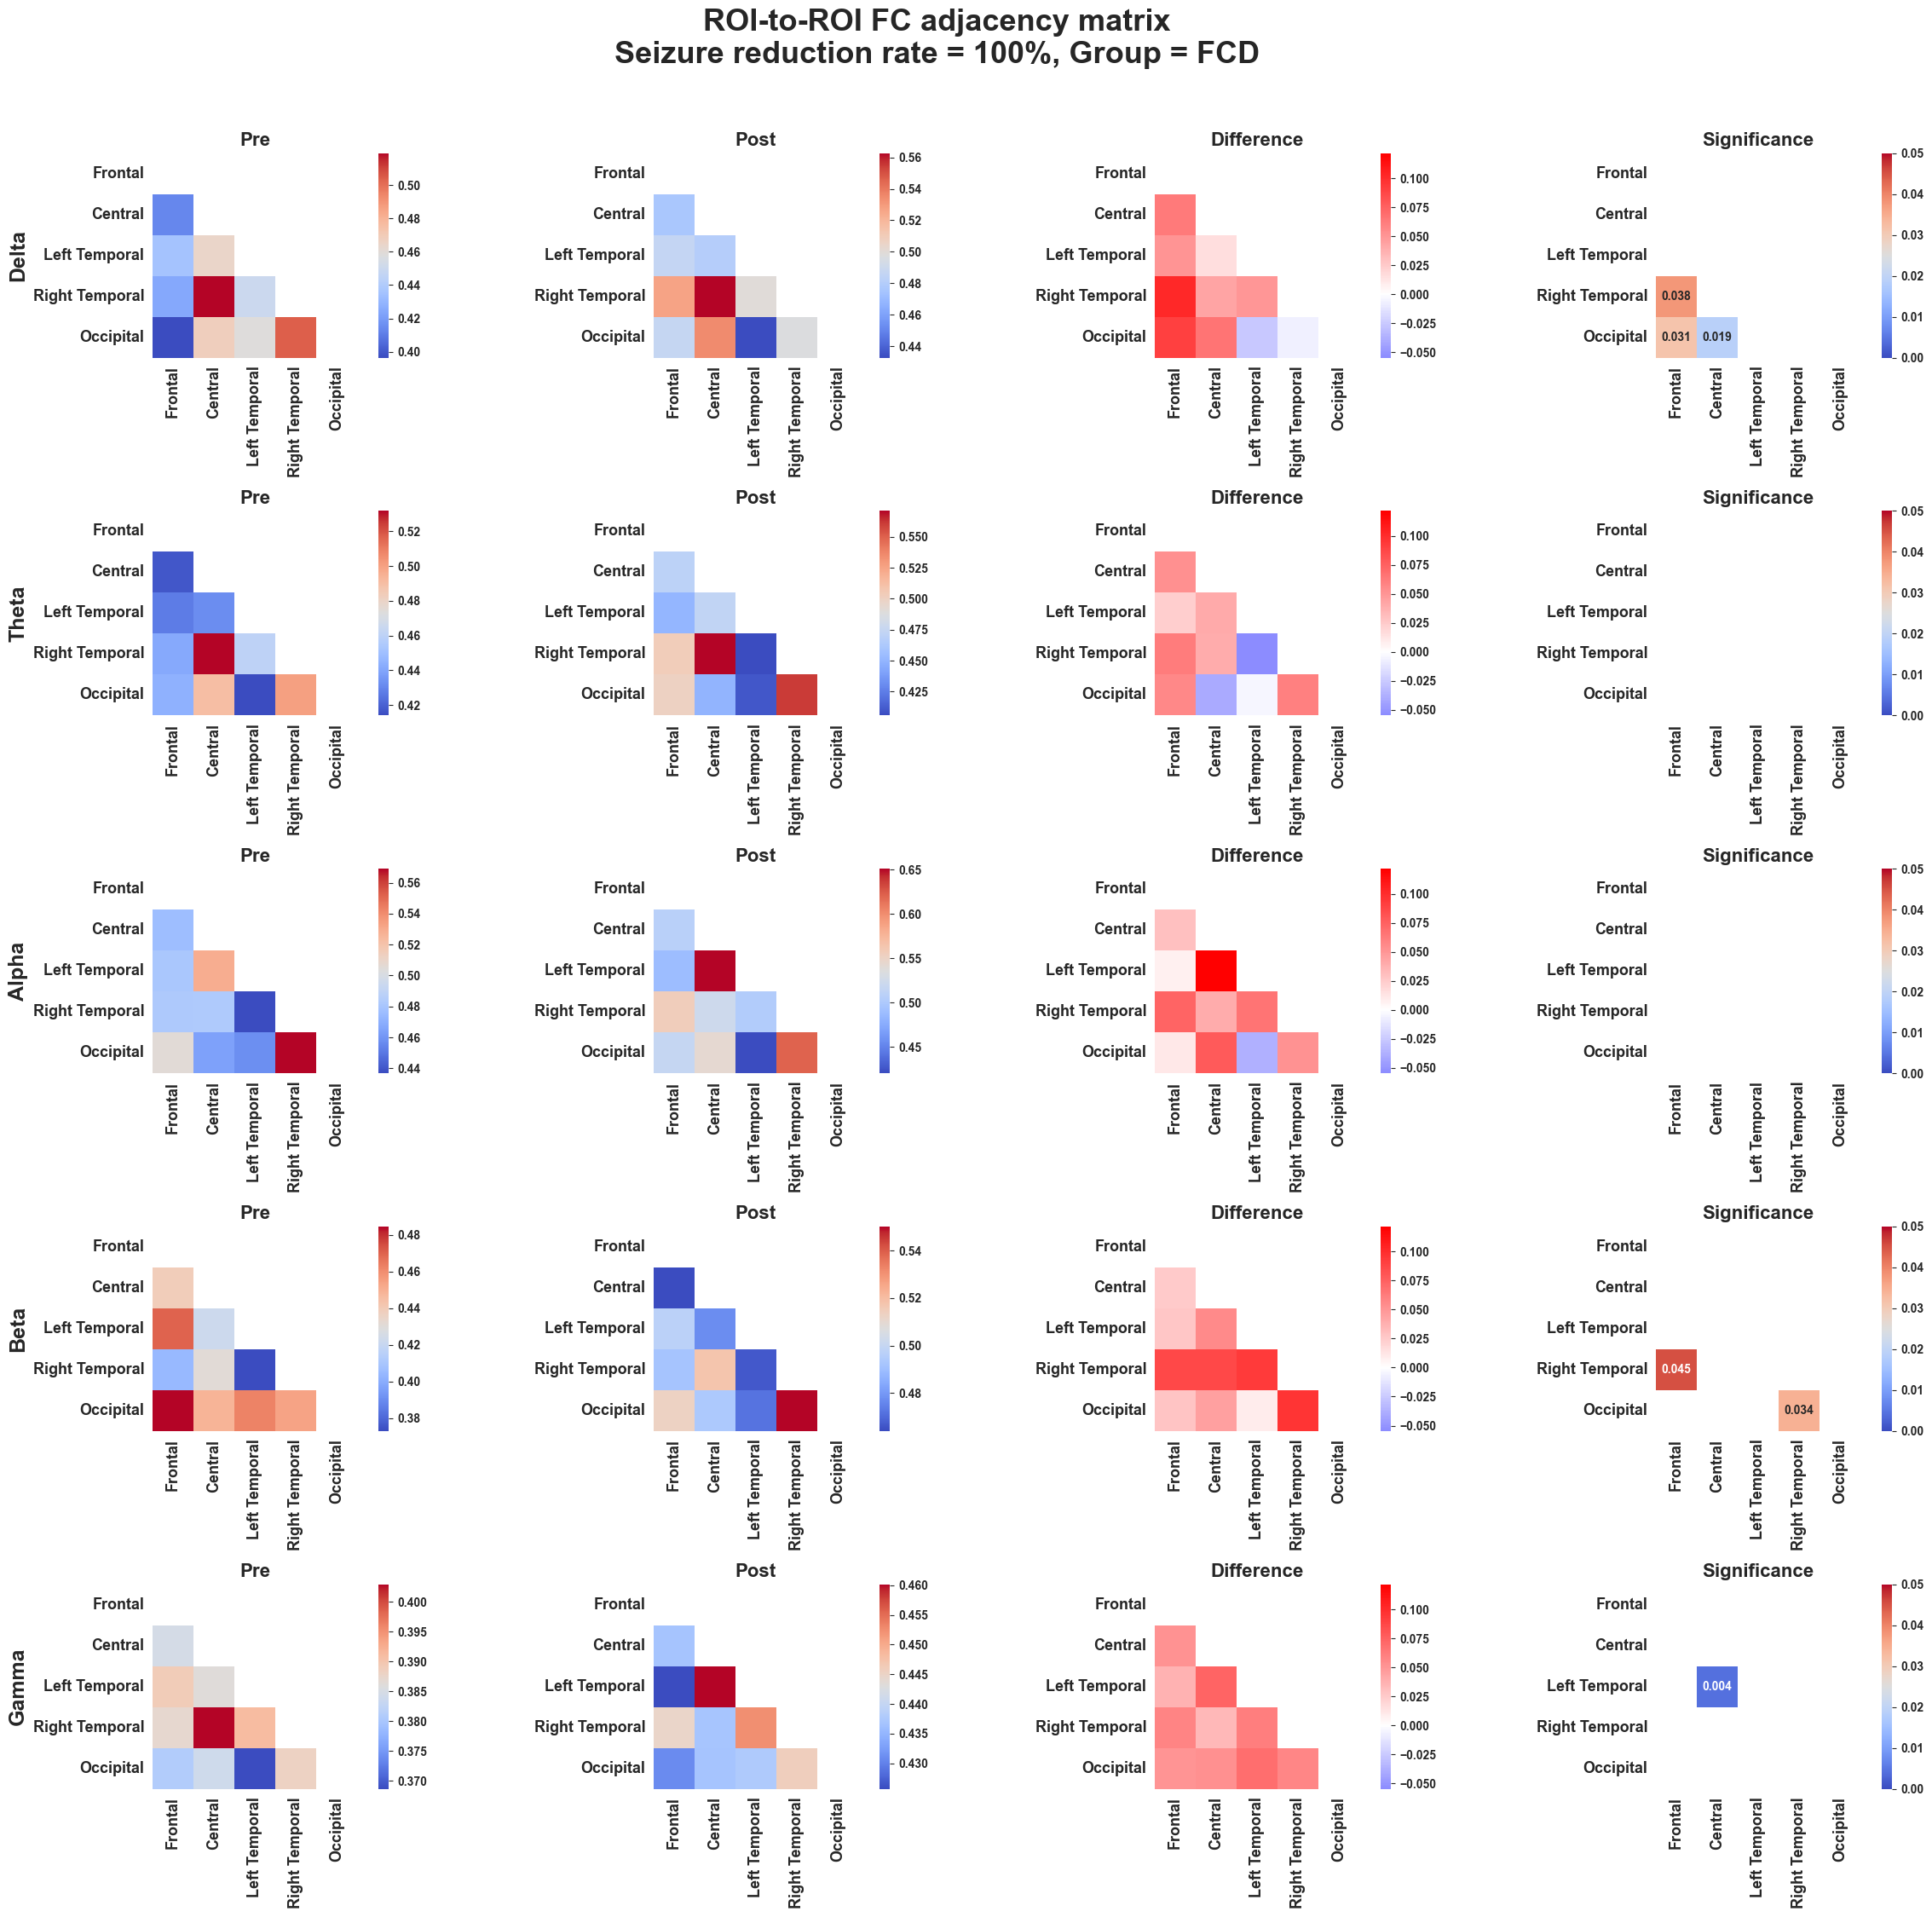

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

def plot_roi_55matrix_responsiveness(csv_path):
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    regions = ['Frontal', 'Central', 'LeftTemporal', 'RightTemporal', 'Occipital']
    regions_pretty = ['Frontal', 'Central', 'Left Temporal', 'Right Temporal', 'Occipital']

    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.weight'] = 'bold'
    sns.set_style("white")

    df_full = pd.read_csv(csv_path)

    responsiveness_cols = ['Responsiveness_0', 'Responsiveness_30', 'Responsiveness_50', 'Responsiveness_100']
    resp_labels = {
        'Responsiveness_0': 'Seizure reduction rate > 0%',
        'Responsiveness_30': 'Seizure reduction rate > 30%',
        'Responsiveness_50': 'Seizure reduction rate > 50%',
        'Responsiveness_100': 'Seizure reduction rate = 100%'
    }
    etiologies = ['tle', 'fcd']
    etio_labels = {
        'tle': 'Group = MTLE',
        'fcd': 'Group = FCD'
    }

    for resp_col in responsiveness_cols:
        for etio in etiologies:
            df = df_full[(df_full[resp_col] == 1) & (df_full['etiology'].str.lower() == etio)]
            subtitle = f"{resp_labels[resp_col]}, {etio_labels[etio]}"
            if df.empty:
                print(f"Skipping: {subtitle} (no data)")
                continue

            diff_matrices = []
            for band in bands:
                diff_mat = np.full((5, 5), np.nan)
                for i, r1 in enumerate(regions):
                    for j, r2 in enumerate(regions):
                        if i < j or i == j:
                            continue
                        pre_col1 = f'pre_{band}-{r1}-{r2}'
                        pre_col2 = f'pre_{band}-{r2}-{r1}'
                        post_col1 = f'post_{band}-{r1}-{r2}'
                        post_col2 = f'post_{band}-{r2}-{r1}'
                        pre_val = post_val = None
                        if pre_col1 in df.columns:
                            pre_val = df[pre_col1].mean()
                        elif pre_col2 in df.columns:
                            pre_val = df[pre_col2].mean()
                        if post_col1 in df.columns:
                            post_val = df[post_col1].mean()
                        elif post_col2 in df.columns:
                            post_val = df[post_col2].mean()
                        if (pre_val is not None) and (post_val is not None):
                            diff_mat[i, j] = post_val - pre_val
                diff_matrices.append(diff_mat)
            if not diff_matrices or all(np.all(np.isnan(d)) for d in diff_matrices):
                print(f"Skipping: {subtitle} (no valid diff data)")
                continue
            all_diff_vals = np.concatenate([d[~np.isnan(d)] for d in diff_matrices])
            diff_vmin, diff_vmax = np.min(all_diff_vals), np.max(all_diff_vals)

            fig, axes = plt.subplots(len(bands), 4, figsize=(24, 22))
            plt.subplots_adjust(hspace=0.35, wspace=0.15)
            fig.suptitle(f"ROI-to-ROI FC adjacency matrix\n{subtitle}", fontsize=26, fontweight='bold', fontname='Arial', y=1.02)

            for row, band in enumerate(bands):
                pre_mat = np.full((5, 5), np.nan)
                post_mat = np.full((5, 5), np.nan)
                diff_mat = np.full((5, 5), np.nan)
                pval_mat = np.full((5, 5), np.nan)
                annot_mat = np.full((5, 5), '', dtype=object)
                for i, r1 in enumerate(regions):
                    for j, r2 in enumerate(regions):
                        if i < j:
                            continue
                        elif i == j:
                            pre_mat[i, j] = np.nan
                            post_mat[i, j] = np.nan
                            diff_mat[i, j] = np.nan
                            pval_mat[i, j] = np.nan
                            annot_mat[i, j] = ''
                        else:
                            pre_col1 = f'pre_{band}-{r1}-{r2}'
                            pre_col2 = f'pre_{band}-{r2}-{r1}'
                            post_col1 = f'post_{band}-{r1}-{r2}'
                            post_col2 = f'post_{band}-{r2}-{r1}'
                            pre_vals = post_vals = None
                            if pre_col1 in df.columns:
                                pre_vals = df[pre_col1]
                            elif pre_col2 in df.columns:
                                pre_vals = df[pre_col2]
                            if post_col1 in df.columns:
                                post_vals = df[post_col1]
                            elif post_col2 in df.columns:
                                post_vals = df[post_col2]
                            if (pre_vals is not None) and (post_vals is not None):
                                pre_mat[i, j] = pre_vals.mean()
                                post_mat[i, j] = post_vals.mean()
                                diff_mat[i, j] = post_vals.mean() - pre_vals.mean()
                                try:
                                    stat, pval = ttest_rel(pre_vals, post_vals)
                                except Exception:
                                    pval = np.nan
                                if pval < 0.05:
                                    pval_mat[i, j] = pval
                                    annot_mat[i, j] = f"{pval:.3f}"
                                else:
                                    pval_mat[i, j] = np.nan
                                    annot_mat[i, j] = ''
                            else:
                                pre_mat[i, j] = np.nan
                                post_mat[i, j] = np.nan
                                diff_mat[i, j] = np.nan
                                pval_mat[i, j] = np.nan
                                annot_mat[i, j] = ''
                for col, (matrix, title, cmap, center, vmin, vmax, annot, fmt) in enumerate([
                    (pre_mat, 'Pre', 'coolwarm', None, None, None, None, None),
                    (post_mat, 'Post', 'coolwarm', None, None, None, None, None),
                    (diff_mat, 'Difference', 'bwr', 0, diff_vmin, diff_vmax, None, None),
                    (pval_mat, 'Significance', 'coolwarm', None, 0, 0.05, annot_mat, '')
                ]):
                    ax = axes[row, col]
                    sns.heatmap(
                        matrix,
                        xticklabels=regions_pretty,
                        yticklabels=regions_pretty,
                        ax=ax,
                        annot=annot if annot is not None else False,
                        fmt=fmt if annot is not None else '',
                        cmap=cmap,
                        cbar=True,
                        square=True,
                        center=center,
                        vmin=vmin,
                        vmax=vmax
                    )
                    if col == 0:
                        ax.set_ylabel(band, fontsize=18, fontweight='bold', fontname='Arial')
                    else:
                        ax.set_ylabel('')
                    ax.set_title(title, fontsize=16, fontweight='bold', fontname='Arial')
                    ax.tick_params(axis='both', labelsize=13)
                    for label in ax.get_xticklabels() + ax.get_yticklabels():
                        label.set_fontname('Arial')
                        label.set_fontweight('bold')
                    ax.grid(False)
            plt.tight_layout()
            safe_name = f"{resp_col.lower()}_1_{etio.lower()}"
            fname = f'ROI_55matrix_with_pval_{safe_name}.png'
            plt.savefig(fname, dpi=600)
            plt.show()

if __name__ == "__main__":
    plot_roi_55matrix_responsiveness('data_for_ROI.csv')

# Connectivity Visualization (Difference map between pre- and post-) According to Each Responder

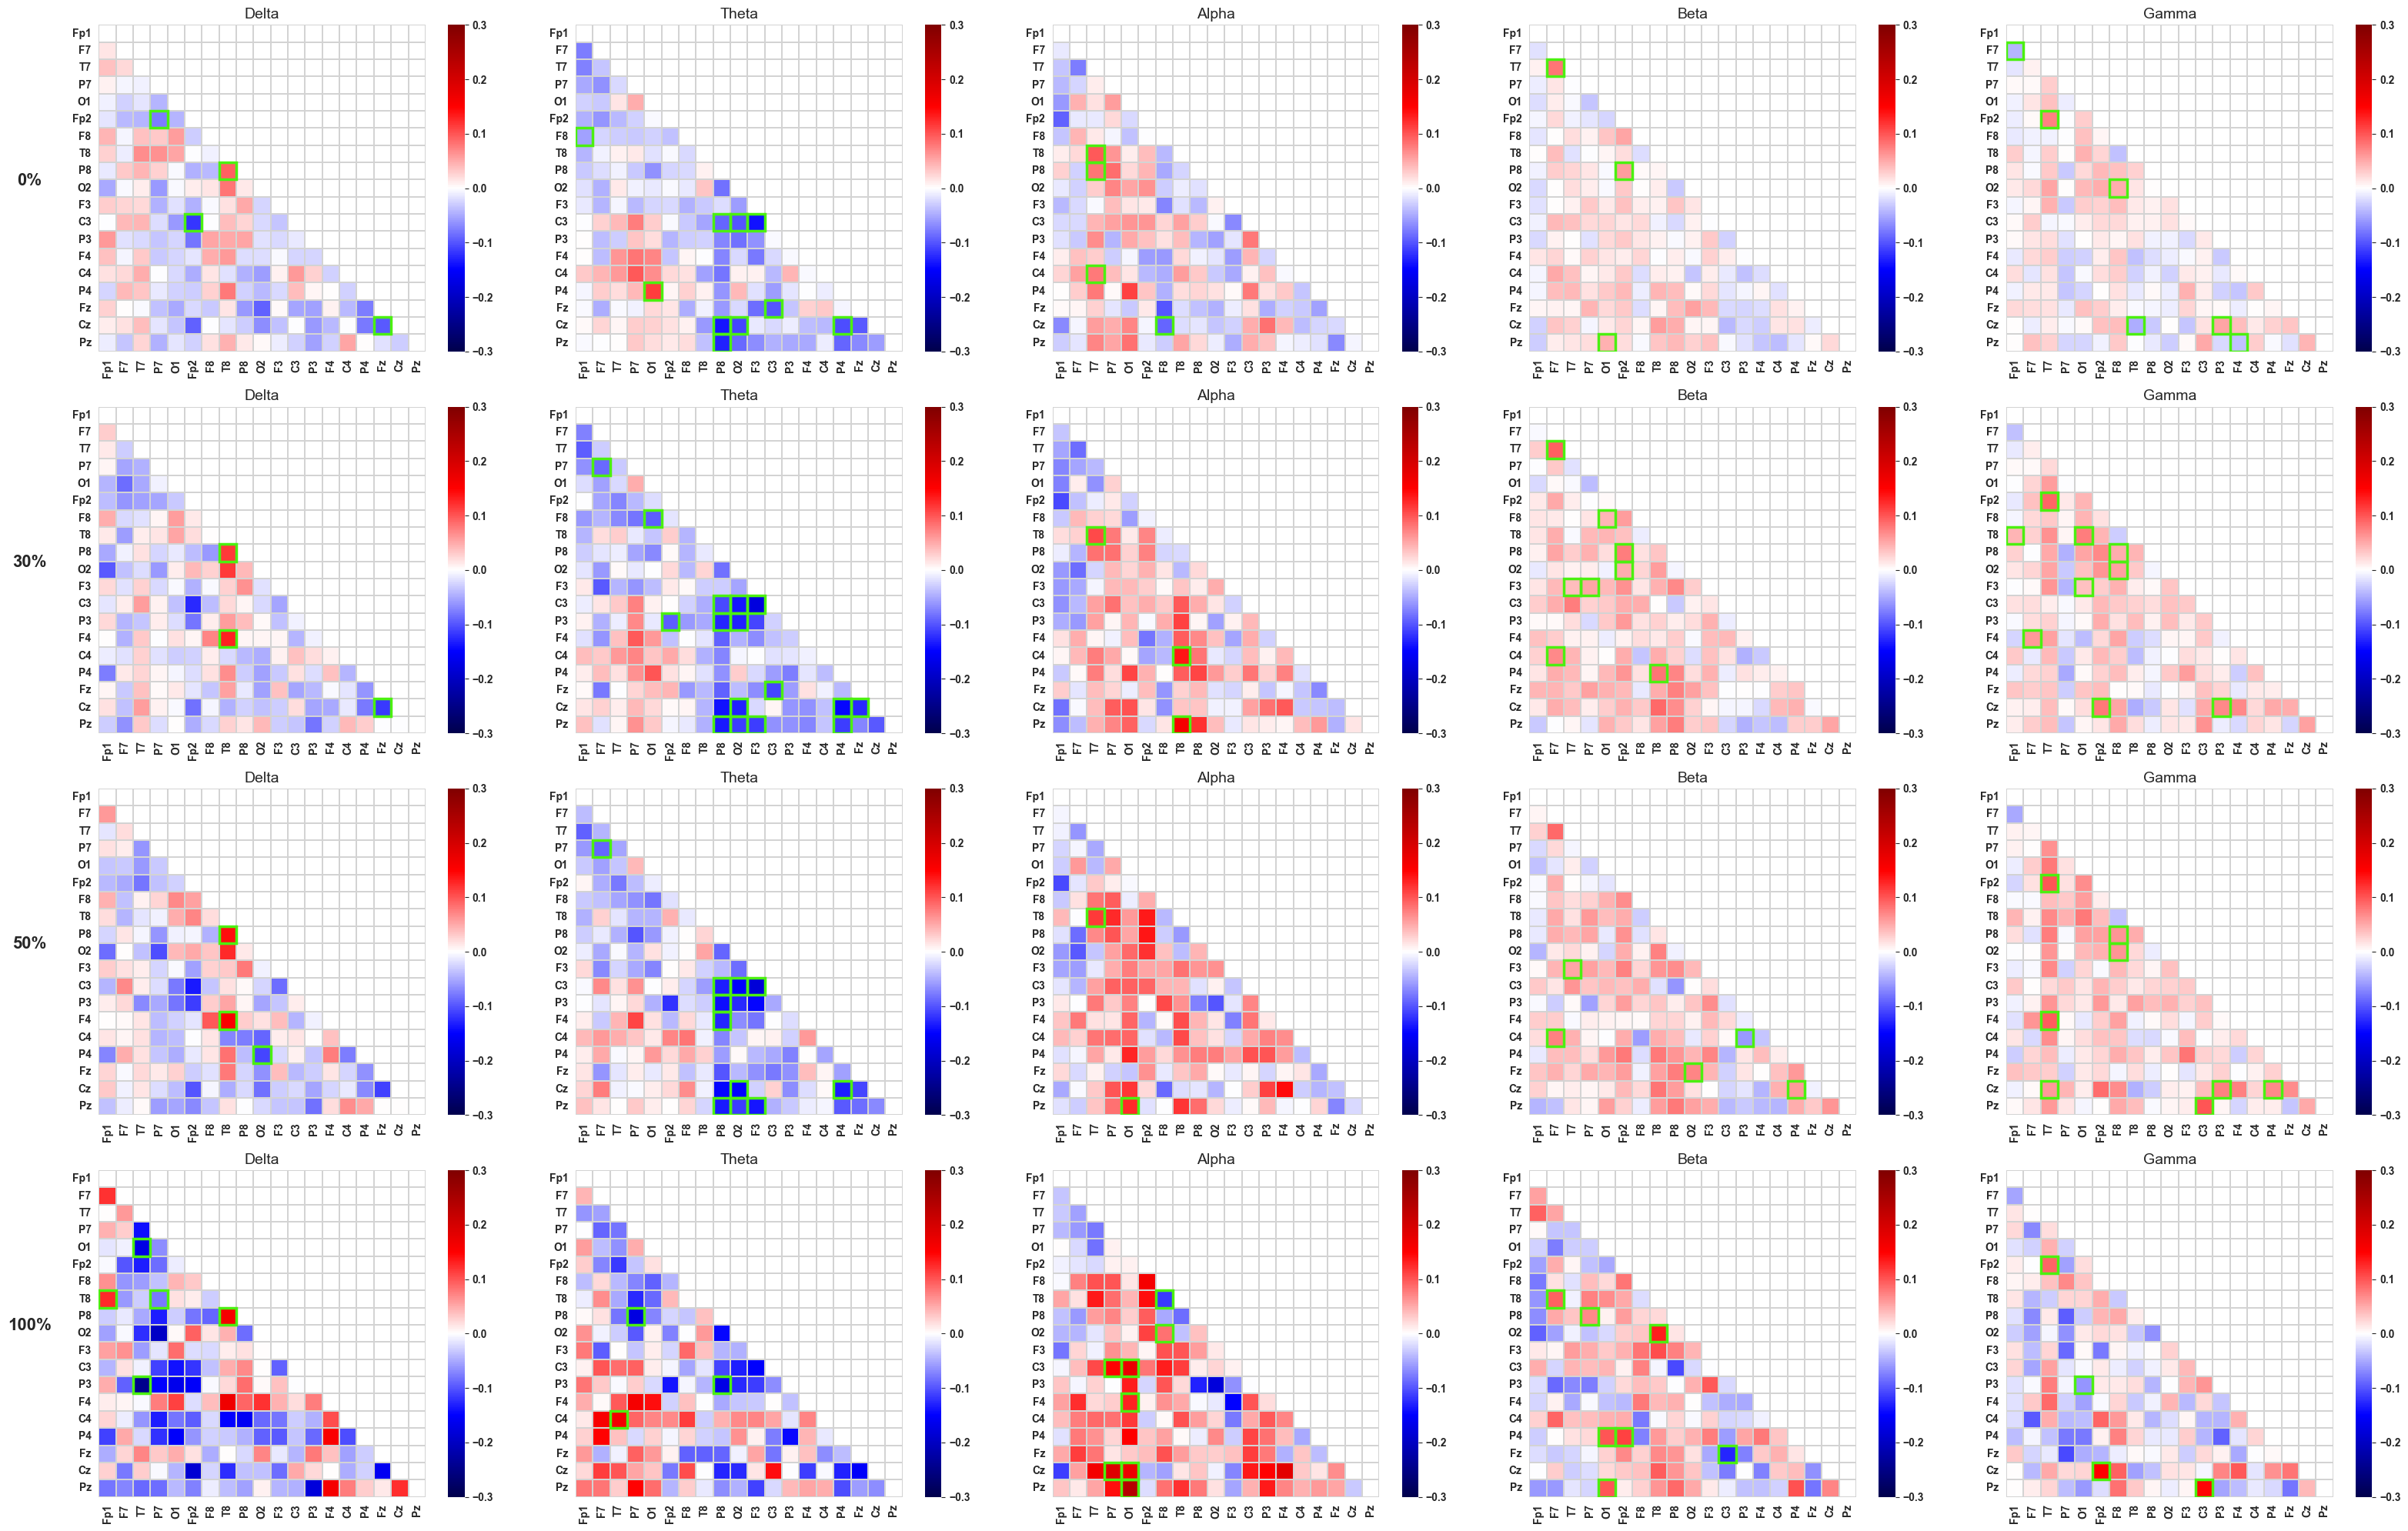

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from matplotlib.colors import ListedColormap, BoundaryNorm

matplotlib.rcParams['font.family'] = 'Arial'

# 1. CSV 불러오기
df = pd.read_csv("data_for_area_analysis_raw (1st + 2nd experiment).csv")

# 2. 기본 설정
channels = ['Fp1', 'F7', 'T7', 'P7', 'O1', 'Fp2', 'F8', 'T8', 'P8', 'O2',
            'F3', 'C3', 'P3', 'F4', 'C4', 'P4', 'Fz', 'Cz', 'Pz']
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
subgroup_keys = ['Responsiveness_0', 'Responsiveness_30', 'Responsiveness_50', 'Responsiveness_100']
row_titles = ['0%', '30%', '50%', '100%']

# 3. 각 그룹별로 차이와 p-value 행렬 계산
subgroup_diff = {key: {} for key in subgroup_keys}
subgroup_pval = {key: {} for key in subgroup_keys}

for key in subgroup_keys:
    df_sub = df[df[key] == 1]

    for band in bands:
        diff_matrix = np.zeros((19, 19))
        pval_matrix = np.ones((19, 19))

        for i, ch1 in enumerate(channels):
            for j, ch2 in enumerate(channels):
                if i > j:
                    pre_col = f'pre_{band}-{ch1}-{ch2}' if f'pre_{band}-{ch1}-{ch2}' in df_sub.columns else f'pre_{band}-{ch2}-{ch1}'
                    post_col = f'post_{band}-{ch1}-{ch2}' if f'post_{band}-{ch1}-{ch2}' in df_sub.columns else f'post_{band}-{ch2}-{ch1}'

                    if pre_col in df_sub.columns and post_col in df_sub.columns:
                        pre_vals = df_sub[pre_col]
                        post_vals = df_sub[post_col]

                        diff = (post_vals - pre_vals).mean()
                        diff_matrix[i, j] = diff

                        try:
                            _, p_val = wilcoxon(pre_vals, post_vals, zero_method="wilcox", correction=False)
                        except ValueError:
                            p_val = 1.0
                        pval_matrix[i, j] = p_val

        subgroup_diff[key][band] = diff_matrix
        subgroup_pval[key][band] = pval_matrix

# 4. 컬러바 설정
vmin, vmax = -0.3, 0.3
cbar_ticks = np.arange(-0.3, 0.31, 0.1)

# 5. 그림 그리기
fig, axs = plt.subplots(4, 5, figsize=(32, 20))
plt.subplots_adjust(hspace=0.6, wspace=0.5)

for row_idx, key in enumerate(subgroup_keys):
    for col_idx, band in enumerate(bands):
        ax = axs[row_idx, col_idx]
        mask = np.triu(np.ones((19, 19)), 0)

        sns.heatmap(subgroup_diff[key][band], xticklabels=channels, yticklabels=channels,
                    cmap='seismic', center=0, vmin=vmin, vmax=vmax, mask=mask, ax=ax,
                    cbar=True, square=True, linewidths=0.2, linecolor='lightgray',
                    cbar_kws={"ticks": cbar_ticks})

        # 제목, 라벨
        if col_idx == 0:
            ax.set_ylabel(row_titles[row_idx], fontsize=16, rotation=0, labelpad=40, weight='bold')
        ax.set_title(band, fontsize=14)
        ax.tick_params(axis='x', labelrotation=90)
        ax.tick_params(axis='y', labelrotation=0)

        # 테두리 정리
        for spine in ax.spines.values():
            spine.set_edgecolor('lightgray')
            spine.set_linewidth(0.1)
        ax.grid(False)

        # 유의미한 영역 강조
        for i in range(19):
            for j in range(19):
                if i > j and subgroup_pval[key][band][i, j] < 0.05:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='#4BF010', lw=2.5))

plt.tight_layout()

# 6. EPS로 저장
plt.savefig("connectivity_difference_matrix.eps", format='eps', dpi=300)

# 7. 그림 출력
plt.show()
